In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(64,64)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=False, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

In [5]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]
        
        # Add a variable to store the alpha values
        self.alpha = None

    def random_op(self):
        # 무작위 시드 고정
        set_random_seed(42)  # 원하는 시드 값 설정
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
    
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        
        # Calculate alpha and store it in the instance variable
        self.alpha = torch.exp(-(Q_output - K_output)**2).transpose(0, 1)
        # Example usage:
        visualize_attention(self.alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        # print("Q_output size:", Q_output.size())
        # print("K_output size:", K_output.size())
        # print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(self.alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(self.alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 1)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [6]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# CIFAR-10 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

# RGB -> Grayscale 변환
# 공식: 0.299*R + 0.587*G + 0.114*B
X_train_gray = np.dot(X_train_full[...,:3], [0.299, 0.587, 0.114])
X_test_gray = np.dot(X_test_full[...,:3], [0.299, 0.587, 0.114])

# 원하는 두 개의 클래스만 선택 (예: 클래스 0과 1)
selected_classes = [0, 1]

# 클래스 0과 1에 해당하는 데이터만 선택 (train set)
train_mask = np.isin(y_train_full, selected_classes)
X_train_filtered = X_train_gray[train_mask.squeeze()]
y_train_filtered = y_train_full[train_mask.squeeze()]

# 클래스 0과 1에 해당하는 데이터만 선택 (test set)
test_mask = np.isin(y_test_full, selected_classes)
X_test_filtered = X_test_gray[test_mask.squeeze()]
y_test_filtered = y_test_full[test_mask.squeeze()]

# 클래스 라벨을 이진 라벨로 변환 (0 또는 1로)
y_train_filtered = (y_train_filtered == selected_classes[1]).astype(int)
y_test_filtered = (y_test_filtered == selected_classes[1]).astype(int)

# 시드 고정
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 200
indices = np.random.choice(len(X_train_filtered), num_samples, replace=False)
X_sampled, y_sampled = X_train_filtered[indices], y_train_filtered[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42
)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)

# 결과 출력
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Sampled train labels: {np.unique(y_train)}")
print(f"Sampled test labels: {np.unique(y_test)}")


2024-10-16 21:41:58.542029: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 21:41:58.543027: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 21:41:58.546892: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 21:41:58.558867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 21:41:58.577411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Training set size: 160
Test set size: 40
Sampled train labels: [0 1]
Sampled test labels: [0 1]


In [7]:
X_train.shape

(160, 32, 32)

In [8]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [9]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [10]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0: 87, 1: 73}


In [11]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0: 13, 1: 27}


In [12]:
# Model, optimizer, and criterion setup
model = QSANN_text_classifier(64, 4, 2, 1, 1)
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [13]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [14]:
# 학습 후 모델 파라미터 저장 경로
model_save_path = "/home/jaeyeob/QVT/result/CIFAR10/qsann_classifier_1.pth"

  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([160, 64, 16])
Row sums: [55.56938  56.133884 56.93626  53.762115 50.81295  46.27309  45.96144
 54.286972 57.97334  50.96252  50.61669  53.8067   58.53839  57.189827
 51.134438 43.041466 50.297768 53.954834 57.833347 56.641792 49.540104
 51.516953 54.75911  56.105442 48.952362 55.140656 58.172684 57.935013
 57.14483  48.74355  53.750343 56.045067 57.054455 56.869957 57.451862
 53.88246  53.598495 52.89076  44.865112 43.218094 58.343853 54.7591
 51.89202  56.11769  40.799366 52.297188 57.542347 58.56174  51.72161
 54.506844 55.87056  57.331017 57.787613 56.333622 57.14308  52.85869
 47.167725 54.845203 57.734505 57.12275  49.635563 57.298832 40.76998
 58.483963]


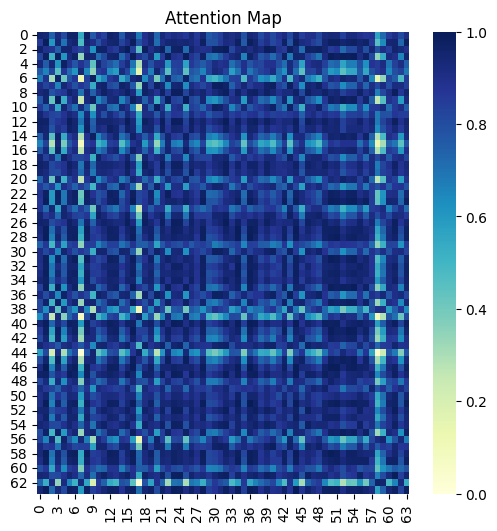

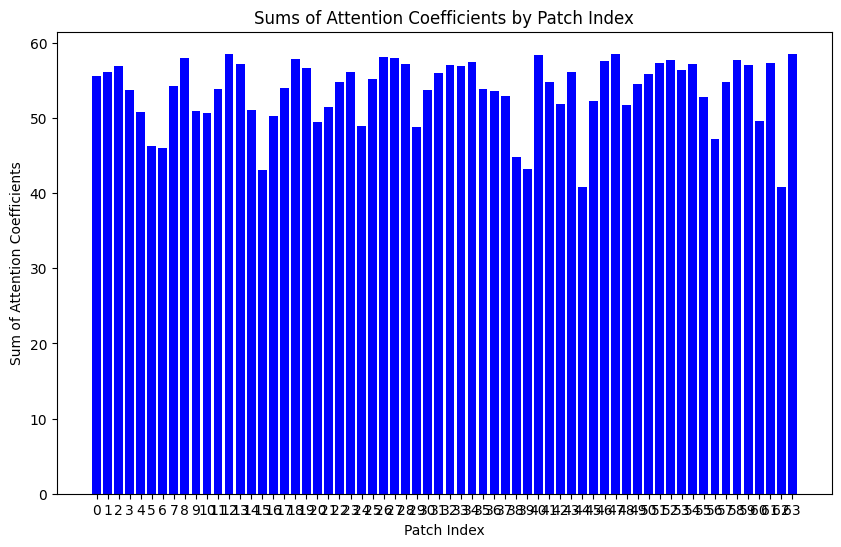

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.45625001192092896
Loss: 441.1431579589844


  3%|▎         | 1/30 [13:38<6:35:30, 818.28s/it]

Complete 0 th
torch.Size([160, 64, 16])
Row sums: [55.33054  56.374454 57.138306 54.01751  50.7355   45.44516  46.35397
 54.35209  58.03917  50.790455 50.808933 53.84796  58.46499  57.27075
 50.87286  43.68592  50.14135  53.99367  57.716583 56.458424 49.889885
 50.95211  54.48147  55.94063  49.162064 54.828873 58.12633  57.8237
 57.1773   48.829742 53.41671  55.7838   57.173523 57.033684 57.557858
 54.11108  53.699135 52.731075 44.15605  43.49448  58.28717  54.844357
 51.67682  56.138054 40.243267 52.036    57.60263  58.53485  52.051422
 54.351833 55.998055 57.375404 57.655495 56.250694 57.158516 52.929153
 46.94191  54.492714 57.562023 57.27578  49.483498 57.2274   40.30306
 58.556026]


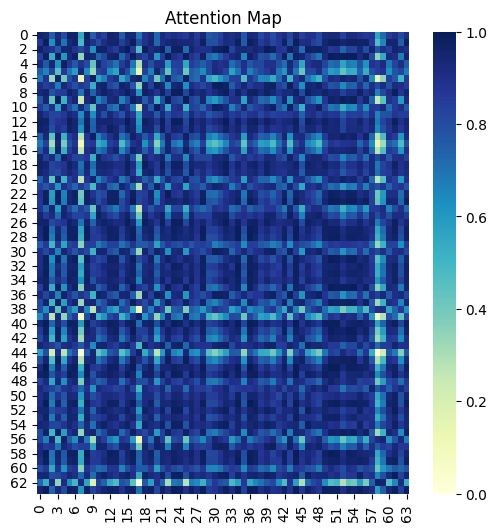

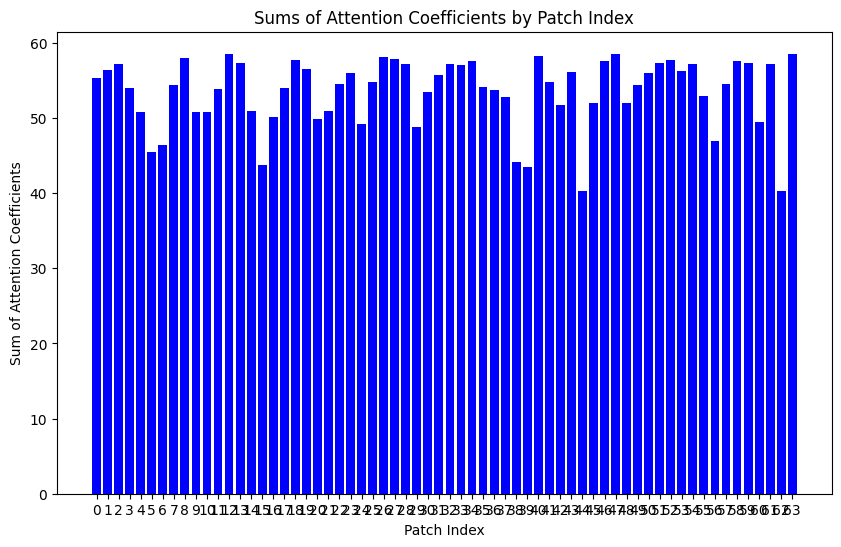

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.543749988079071
Loss: 440.6138610839844


  7%|▋         | 2/30 [29:04<6:51:29, 881.76s/it]

Complete 1 th
torch.Size([160, 64, 16])
Row sums: [55.307045 56.68487  56.93494  54.385345 51.004807 44.83979  46.940723
 54.271324 58.12525  50.762383 51.09755  53.807564 58.44065  57.280643
 51.30289  44.118618 50.15658  54.136497 57.66234  56.51452  50.024162
 50.647697 54.365517 55.86962  49.143085 55.065514 58.168133 57.772545
 57.276695 48.851166 53.497734 55.661793 57.23906  57.08473  57.69027
 54.384876 53.541733 52.77268  44.198383 44.1364   58.328026 55.159847
 51.640194 56.28141  40.50811  51.96874  57.712326 58.55403  52.5177
 54.248867 56.125404 57.42687  57.629112 56.301037 57.236816 53.44445
 47.310226 54.35116  57.487682 57.41439  49.54374  57.251175 39.966972
 58.667877]


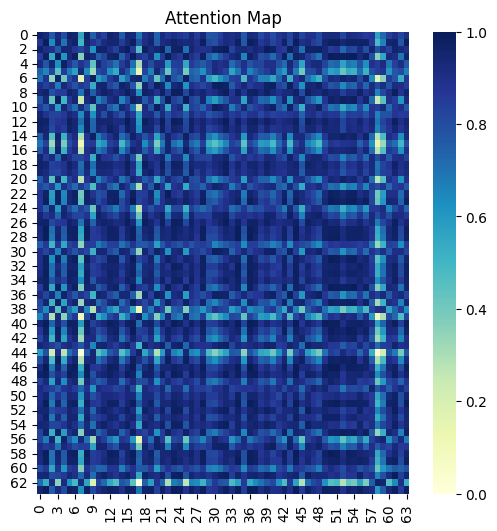

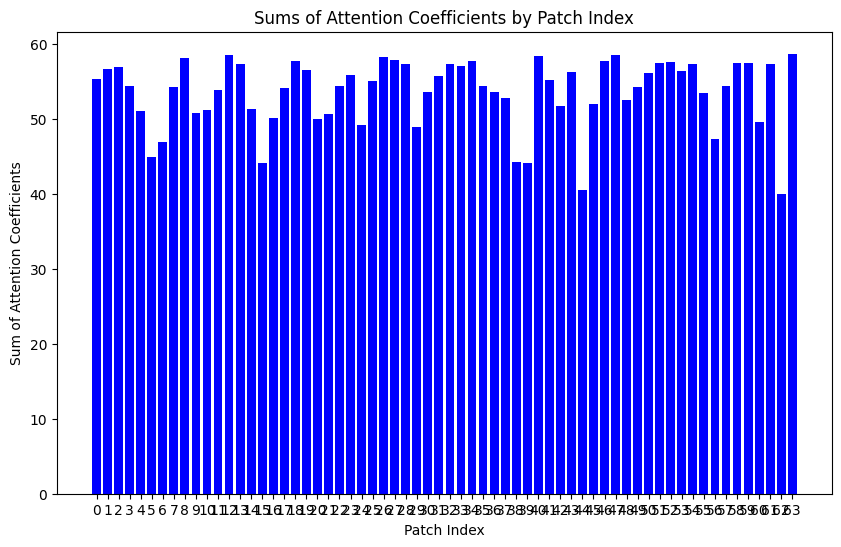

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.543749988079071
Loss: 440.7191467285156


 10%|█         | 3/30 [45:07<6:53:33, 919.02s/it]

Complete 2 th
torch.Size([160, 64, 16])
Row sums: [55.346977 57.003975 56.6737   54.782784 51.356377 44.29034  47.589012
 54.185677 58.204727 50.818268 51.403458 53.746483 58.42402  57.27365
 51.85118  44.451378 50.24316  54.311596 57.611824 56.62834  50.11608
 50.40184  54.297386 55.830338 49.01964  55.37462  58.22161  57.734432
 57.402557 48.902245 53.628952 55.584312 57.292175 57.1102   57.808346
 54.695812 53.289627 52.862473 44.40442  44.886414 58.404743 55.522045
 51.661285 56.429653 41.038742 51.977745 57.82243  58.58995  53.012688
 54.15155  56.24238  57.49861  57.63333  56.387703 57.33319  54.025703
 47.741776 54.20404  57.44181  57.51815  49.68931  57.296402 39.65693
 58.772644]


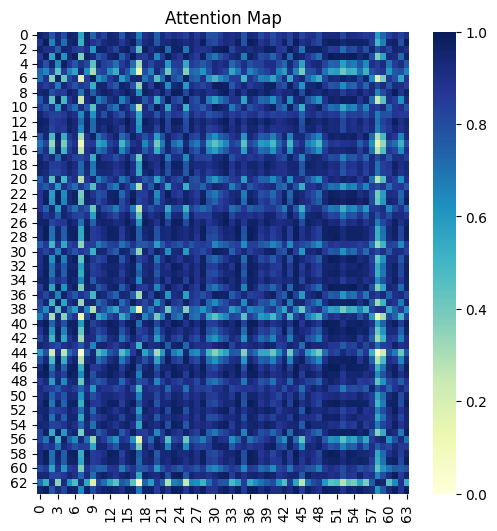

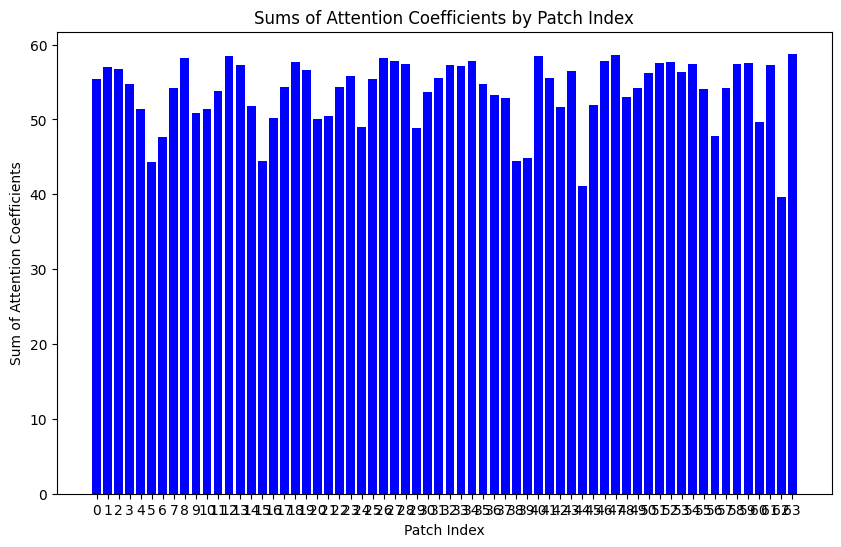

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.543749988079071
Loss: 440.2625427246094


 13%|█▎        | 4/30 [1:01:37<6:50:23, 947.06s/it]

Complete 3 th
torch.Size([160, 64, 16])
Row sums: [55.41593  57.307693 56.382378 55.172623 51.743855 43.77449  48.256584
 54.0961   58.27343  50.913647 51.71412  53.66783  58.412792 57.238644
 52.423477 44.656185 50.38705  54.501503 57.554653 56.76834  50.16576
 50.182697 54.237907 55.790886 48.82253  55.70763  58.272194 57.695606
 57.528084 48.958157 53.78595  55.512184 57.32817  57.114998 57.918297
 55.002125 52.992287 52.958725 44.69285  45.655598 58.49871  55.8904
 51.698105 56.575214 41.713966 52.008316 57.91924  58.63095  53.50412
 54.052902 56.34987  57.57647  57.659977 56.48179  57.439487 54.603527
 48.192093 54.038376 57.400837 57.57962  49.863163 57.350143 39.370426
 58.858532]


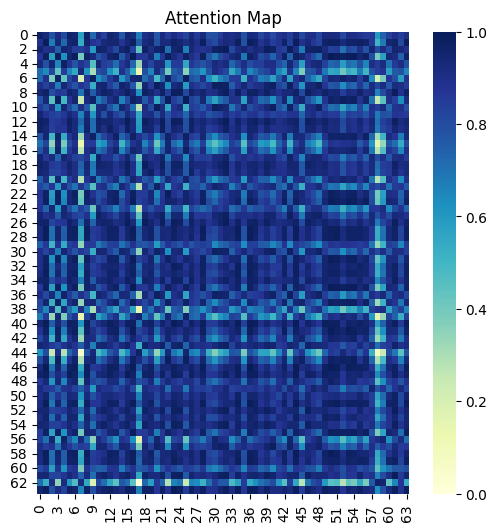

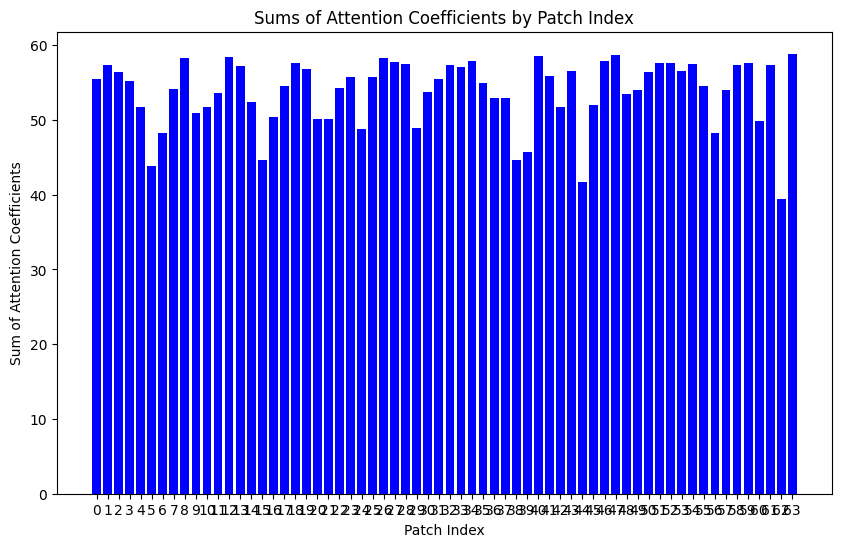

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.5562499761581421
Loss: 438.7152099609375


 17%|█▋        | 5/30 [1:19:33<6:53:51, 993.25s/it]

Complete 4 th
torch.Size([160, 64, 16])
Row sums: [55.483402 57.58059  56.06581  55.530224 52.1621   43.318745 48.89328
 53.98444  58.33187  51.000477 52.033726 53.57567  58.403225 57.173817
 52.972626 44.72947  50.63614  54.706116 57.50472  56.91861  50.16952
 49.99276  54.16194  55.734676 48.613365 56.051125 58.342598 57.642284
 57.631138 48.996166 53.96601  55.417137 57.343246 57.094643 58.02719
 55.268143 52.695656 53.032944 45.05337  46.383102 58.593517 56.23797
 51.731094 56.713615 42.45733  52.004158 58.00028  58.669075 53.965244
 53.95717  56.440636 57.654858 57.730003 56.56574  57.55156  55.13836
 48.662777 54.050423 57.355618 57.605797 50.02313  57.42449  39.127136
 58.926353]


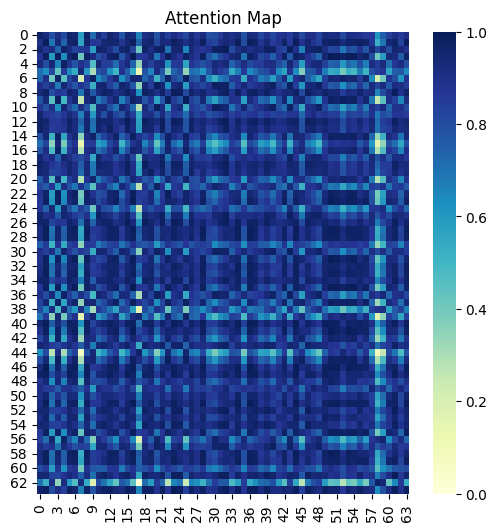

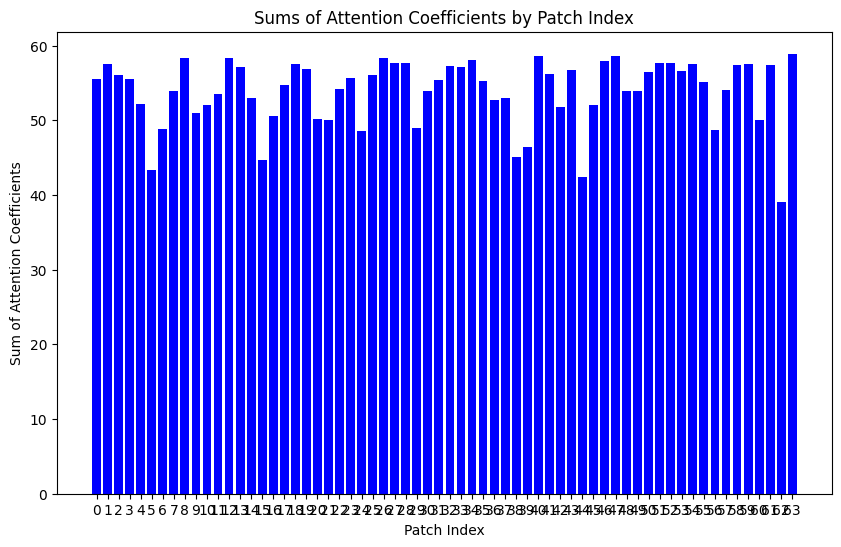

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.6499999761581421
Loss: 434.76220703125


 20%|██        | 6/30 [1:36:48<6:42:59, 1007.46s/it]

Complete 5 th
torch.Size([160, 64, 16])
Row sums: [55.49589  57.741486 55.664104 55.773476 52.416252 42.906937 49.427757
 53.841755 58.328476 50.995712 52.315006 53.436913 58.318882 57.02086
 53.403404 44.826485 50.80293  54.855457 57.37843  56.990532 50.07785
 49.85816  54.076477 55.59047  48.381508 56.330715 58.359932 57.524193
 57.64837  48.947914 54.114616 55.24209  57.270344 56.978355 58.050144
 55.376915 52.370895 53.01579  45.411617 47.01332  58.604973 56.47175
 51.691406 56.760044 43.12781  51.941605 57.9934   58.632385 54.330193
 53.814568 56.47251  57.68261  57.75741  56.57479  57.607063 55.526535
 49.09349  54.136116 57.22932  57.59034  50.12255  57.441    38.926926
 58.91005 ]


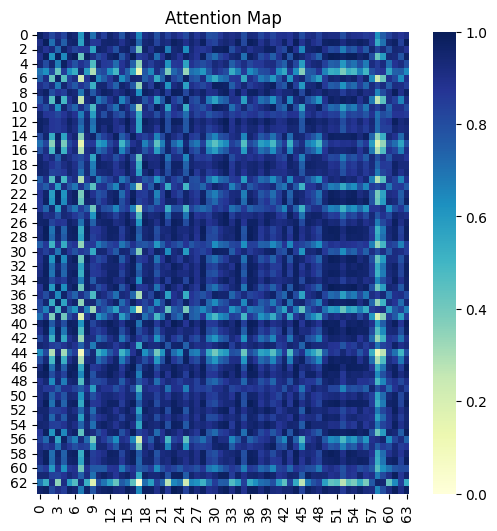

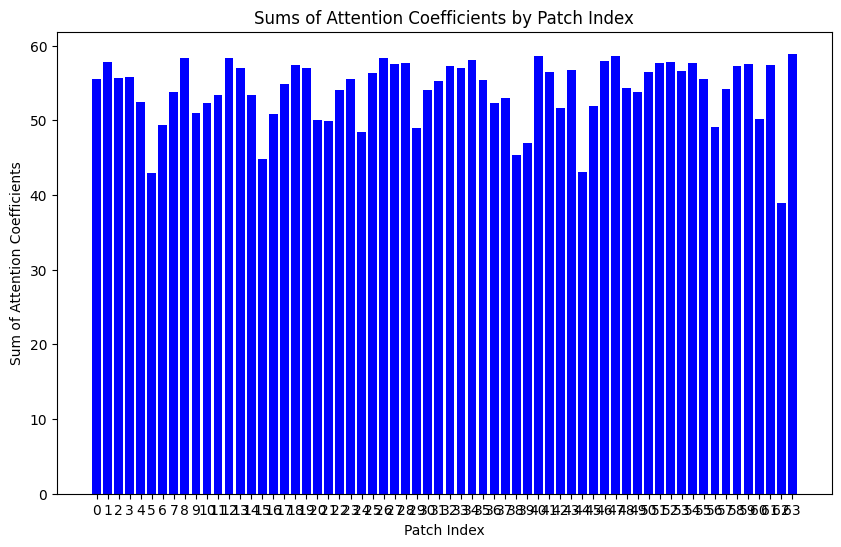

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.637499988079071
Loss: 434.88641357421875


 23%|██▎       | 7/30 [1:54:16<6:31:16, 1020.73s/it]

Complete 6 th
torch.Size([160, 64, 16])
Row sums: [55.46172  57.888786 55.285065 56.02077  52.73088  42.66665  49.966106
 53.782143 58.330826 50.986275 52.555485 53.358715 58.296146 56.883064
 53.84017  45.25467  51.095665 55.00763  57.250633 57.023476 50.113045
 49.860214 54.08821  55.471527 48.283043 56.57244  58.325417 57.412605
 57.67153  48.929417 54.25363  55.08794  57.210167 56.874405 58.073784
 55.359722 52.01179  53.022053 45.519047 47.67396  58.620697 56.710655
 51.719864 56.78402  43.592842 51.907513 58.020416 58.620277 54.69747
 53.725647 56.551453 57.748226 57.819122 56.631256 57.667473 55.90383
 49.428658 54.25437  57.127354 57.600456 50.197636 57.327034 38.76407
 58.878345]


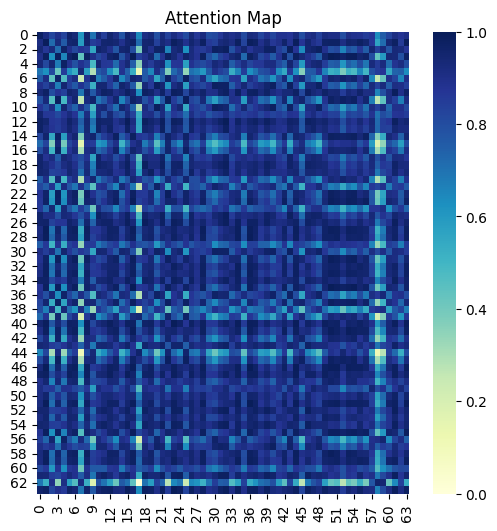

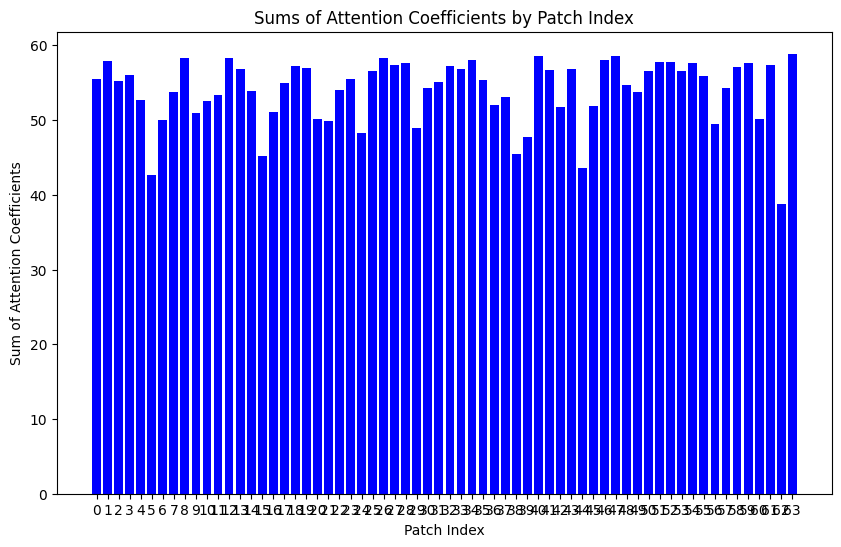

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.574999988079071
Loss: 435.847900390625


 27%|██▋       | 8/30 [2:11:06<6:13:02, 1017.39s/it]

Complete 7 th
torch.Size([160, 64, 16])
Row sums: [55.428444 58.024895 54.872517 56.272453 53.067608 42.390007 50.51916
 53.70285  58.34706  50.972748 52.810158 53.318207 58.330997 56.75198
 54.286316 45.850655 51.44644  55.160282 57.115166 57.041065 50.268723
 49.84191  54.118904 55.380962 48.22762  56.79318  58.28014  57.303448
 57.702774 48.931717 54.389267 54.954697 57.15387  56.787098 58.09233
 55.310677 51.60096  53.046825 45.51758  48.34441  58.64392  56.95596
 51.793797 56.776962 43.971725 51.881687 58.076015 58.618515 55.058754
 53.655426 56.650047 57.836803 57.899338 56.71007  57.729797 56.274017
 49.738617 54.359047 57.04091  57.626213 50.26612  57.165775 38.582603
 58.83679 ]


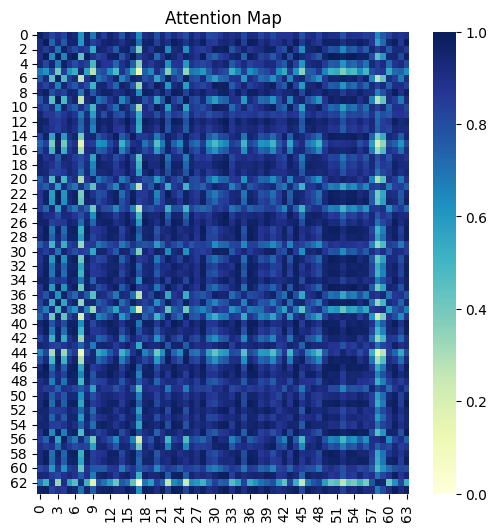

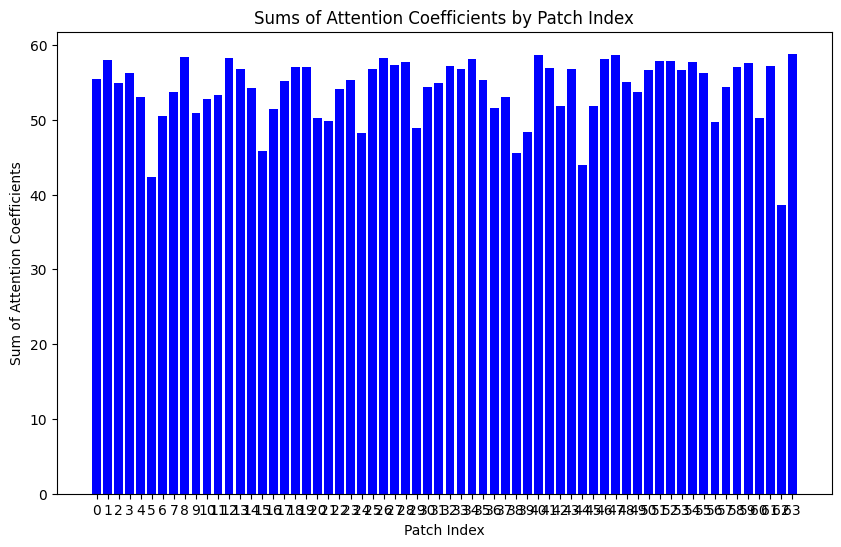

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.637499988079071
Loss: 433.529052734375


 30%|███       | 9/30 [2:28:03<5:56:04, 1017.36s/it]

Complete 8 th
torch.Size([160, 64, 16])
Row sums: [55.37612  58.14524  54.474293 56.522827 53.41674  42.218452 51.08928
 53.66586  58.36946  50.983635 52.994045 53.311737 58.388443 56.628387
 54.73848  46.532814 51.82576  55.297222 56.96933  57.03943  50.493515
 49.970703 54.266235 55.310833 48.24259  56.983955 58.21993  57.19844
 57.731533 48.940113 54.4852   54.831932 57.117485 56.713524 58.097916
 55.212105 51.155716 53.080685 45.356205 49.02166  58.669647 57.200172
 51.951603 56.79909  44.2423   51.95719  58.146515 58.6315   55.408478
 53.605453 56.75761  57.9395   57.98844  56.806007 57.793438 56.61445
 49.89753  54.482597 57.002182 57.719086 50.336746 56.953842 38.371094
 58.784386]


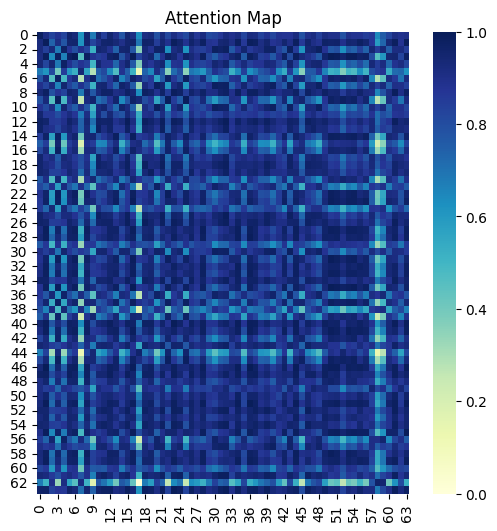

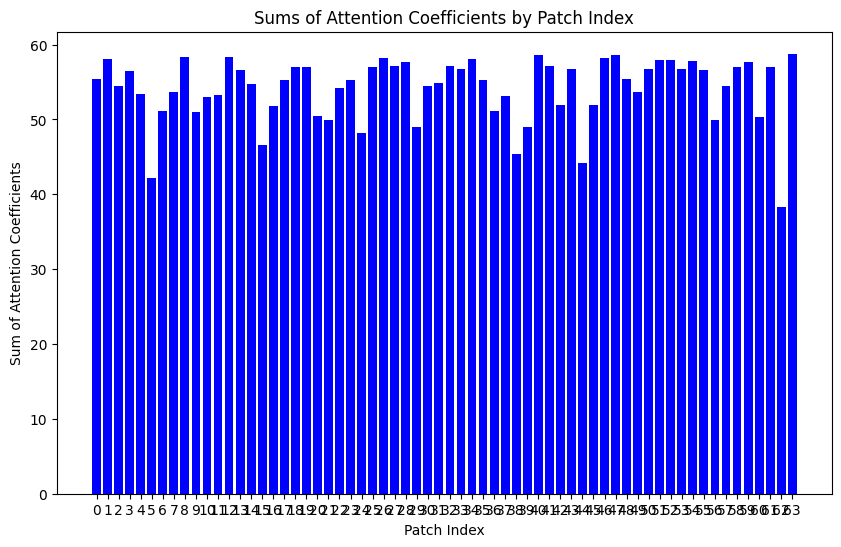

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.75
Loss: 431.8491516113281


 33%|███▎      | 10/30 [2:45:48<5:43:57, 1031.88s/it]

Complete 9 th
torch.Size([160, 64, 16])
Row sums: [55.326015 58.243156 54.197258 56.75065  53.758896 42.017696 51.61383
 53.654198 58.39387  51.02182  53.11013  53.346336 58.42103  56.516716
 55.16465  47.205696 52.17122  55.368393 56.813454 57.015144 50.687523
 50.17314  54.471157 55.261528 48.278965 57.164864 58.15715  57.095158
 57.76397  48.953003 54.555145 54.727535 57.084778 56.63315  58.10871
 55.09766  50.691578 53.12423  45.12301  49.636116 58.692192 57.4219
 52.128014 56.8352   44.466614 52.115425 58.209763 58.648758 55.72989
 53.546066 56.831615 58.04264  58.07632  56.901466 57.862316 56.902428
 49.95724  54.60193  56.981808 57.83583  50.405792 56.7106   38.150513
 58.724167]


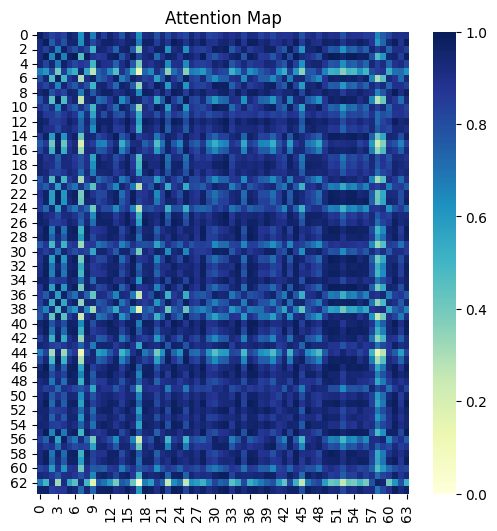

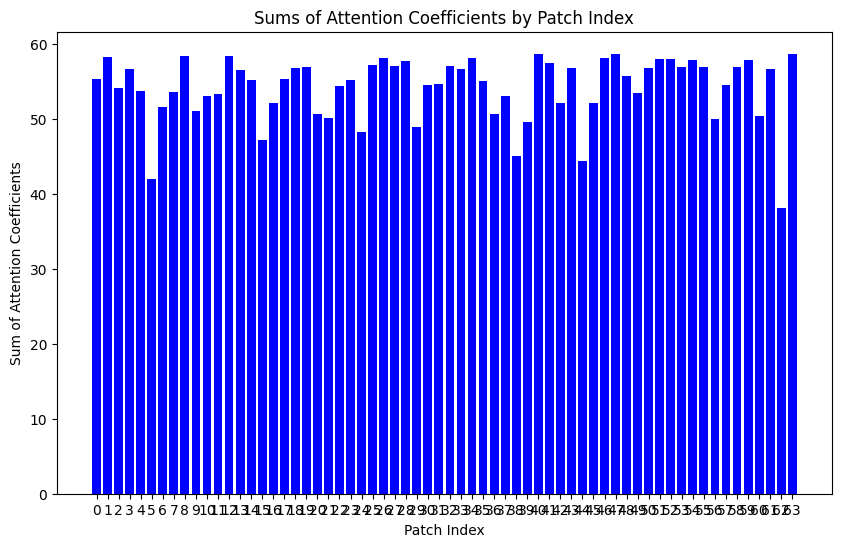

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.6875
Loss: 432.6331787109375


 37%|███▋      | 11/30 [3:03:44<5:31:06, 1045.58s/it]

Complete 10 th
torch.Size([160, 64, 16])
Row sums: [55.31076  58.328415 53.902916 56.94411  54.065193 41.80877  52.06498
 53.64591  58.420067 51.002174 53.292213 53.388977 58.437927 56.395317
 55.535225 47.71502  52.451107 55.4585   56.6969   56.99791  50.76201
 50.386444 54.634266 55.18078  48.26908  57.37657  58.148544 57.024696
 57.815933 48.97596  54.69192  54.59002  57.02691  56.532204 58.16078
 55.157166 50.438892 53.166077 45.09247  50.18106  58.718014 57.61563
 52.23448  56.861595 44.712273 52.179276 58.256805 58.676365 56.02498
 53.48696  56.856346 58.133896 58.169342 56.98941  57.940746 57.159687
 50.11948  54.718613 56.937332 57.922512 50.45599  56.529922 38.03721
 58.68571 ]


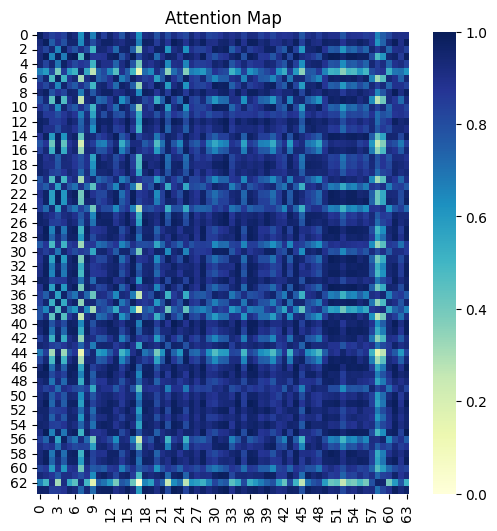

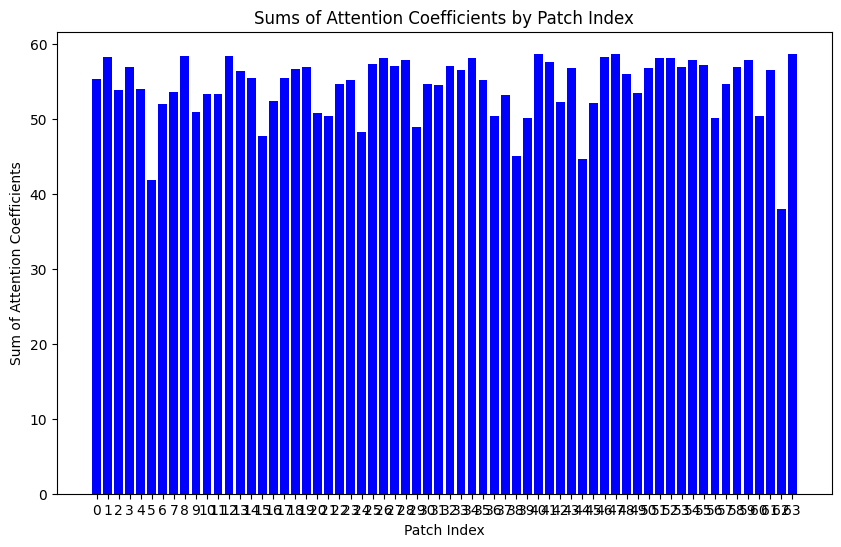

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.6937500238418579
Loss: 432.448974609375


 40%|████      | 12/30 [3:22:56<5:23:21, 1077.86s/it]

Complete 11 th
torch.Size([160, 64, 16])
Row sums: [55.276665 58.33799  53.529186 57.044624 54.274853 41.56826  52.398327
 53.581482 58.377136 50.871384 53.4739   53.3692   58.37452  56.196297
 55.796173 48.004463 52.622826 55.50843  56.56119  56.918655 50.680397
 50.528084 54.683357 55.00557  48.17193  57.539104 58.12442  56.928112
 57.81443  48.96395  54.81668  54.34925  56.879456 56.344322 58.17894
 55.25843  50.354507 53.147213 45.20216  50.61637  58.679214 57.72167
 52.218327 56.81749  44.937737 52.09088  58.220165 58.645233 56.23555
 53.373024 56.791523 58.14621  58.19393  57.00319  57.954193 57.32937
 50.326736 54.738235 56.803825 57.91272  50.429558 56.367073 37.996483
 58.600792]


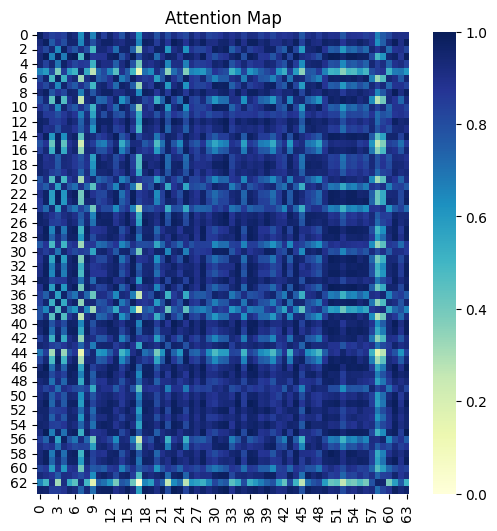

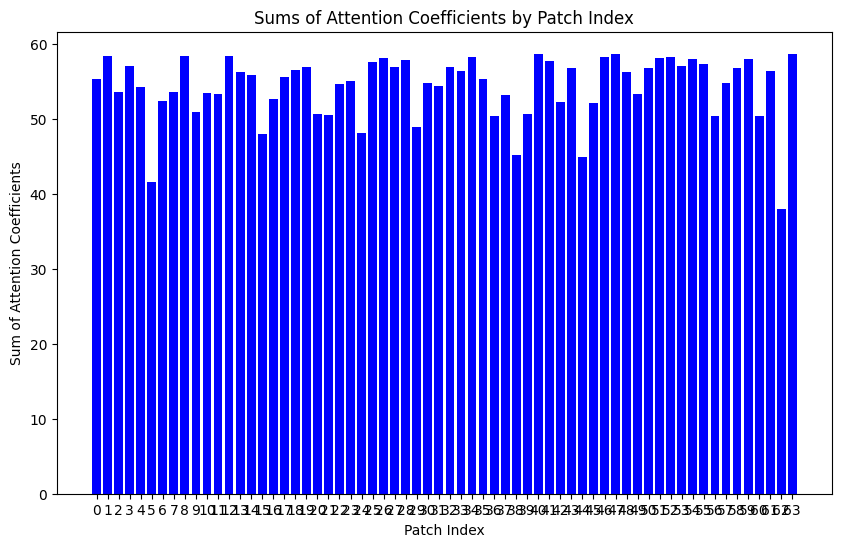

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.75
Loss: 430.8399963378906


 43%|████▎     | 13/30 [3:41:11<5:06:50, 1082.97s/it]

Complete 12 th
torch.Size([160, 64, 16])
Row sums: [55.262238 58.335896 53.18553  57.12868  54.48302  41.322506 52.699303
 53.523018 58.330345 50.74035  53.640892 53.36708  58.291588 55.994244
 56.0411   48.25099  52.75365  55.52195  56.431404 56.82179  50.553932
 50.691357 54.73902  54.825043 48.061684 57.68913  58.117462 56.848854
 57.816048 48.982597 54.94951  54.094925 56.714108 56.141632 58.208664
 55.3984   50.35176  53.138405 45.346546 51.01499  58.63939  57.814075
 52.18272  56.77379  45.16608  51.99092  58.172245 58.615086 56.429432
 53.25216  56.70919  58.155434 58.205963 57.012196 57.965137 57.480076
 50.532722 54.699173 56.66282  57.904953 50.39482  56.223434 37.988235
 58.517586]


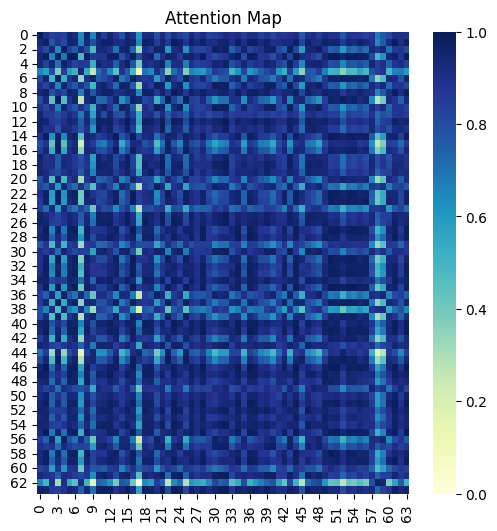

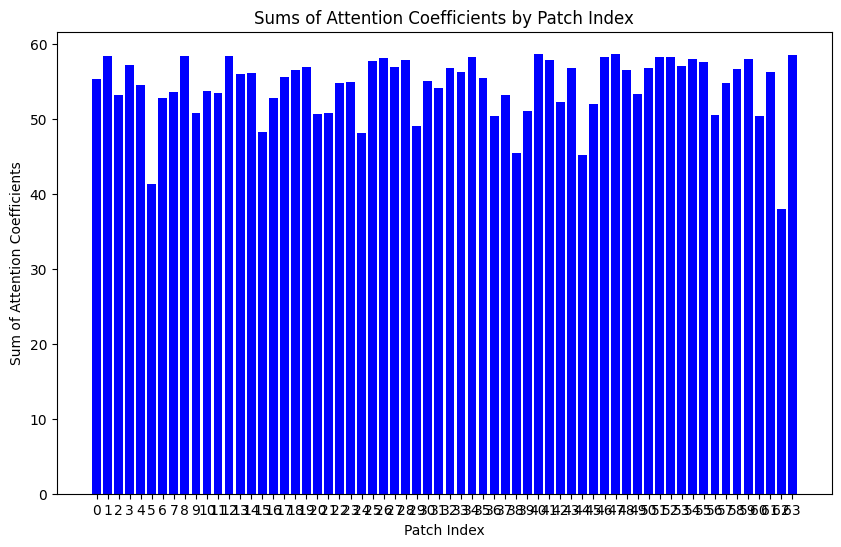

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.7749999761581421
Loss: 429.5949401855469


 47%|████▋     | 14/30 [3:58:16<4:44:10, 1065.65s/it]

Complete 13 th
torch.Size([160, 64, 16])
Row sums: [55.192856 58.29472  52.79707  57.196037 54.668495 40.970425 52.99194
 53.41203  58.262833 50.66545  53.680878 53.34265  58.18435  55.78969
 56.285156 48.589592 52.827385 55.4432   56.237823 56.670277 50.47281
 50.85878  54.852066 54.68734  47.91635  57.789528 58.061005 56.72428
 57.786877 48.993217 55.017944 53.87832  56.55716  55.945793 58.209766
 55.46395  50.14544  53.126007 45.251244 51.41703  58.575912 57.883614
 52.195713 56.72285  45.33615  52.03025  58.110126 58.55861  56.587593
 53.099686 56.59788  58.150475 58.190403 57.004414 57.952576 57.586945
 50.550095 54.632843 56.556625 57.909554 50.342457 55.97332  37.804676
 58.389442]


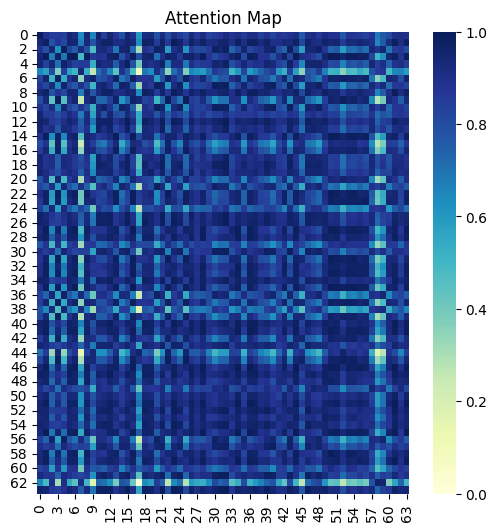

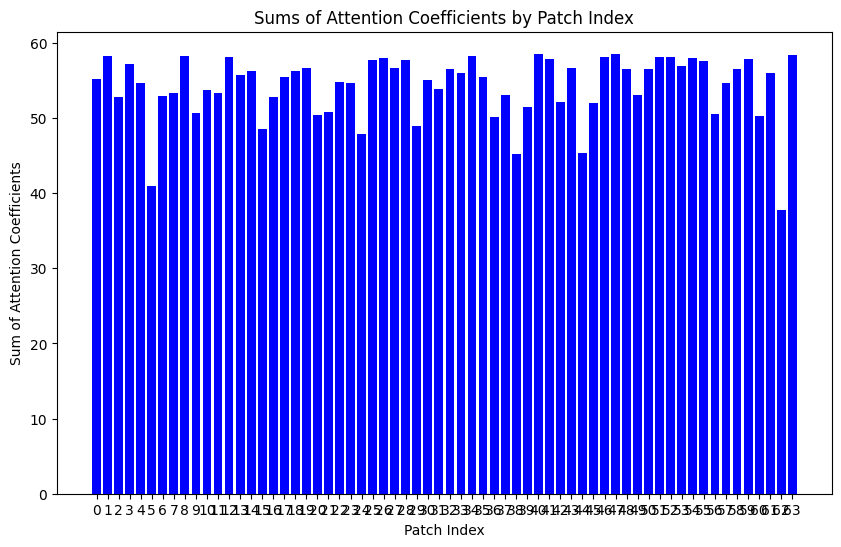

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.768750011920929
Loss: 430.02886962890625


 50%|█████     | 15/30 [4:15:24<4:23:31, 1054.11s/it]

Complete 14 th
torch.Size([160, 64, 16])
Row sums: [55.048264 58.2275   52.272293 57.253994 54.839527 40.485806 53.294804
 53.21908  58.192764 50.63003  53.651497 53.279037 58.11197  55.583054
 56.527916 49.001884 52.842144 55.31472  55.986355 56.516464 50.488735
 51.01782  55.00885  54.60543  47.741966 57.858826 57.9566   56.561466
 57.73221  48.966423 55.044212 53.70192  56.432846 55.792297 58.191948
 55.421257 49.715652 53.096615 44.91752  51.84124  58.499817 57.935165
 52.266045 56.672554 45.429016 52.1784   58.055195 58.486824 56.711143
 52.93596  56.484196 58.1352   58.171417 56.986748 57.925964 57.6483
 50.40476  54.610413 56.517693 57.91897  50.259964 55.61209  37.45511
 58.22062 ]


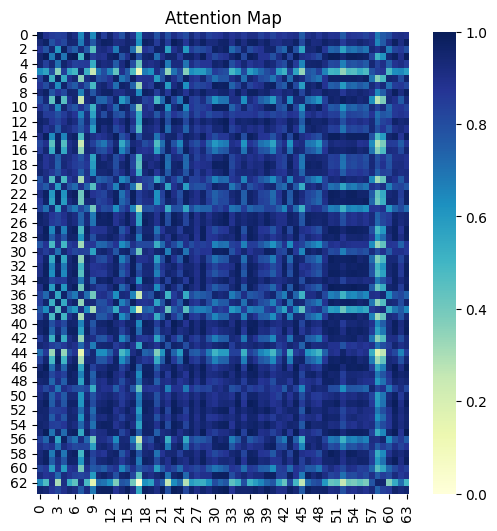

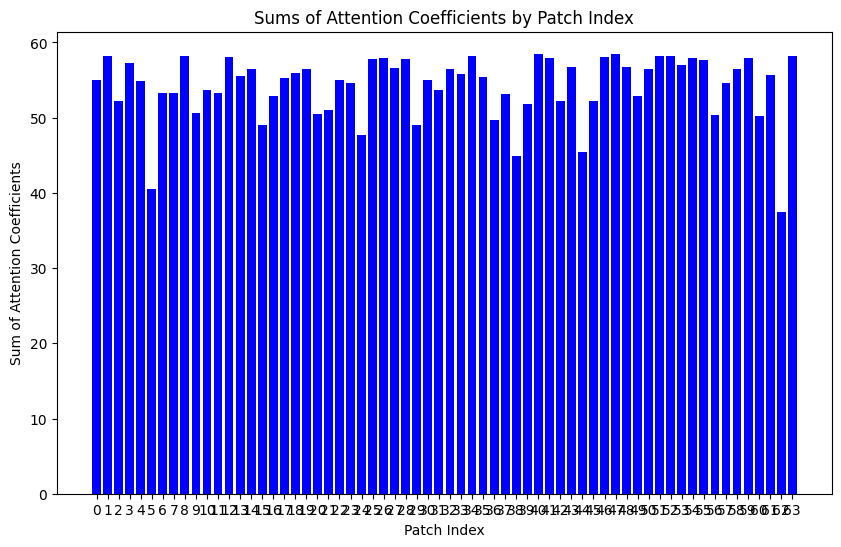

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.7562500238418579
Loss: 429.79937744140625


 53%|█████▎    | 16/30 [4:32:35<4:04:20, 1047.17s/it]

Complete 15 th
torch.Size([160, 64, 16])
Row sums: [54.856216 58.154575 51.65734  57.30818  55.013077 39.935844 53.607002
 52.965546 58.131355 50.635136 53.598545 53.191887 58.073162 55.392822
 56.77137  49.46964  52.80912  55.164764 55.70205  56.396248 50.585587
 51.189766 55.199825 54.57873  47.565548 57.91555  57.82297  56.377274
 57.671757 48.92258  55.06169  53.574905 56.352245 55.696587 58.170654
 55.315247 49.153114 53.060734 44.438362 52.2909   58.426575 57.97424
 52.380695 56.631813 45.474518 52.400677 58.017685 58.41316  56.813835
 52.7863   56.381256 58.114655 58.15741  56.9701   57.900127 57.67862
 50.161583 54.61538  56.535484 57.928413 50.16439  55.170425 37.014397
 58.025513]


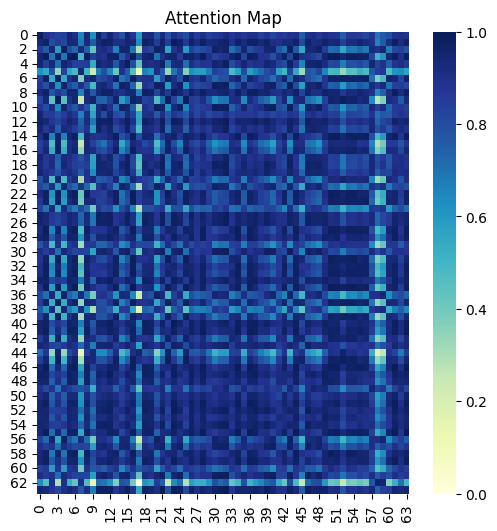

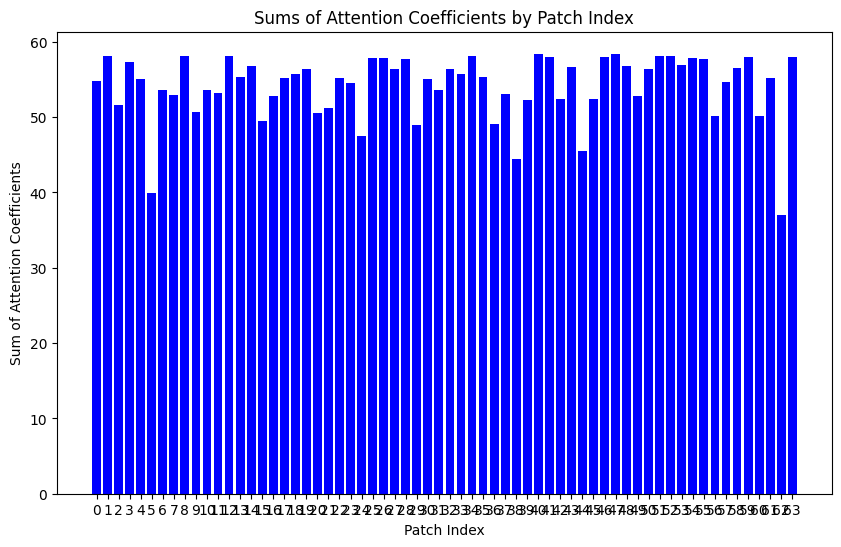

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.793749988079071
Loss: 428.432861328125


 57%|█████▋    | 17/30 [4:49:39<3:45:23, 1040.25s/it]

Complete 16 th
torch.Size([160, 64, 16])
Row sums: [54.65696  58.080532 50.984062 57.356396 55.182816 39.35193  53.900146
 52.68283  58.074394 50.683975 53.502777 53.09475  58.045967 55.223362
 57.005466 49.96444  52.743023 54.984875 55.401745 56.288242 50.72055
 51.37779  55.408905 54.59082  47.387344 57.962822 57.669617 56.17857
 57.612442 48.888275 55.085773 53.50798  56.309525 55.639194 58.146523
 55.1847   48.508087 53.02954  43.875706 52.74858  58.35563  57.99836
 52.522377 56.59262  45.47898  52.667126 57.982327 58.33805  56.903305
 52.648834 56.275093 58.08407  58.14303  56.95278  57.876724 57.690895
 49.858025 54.63096  56.583466 57.926968 50.07318  54.67188  36.52369
 57.809715]


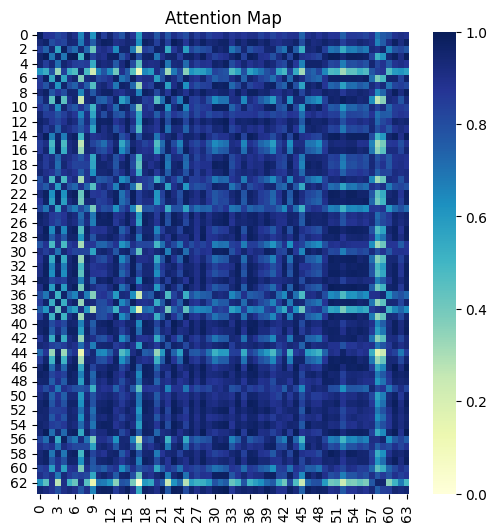

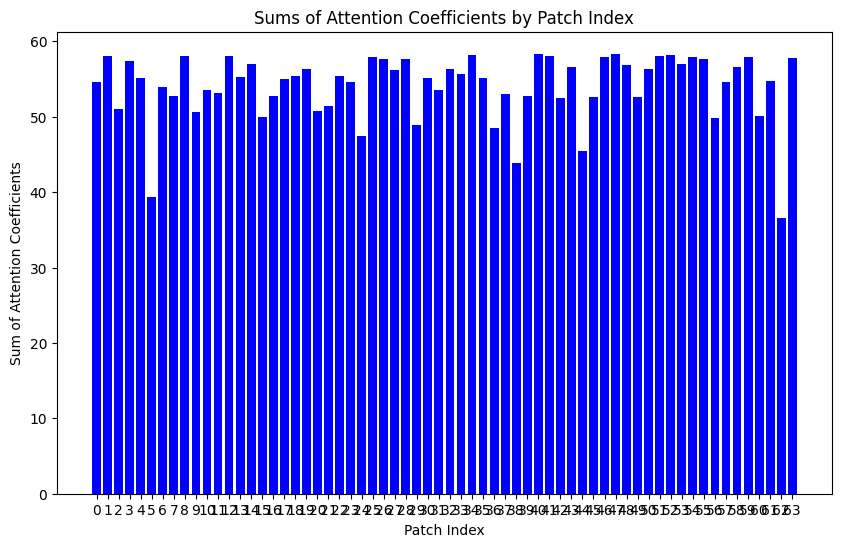

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.793749988079071
Loss: 428.0561218261719


 60%|██████    | 18/30 [5:06:46<3:27:16, 1036.34s/it]

Complete 17 th
torch.Size([160, 64, 16])
Row sums: [54.5517   58.00901  50.33409  57.401    55.351814 38.809593 54.165848
 52.41365  58.018707 50.757843 53.398357 53.010048 58.013474 55.064346
 57.21794  50.4431   52.663788 54.79241  55.12584  56.17067  50.82786
 51.583427 55.61509  54.60594  47.192867 58.002495 57.522095 55.992558
 57.565083 48.906807 55.13467  53.45835  56.26854  55.576424 58.12248
 55.096306 47.909554 53.022697 43.348442 53.183792 58.28444  58.013794
 52.665833 56.551    45.494625 52.93336  57.934963 58.266094 56.99416
 52.51564  56.15654  58.041786 58.119957 56.935    57.857605 57.70986
 49.58123  54.623184 56.622746 57.9087   50.011734 54.204063 36.08524
 57.591354]


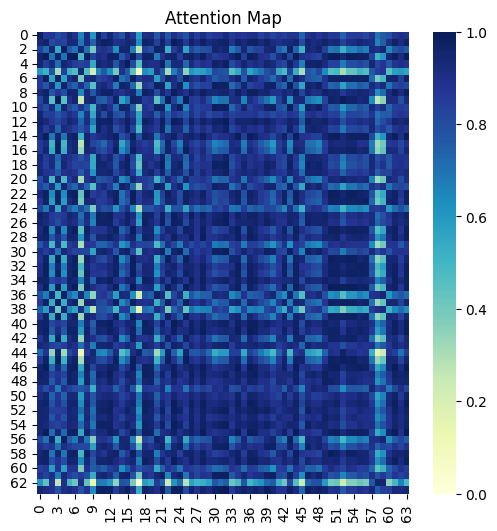

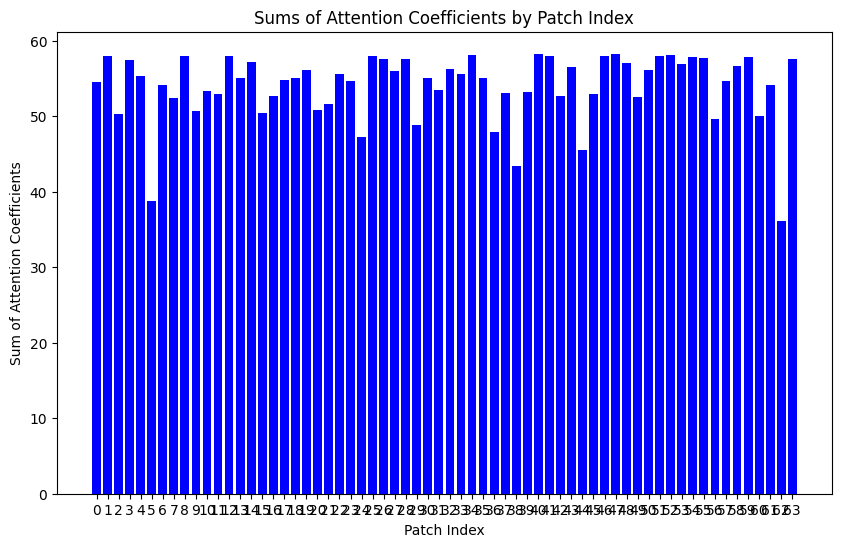

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8062499761581421
Loss: 428.28912353515625


 63%|██████▎   | 19/30 [5:23:52<3:09:24, 1033.17s/it]

Complete 18 th
torch.Size([160, 64, 16])
Row sums: [54.47632  57.877563 49.706375 57.377785 55.46366  38.32571  54.34347
 52.129288 57.897346 50.768257 53.276253 52.886032 57.90451  54.840237
 57.336823 50.807243 52.526775 54.55774  54.84673  55.97646  50.792282
 51.739204 55.735554 54.530254 46.91606  57.9674   57.3442   55.782646
 57.470913 48.92224  55.15746  53.315475 56.134834 55.418255 58.03653
 55.03116  47.43592  52.984238 42.918747 53.51745  58.14806  57.96016
 52.71864  56.44776  45.513542 53.088936 57.806652 58.137535 57.026516
 52.32743  55.968452 57.925243 58.02384  56.852867 57.778988 57.682587
 49.357815 54.511055 56.56528  57.808968 49.92764  53.805122 35.74505
 57.328667]


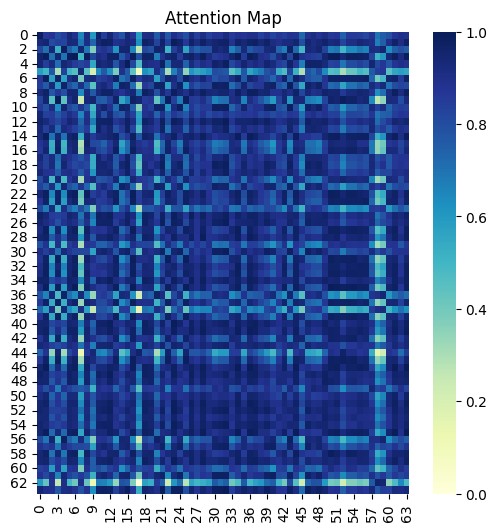

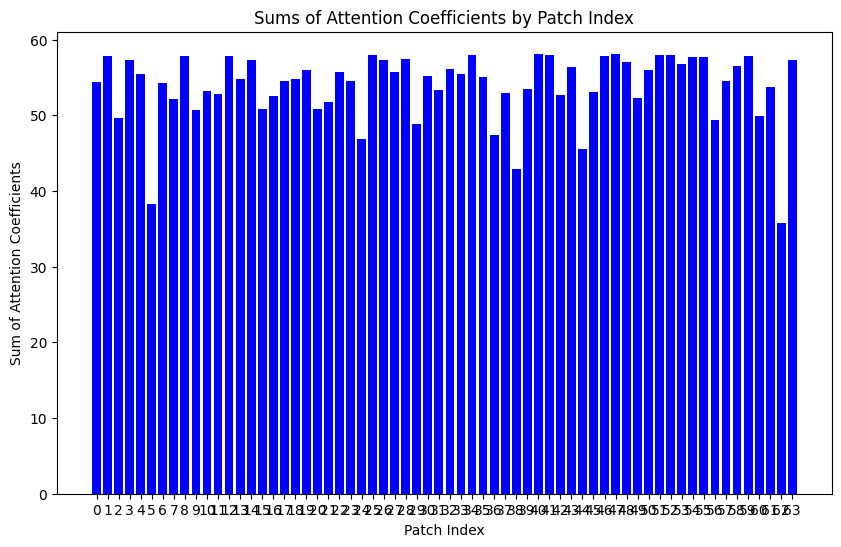

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.800000011920929
Loss: 428.01971435546875


 67%|██████▋   | 20/30 [5:41:04<2:52:09, 1032.93s/it]

Complete 19 th
torch.Size([160, 64, 16])
Row sums: [54.47867  57.766796 49.171074 57.368034 55.587795 37.940903 54.508804
 51.901688 57.791397 50.783825 53.212097 52.790497 57.80308  54.625156
 57.444527 51.130756 52.40531  54.359863 54.64272  55.78875  50.694176
 51.908386 55.85121  54.44228  46.62825  57.939835 57.216736 55.62731
 57.40806  48.98499  55.224804 53.154278 55.99115  55.246765 57.967613
 55.04763  47.143642 52.983078 42.639538 53.824547 58.02835  57.919945
 52.750725 56.36358  45.59072  53.208046 57.68062  58.034008 57.078438
 52.15885  55.789425 57.81826  57.937504 56.785664 57.7213   57.684593
 49.251163 54.382896 56.495518 57.712204 49.887085 53.555664 35.53634
 57.105804]


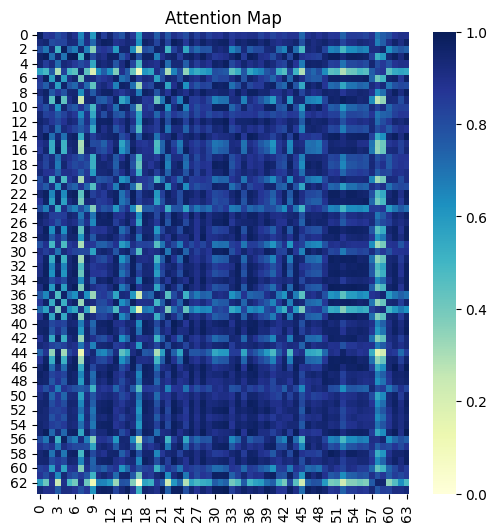

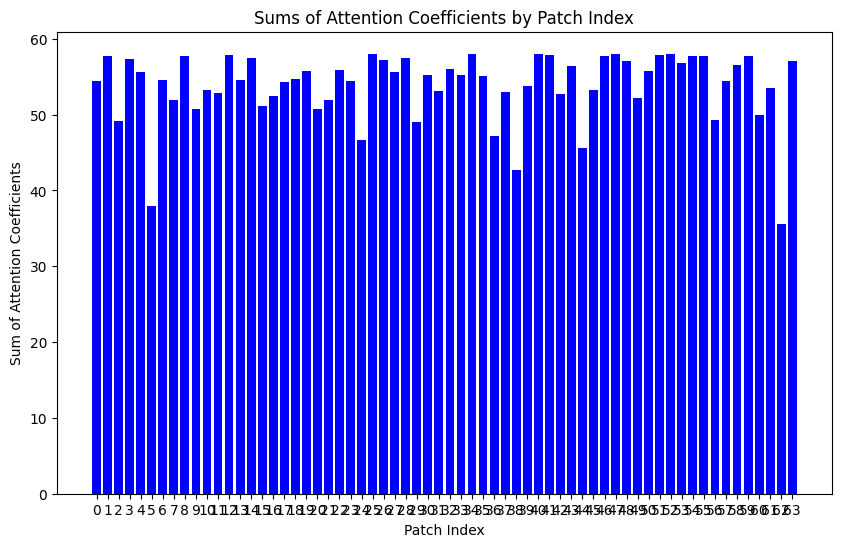

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8062499761581421
Loss: 427.263916015625


 70%|███████   | 21/30 [5:58:13<2:34:44, 1031.66s/it]

Complete 20 th
torch.Size([160, 64, 16])
Row sums: [54.523216 57.6651   48.654682 57.361702 55.700783 37.578545 54.64698
 51.688072 57.690308 50.814903 53.1618   52.697014 57.707825 54.414856
 57.534668 51.441315 52.272923 54.165947 54.47863  55.607376 50.570305
 52.08891  55.96956  54.359188 46.320953 57.913696 57.104046 55.49305
 57.359764 49.07585  55.312748 53.007355 55.85256  55.07286  57.894115
 55.096558 46.9068   53.003143 42.40937  54.114162 57.913643 57.879837
 52.77764  56.284298 45.660744 53.32825  57.550293 57.940193 57.134476
 51.99981  55.612797 57.708626 57.849052 56.722076 57.673653 57.692802
 49.185905 54.245476 56.422424 57.605057 49.876694 53.372726 35.37168
 56.89173 ]


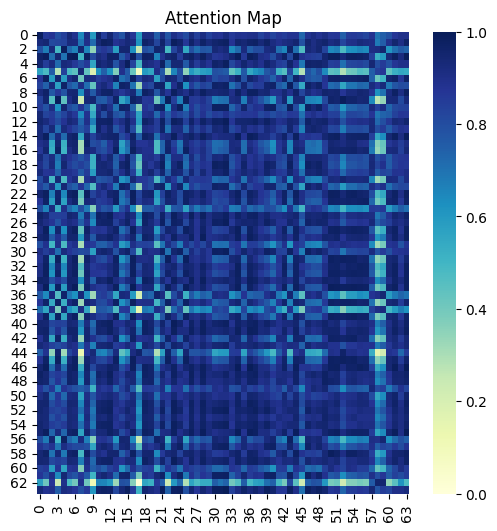

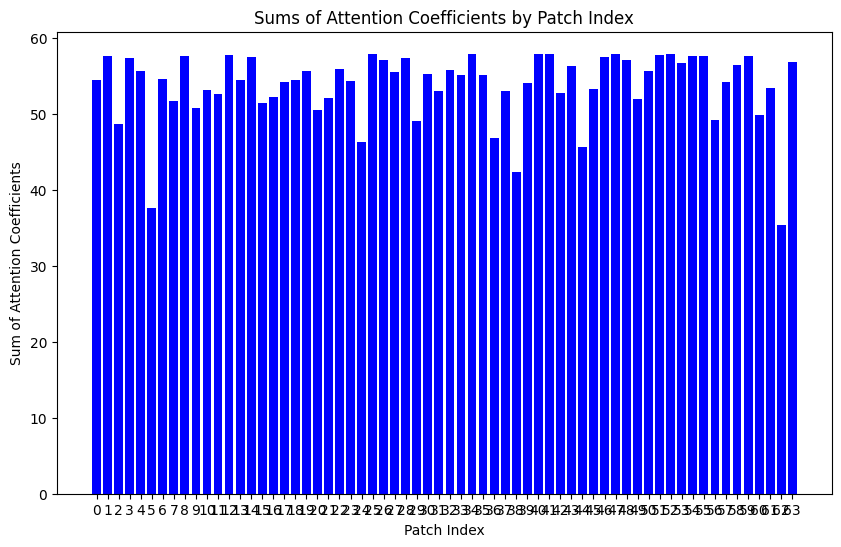

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8374999761581421
Loss: 426.8084716796875


 73%|███████▎  | 22/30 [6:15:39<2:18:07, 1035.88s/it]

Complete 21 th
torch.Size([160, 64, 16])
Row sums: [54.58174  57.57461  48.05256  57.353977 55.796627 37.158188 54.739704
 51.42585  57.595245 50.86934  53.089188 52.57082  57.638058 54.21043
 57.60487  51.76643  52.12676  53.952934 54.316826 55.464783 50.48078
 52.289864 56.09823  54.308296 45.97619  57.889084 56.975143 55.342163
 57.316376 49.17575  55.403168 52.924442 55.74949  54.936394 57.800617
 55.126846 46.55709  53.0255   42.109406 54.411922 57.81347  57.83288
 52.828163 56.204903 45.63893  53.49415  57.421707 57.850227 57.183754
 51.84748  55.44034  57.59191  57.761475 56.659027 57.634922 57.68871
 49.074776 54.134098 56.371037 57.47989  49.87189  53.14347  35.145973
 56.65893 ]


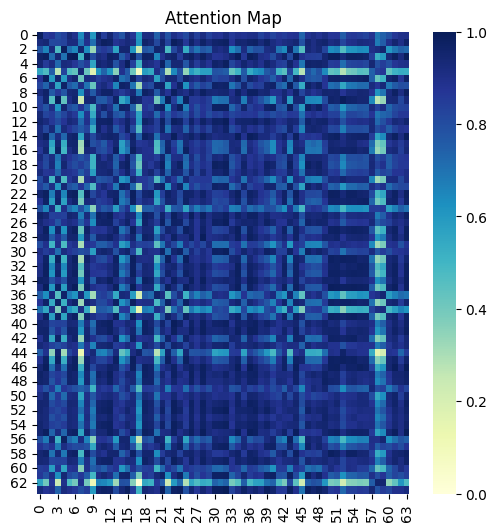

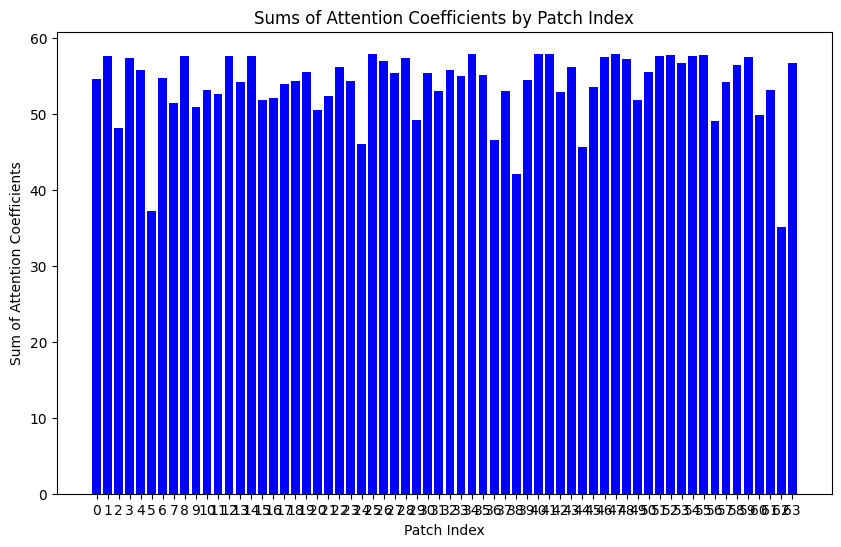

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8187500238418579
Loss: 427.02239990234375


 77%|███████▋  | 23/30 [6:32:56<2:00:54, 1036.34s/it]

Complete 22 th
torch.Size([160, 64, 16])
Row sums: [54.650627 57.50883  47.357613 57.35044  55.89332  36.676807 54.788742
 51.103233 57.518253 50.949024 53.009644 52.403687 57.613506 54.023155
 57.660755 52.117374 51.98333  53.72608  54.150505 55.393272 50.471527
 52.51892  56.240692 54.305397 45.594486 57.874676 56.82769  55.166847
 57.28197  49.27484  55.499283 52.924026 55.699474 54.87999  57.690536
 55.117016 46.04577  53.039635 41.698677 54.73518  57.74903  57.787987
 52.924263 56.13694  45.51622  53.718136 57.31489  57.773056 57.229393
 51.710396 55.27847  57.480858 57.69763  56.60437  57.61248  57.67521
 48.89348  54.076744 56.365227 57.35382  49.854797 52.809364 34.8328
 56.407883]


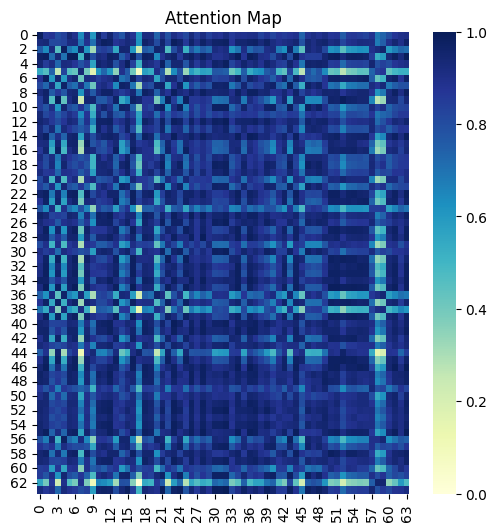

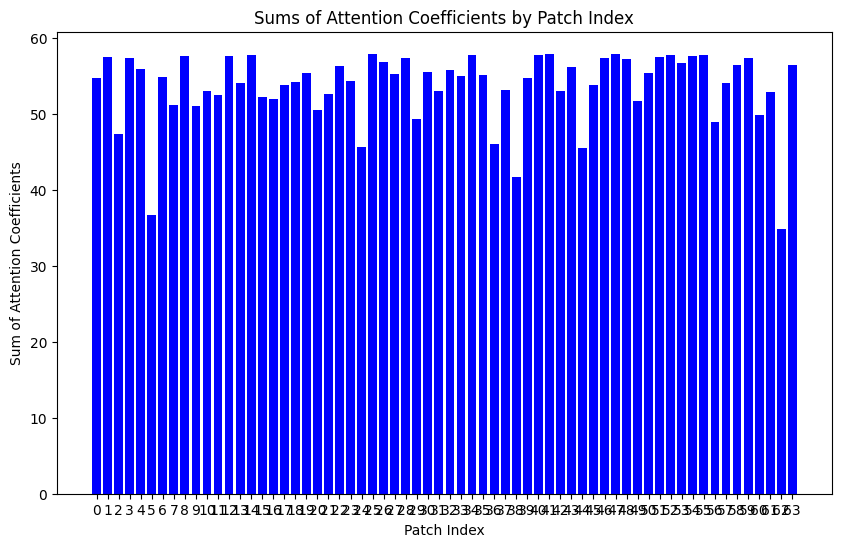

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8187500238418579
Loss: 426.8096008300781


 80%|████████  | 24/30 [6:50:15<1:43:42, 1037.01s/it]

Complete 23 th
torch.Size([160, 64, 16])
Row sums: [54.740616 57.473682 46.59084  57.35991  56.002758 36.158203 54.813103
 50.742397 57.465828 51.057236 52.936615 52.20999  57.630444 53.86183
 57.708717 52.48832  51.85223  53.495125 53.993057 55.38257  50.53434
 52.782394 56.395535 54.350853 45.190937 57.876404 56.6693   54.979904
 57.264538 49.383213 55.611298 53.000626 55.700073 54.899246 57.569393
 55.084    45.422348 53.052868 41.205    55.08307  57.71994  57.756187
 53.06555  56.08767  45.322037 53.99263  57.237152 57.71623  57.282394
 51.59579  55.13295  57.386803 57.665524 56.564987 57.61286  57.66591
 48.666985 54.06625  56.402782 57.24621  49.838173 52.39258  34.461742
 56.145744]


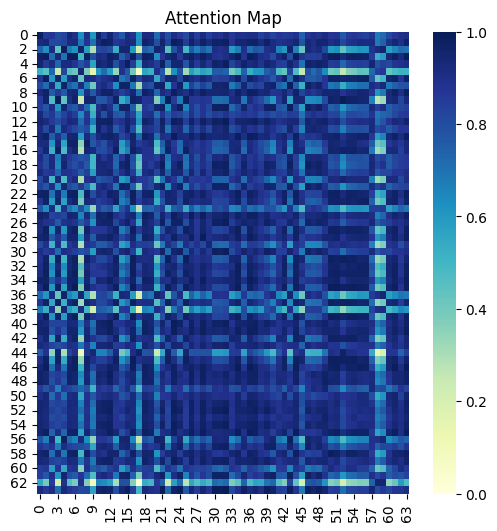

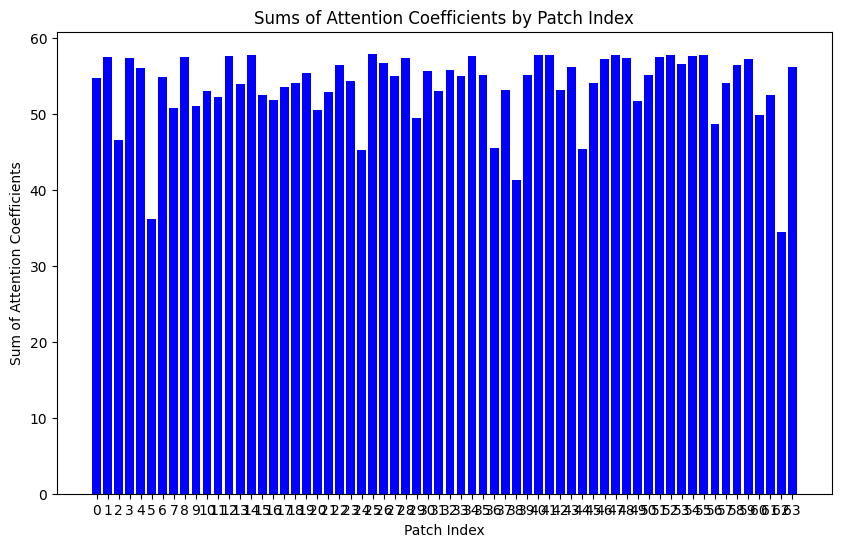

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8374999761581421
Loss: 426.1727600097656


 83%|████████▎ | 25/30 [7:07:33<1:26:27, 1037.42s/it]

Complete 24 th
torch.Size([160, 64, 16])
Row sums: [54.85962  57.467484 45.78882  57.388916 56.12034  35.62818  54.832848
 50.37001  57.434658 51.191517 52.870136 52.00614  57.677387 53.72133
 57.753616 52.858864 51.739132 53.267517 53.864414 55.411606 50.628433
 53.075363 56.555855 54.43184  44.76982  57.892853 56.50808  54.80043
 57.270195 49.519234 55.74299  53.130524 55.736492 54.958763 57.44069
 55.0628   44.75077  53.081604 40.68221  55.4416   57.720665 57.7433
 53.233162 56.05459  45.08622  54.297222 57.177105 57.681324 57.353893
 51.498207 55.002007 57.309822 57.656353 56.54217  57.637836 57.673138
 48.436333 54.0867   56.46315  57.156467 49.846    51.957848 34.074802
 55.883114]


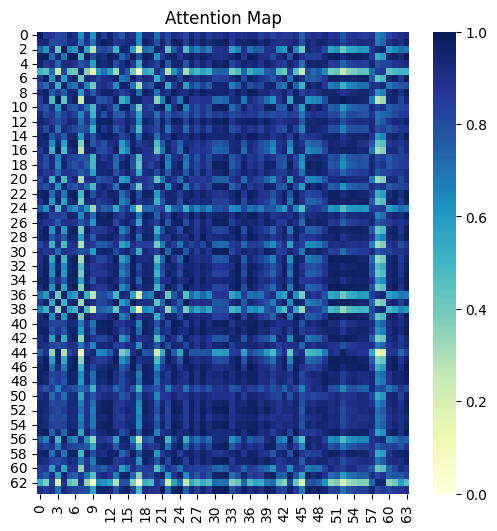

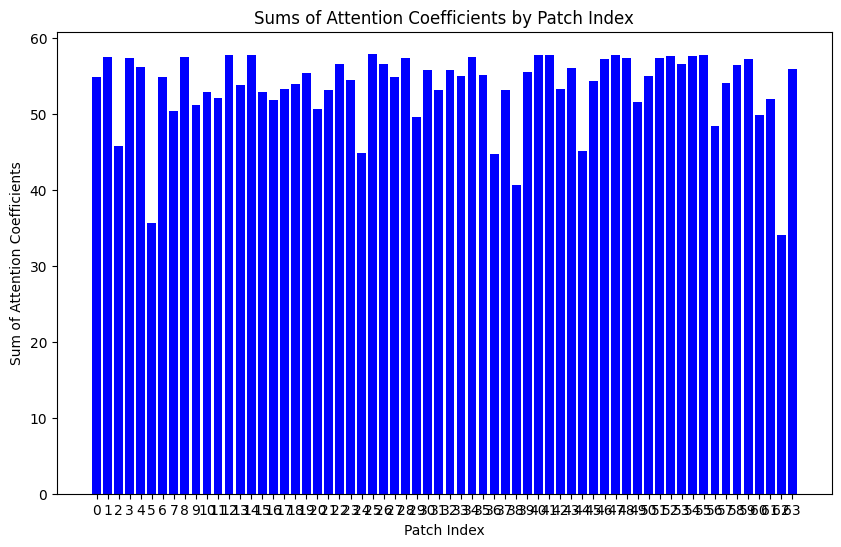

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.824999988079071
Loss: 426.0060729980469


 87%|████████▋ | 26/30 [7:24:43<1:09:01, 1035.34s/it]

Complete 25 th
torch.Size([160, 64, 16])
Row sums: [54.983788 57.457817 45.00746  57.409706 56.209557 35.128304 54.837257
 50.006706 57.387093 51.312214 52.81871  51.787537 57.71333  53.564266
 57.767803 53.179752 51.625046 53.040905 53.765915 55.4325   50.666676
 53.355225 56.68306  54.49539  44.31871  57.89042  56.335865 54.63192
 57.273796 49.673233 55.86723  53.242386 55.7567   54.981438 57.281166
 55.06782  44.125774 53.116886 40.20883  55.763092 57.715782 57.72222
 53.365868 56.010483 44.841934 54.56872  57.092888 57.638542 57.42146
 51.3847   54.84983  57.22     57.628616 56.503674 57.656605 57.67623
 48.253265 54.090576 56.490265 57.046993 49.870293 51.595238 33.732384
 55.621143]


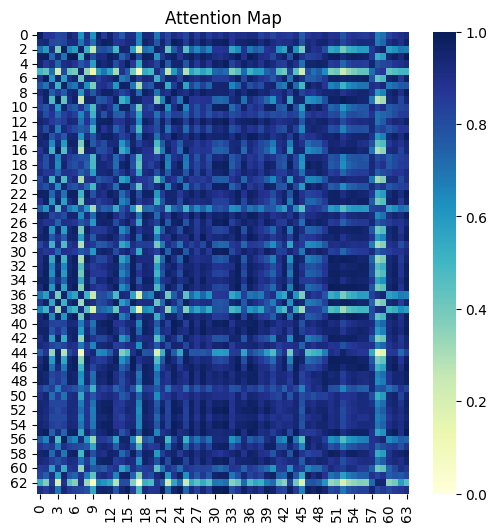

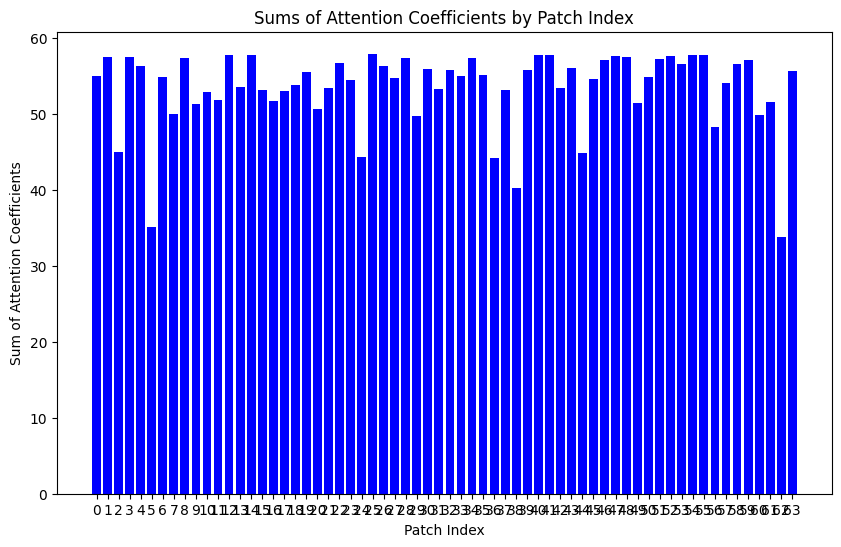

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8125
Loss: 426.052734375


 90%|█████████ | 27/30 [7:41:39<51:28, 1029.41s/it]  

Complete 26 th
torch.Size([160, 64, 16])
Row sums: [55.04875  57.37435  44.255848 57.35266  56.199783 34.669792 54.770493
 49.629257 57.25226  51.3468   52.75323  51.508224 57.664497 53.323093
 57.682724 53.380646 51.45767  52.78208  53.652252 55.370026 50.55928
 53.544285 56.70459  54.45909  43.804047 57.801193 56.10637  54.434227
 57.207733 49.790916 55.916393 53.24238  55.680904 54.877346 57.02773
 55.051025 43.592064 53.10334  39.81653  55.97218  57.633804 57.624725
 53.38298  55.893684 44.598938 54.719303 56.912495 57.519077 57.417282
 51.196033 54.609283 57.05223  57.509808 56.37954  57.598747 57.609295
 48.114517 54.00448  56.406593 56.846066 49.857437 51.31967  33.453312
 55.32866 ]


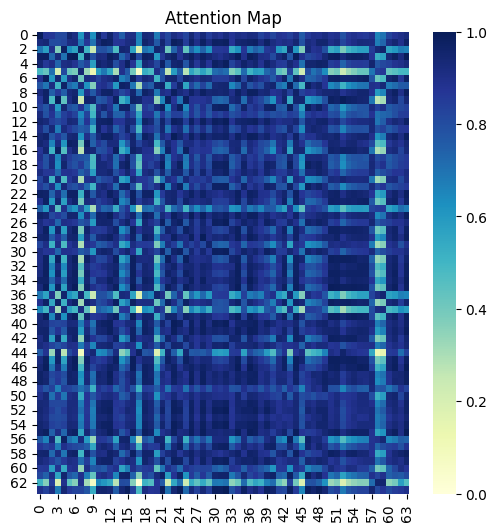

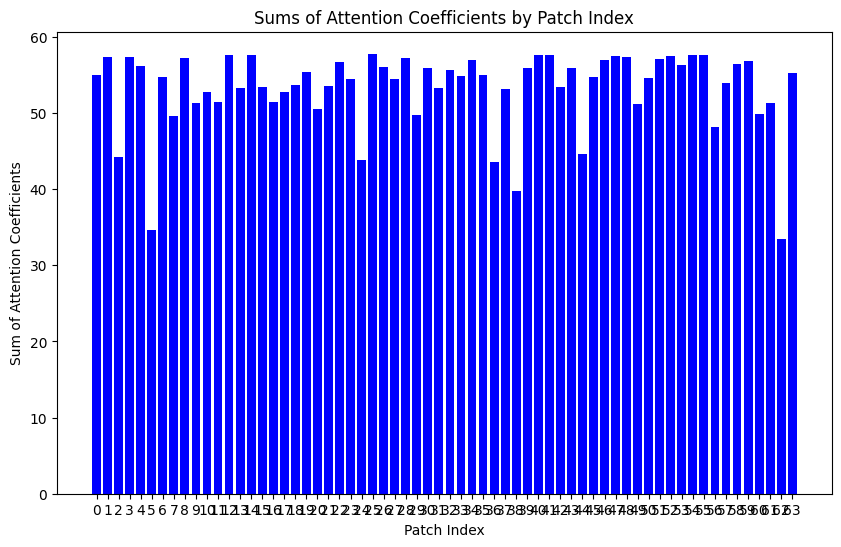

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8187500238418579
Loss: 425.7816162109375


 93%|█████████▎| 28/30 [7:58:30<34:07, 1023.83s/it]

Complete 27 th
torch.Size([160, 64, 16])
Row sums: [55.133797 57.30601  43.59255  57.306877 56.180374 34.294727 54.718857
 49.309868 57.12133  51.37686  52.746513 51.24707  57.623108 53.08365
 57.5891   53.550262 51.317226 52.566284 53.597115 55.31298  50.40687
 53.724953 56.709232 54.41405  43.297382 57.71868  55.90226  54.287777
 57.159145 49.94604  55.974285 53.222843 55.602352 54.74382  56.770264
 55.085052 43.193966 53.120308 39.54557  56.162556 57.565796 57.539722
 53.378204 55.79144  44.412582 54.844166 56.72733  57.411373 57.427837
 51.013374 54.365517 56.896545 57.391083 56.258377 57.553505 57.558784
 48.07425  53.91845  56.307644 56.640427 49.87974  51.178265 33.272003
 55.091404]


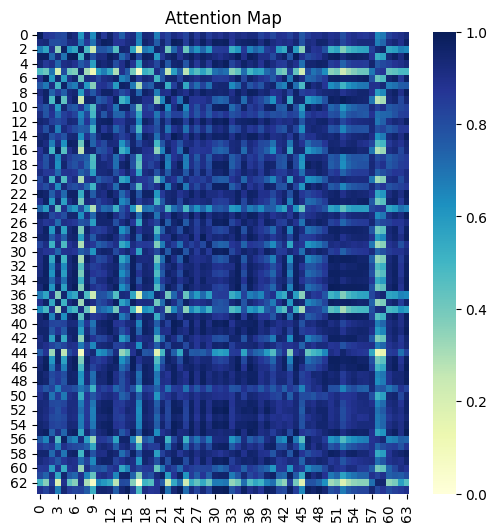

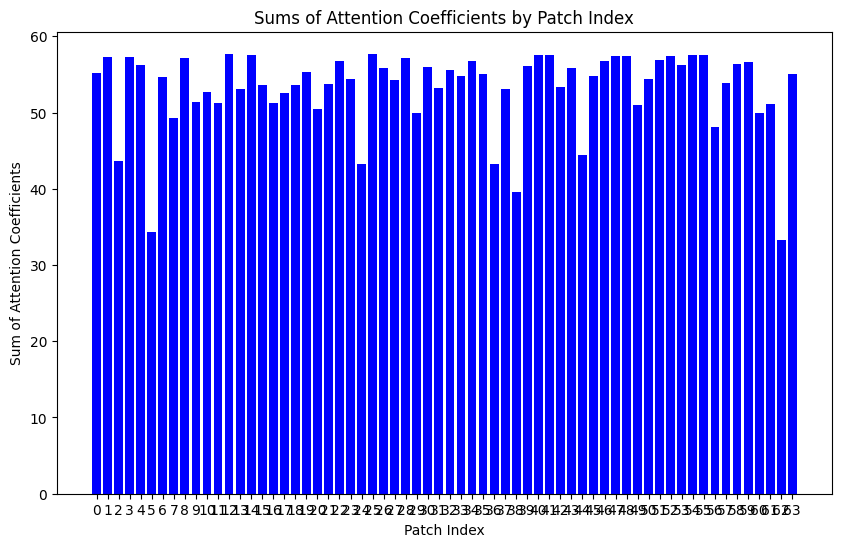

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.84375
Loss: 425.31976318359375


 97%|█████████▋| 29/30 [8:15:31<17:02, 1022.93s/it]

Complete 28 th
torch.Size([160, 64, 16])
Row sums: [55.220016 57.24541  42.931206 57.26558  56.15407  33.9286   54.669495
 48.994144 56.99009  51.406982 52.749817 50.97818  57.587227 52.84506
 57.483128 53.692406 51.18853  52.34249  53.56094  55.2647   50.246338
 53.90412  56.69076  54.374855 42.77861  57.636635 55.68464  54.155865
 57.117195 50.121864 56.030304 53.211388 55.53031  54.604492 56.50366
 55.1365   42.79963  53.1492   39.28426  56.3424   57.507576 57.45759
 53.369354 55.690895 44.210983 54.967148 56.53855  57.305573 57.440735
 50.82325  54.112663 56.744255 57.268883 56.135376 57.5139   57.51051
 48.052338 53.836464 56.20241  56.427788 49.914516 51.05282  33.105778
 54.85856 ]


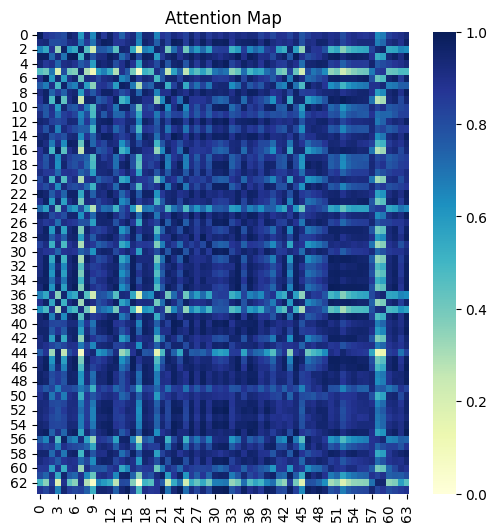

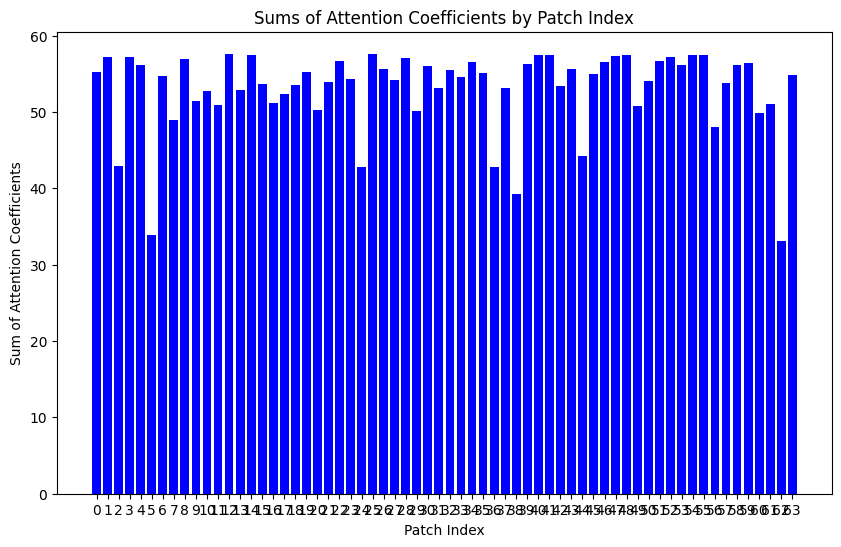

/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8687499761581421
Loss: 425.1431579589844


100%|██████████| 30/30 [8:32:42<00:00, 1025.42s/it]

Complete 29 th
Model parameters saved.


In [15]:
# Training the model
for iepoch in tqdm(range(30)):
    optimizer.zero_grad()
    X_tensor = torch.tensor(X_train)
    predictions = model(X_tensor.float()).squeeze(1)
    
    label = torch.tensor(y_train)
    for i in range(len(label)):
        label[i] = 0 if label[i] == 1 else 1
    
    loss = criterion(predictions, label.float())
    acc = binary_accuracy(predictions, label)
    print(f'Accuracy: {acc}')
    print(f'Loss: {loss}')
    
    loss.backward()
    optimizer.step()
    print(f"Complete {iepoch} th")

# Save the model parameters
torch.save(model.state_dict(), model_save_path)
print("Model parameters saved.")

torch.Size([40, 64, 16])
Row sums: [53.238518 56.835125 44.787247 56.754562 55.86565  35.01068  53.98958
 48.583405 55.551266 51.758812 53.163292 48.529133 57.537743 50.350628
 57.134598 54.006523 51.169857 51.003723 52.920868 55.07265  48.79082
 53.261158 56.769855 53.28085  37.676384 57.042423 54.763695 54.334
 56.997215 44.168983 55.35521  52.52855  55.104446 53.497772 55.62606
 54.40342  40.92691  52.17289  36.102295 55.427097 56.505615 56.994495
 53.36472  55.47985  42.105324 54.578156 55.714516 57.040405 56.851753
 49.59002  53.074974 55.556896 56.93045  54.128975 57.224037 56.94049
 45.516014 52.543636 55.210308 55.16828  47.156654 50.291824 31.040272
 53.84308 ]


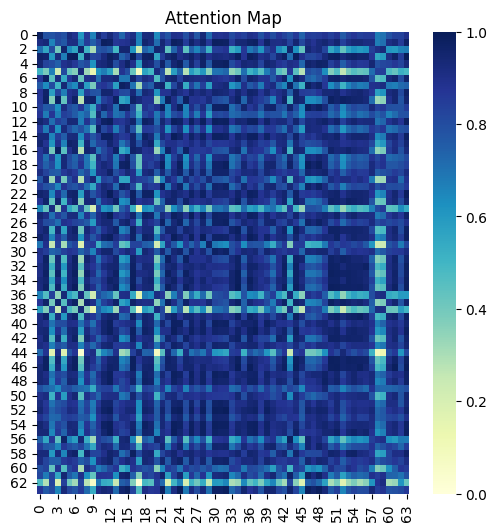

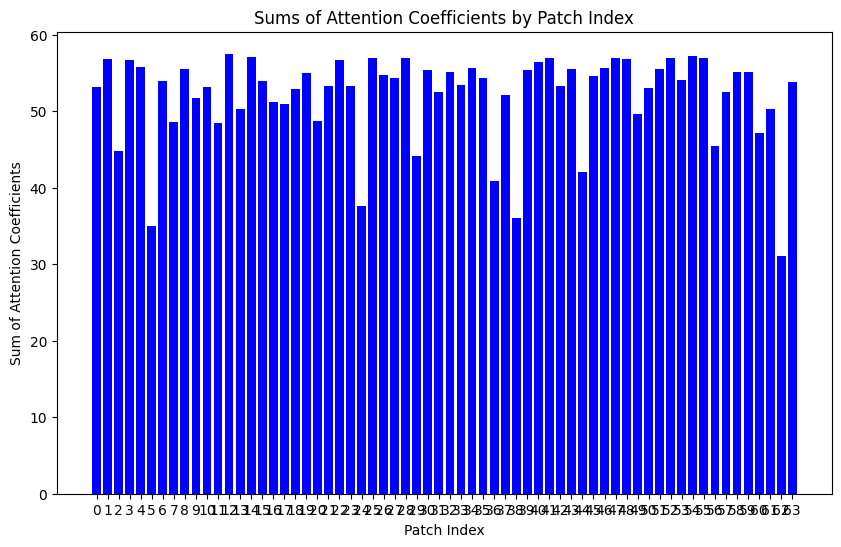


Accuracy: 0.800000011920929

Loss: 45.4970817565918

AUROC: 0.8233618233618234



/tmp/ipykernel_196803/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [16]:
from sklearn.metrics import roc_auc_score

X_tensor=torch.tensor(X_test)
predictions=model(X_tensor.float()).squeeze(1)
label=torch.tensor(y_test)
for i in range(len(label)):
        if label[i]==1:
            label[i] = 0
        else:
            label[i]=1
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Calculate AUROC
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy
auroc = roc_auc_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')

In [47]:
# # Now load the model and make predictions on a single data sample
# # Create a new instance of the model and load the saved parameters
# loaded_model = QSANN_text_classifier(4, 4, 2, 1, 1)
# loaded_model.load_state_dict(torch.load(model_save_path))
# loaded_model.eval()
# print("Model loaded and ready for inference.")


In [17]:
# Select a single sample from the test set
single_sample = torch.tensor(X_test[0:1].astype(np.float32))  # Select one sample


In [18]:
# # Make a prediction for the single sample
# with torch.no_grad():
#     prediction = loaded_model(single_sample).squeeze()
#     predicted_class = (torch.round(torch.sigmoid(prediction))).item()
#     print(f"Predicted class for the sample: {predicted_class}")


In [19]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [21]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(64, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=1, bias=True)
)

Row sums: [52.28139  58.26519  59.730656 59.78482  59.87954  51.14838  54.475243
 56.740086 55.46488  58.18969  59.810112 52.82191  59.83024  54.51921
 59.290005 59.989555 59.957214 59.824074 59.587708 59.97948  58.54518
 55.82173  59.922485 59.14068  39.69468  59.65975  59.296555 57.221107
 59.80369  36.480026 59.508423 59.033108 59.043102 54.645382 54.852642
 55.897186 57.47369  56.09166  45.88812  59.841217 59.964737 59.985695
 53.878967 59.72022  46.583298 57.55161  56.86029  59.685925 59.984303
 59.452507 59.899452 58.757248 59.987038 59.260075 59.907455 59.988945
 55.723164 59.807953 59.192093 59.63375  58.071526 58.702156 30.84991
 57.907112]


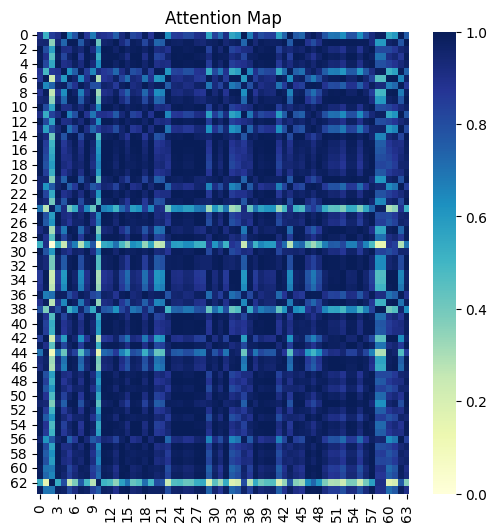

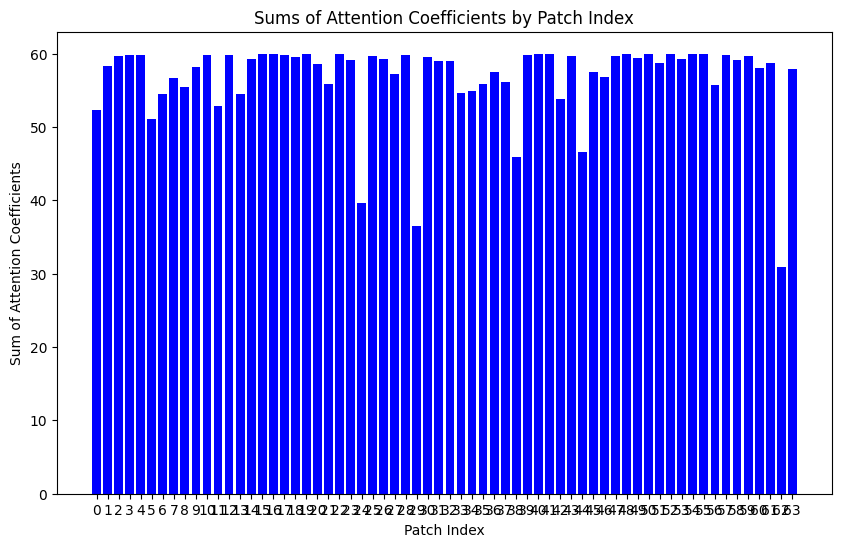

Predicted class for the sample: 1.0
Row sums: [52.28139  58.26519  59.730656 59.78482  59.87954  51.14838  54.475243
 56.740086 55.46488  58.18969  59.810112 52.82191  59.83024  54.51921
 59.290005 59.989555 59.957214 59.824074 59.587708 59.97948  58.54518
 55.82173  59.922485 59.14068  39.69468  59.65975  59.296555 57.221107
 59.80369  36.480026 59.508423 59.033108 59.043102 54.645382 54.852642
 55.897186 57.47369  56.09166  45.88812  59.841217 59.964737 59.985695
 53.878967 59.72022  46.583298 57.55161  56.86029  59.685925 59.984303
 59.452507 59.899452 58.757248 59.987038 59.260075 59.907455 59.988945
 55.723164 59.807953 59.192093 59.63375  58.071526 58.702156 30.84991
 57.907112]


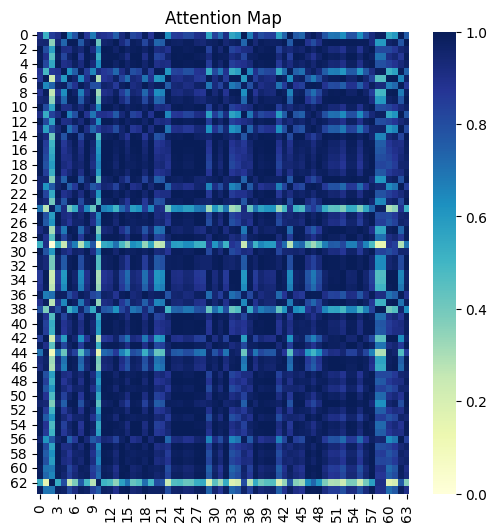

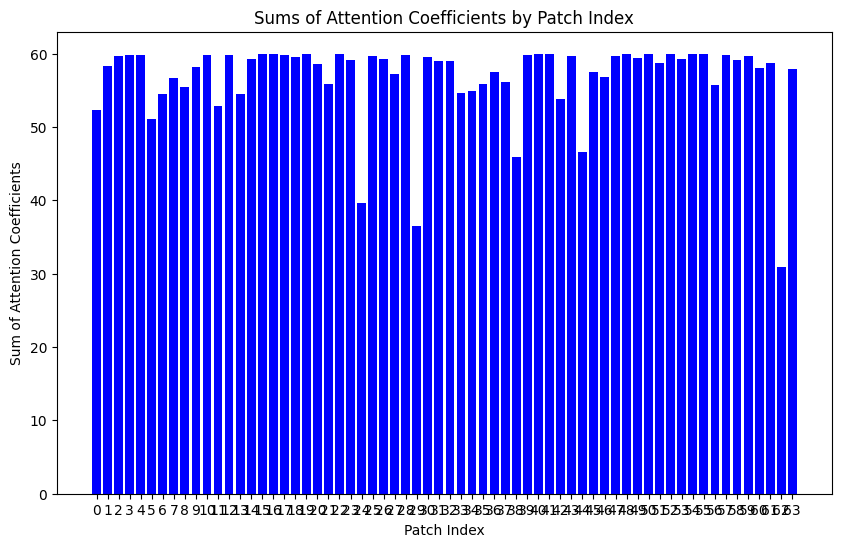

Extracted attention values: tensor([[[0.9123, 0.5836, 0.8671,  ..., 0.6553, 0.9958, 0.7942],
         [0.9506, 0.9585, 0.4404,  ..., 0.9852, 0.8068, 0.9977],
         [1.0000, 0.8264, 0.6342,  ..., 0.8829, 0.9474, 0.9671],
         ...,
         [0.9927, 0.7659, 0.7018,  ..., 0.8293, 0.9769, 0.9334],
         [0.5954, 0.2658, 0.9984,  ..., 0.3201, 0.7928, 0.4471],
         [0.9845, 0.7340, 0.7346,  ..., 0.8000, 0.9873, 0.9127]]])


In [22]:
# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    prediction = attention_model(single_sample).squeeze()
    predicted_class = (torch.round(torch.sigmoid(prediction))).item()
    print(f"Predicted class for the sample: {predicted_class}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

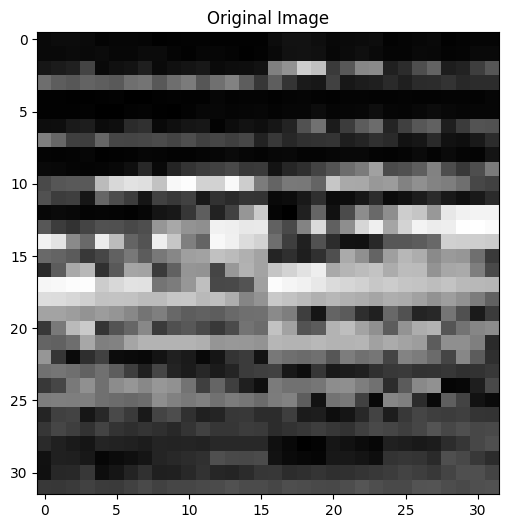

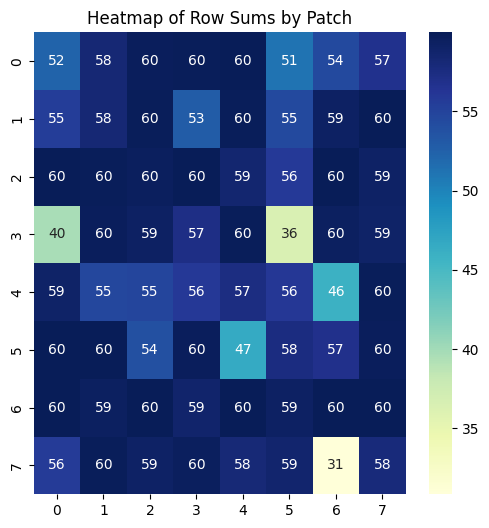

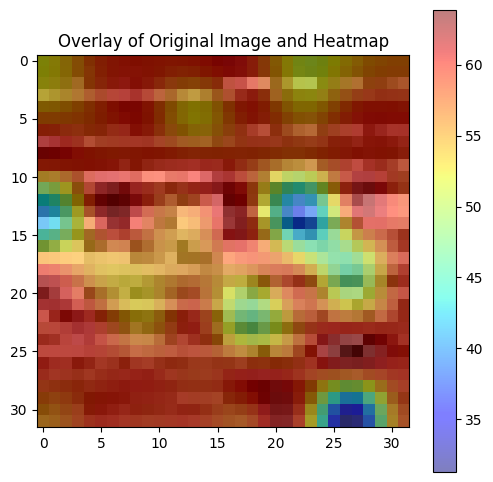

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(8, 8)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.5, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(X_test[0:1].astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = single_sample.squeeze().reshape(32, 32).numpy()  # Reshape to 2D

# Example row sums based on output
row_sums =[52.28139, 58.26519, 59.730656, 59.78482, 59.87954, 51.14838, 54.475243, 56.740086, 55.46488, 58.18969, 59.810112, 52.82191, 59.83024, 54.51921, 59.290005, 59.989555, 59.957214, 59.824074, 59.587708, 59.97948, 58.54518, 55.82173, 59.922485, 59.14068, 39.69468, 59.65975, 59.296555, 57.221107, 59.80369, 36.480026, 59.508423, 59.033108, 59.043102, 54.645382, 54.852642, 55.897186, 57.47369, 56.09166, 45.88812, 59.841217, 59.964737, 59.985695, 53.878967, 59.72022, 46.583298, 57.55161, 56.86029, 59.685925, 59.984303, 59.452507, 59.899452, 58.757248, 59.987038, 59.260075, 59.907455, 59.988945, 55.723164, 59.807953, 59.192093, 59.63375, 58.071526, 58.702156, 30.84991, 57.907112]


# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image, row_sums, patch_shape=(8, 8))


Row sums: [52.28139  58.26519  59.730656 59.78482  59.87954  51.14838  54.475243
 56.740086 55.46488  58.18969  59.810112 52.82191  59.83024  54.51921
 59.290005 59.989555 59.957214 59.824074 59.587708 59.97948  58.54518
 55.82173  59.922485 59.14068  39.69468  59.65975  59.296555 57.221107
 59.80369  36.480026 59.508423 59.033108 59.043102 54.645382 54.852642
 55.897186 57.47369  56.09166  45.88812  59.841217 59.964737 59.985695
 53.878967 59.72022  46.583298 57.55161  56.86029  59.685925 59.984303
 59.452507 59.899452 58.757248 59.987038 59.260075 59.907455 59.988945
 55.723164 59.807953 59.192093 59.63375  58.071526 58.702156 30.84991
 57.907112]


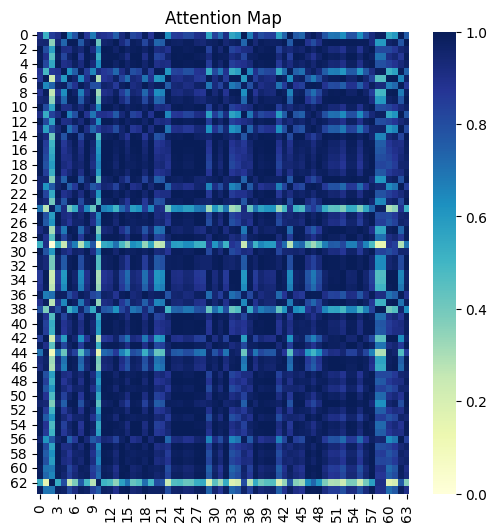

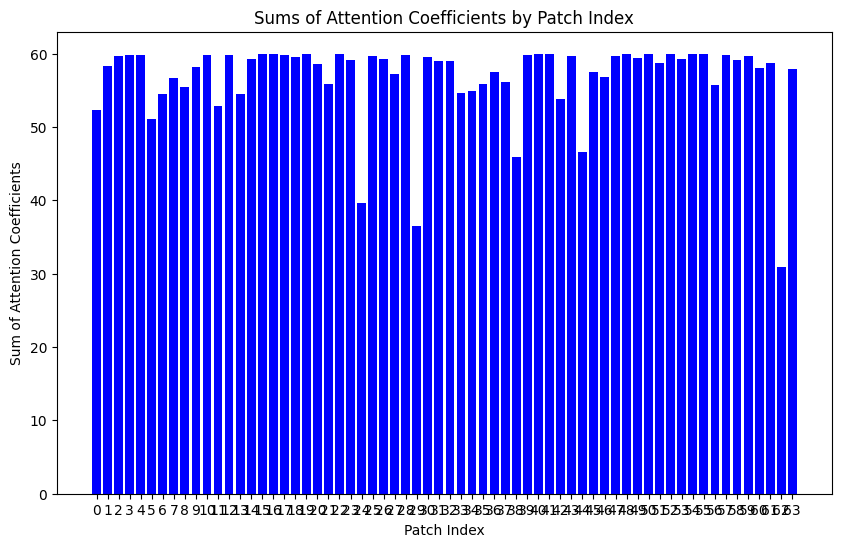

Predicted class for sample 0: 1.0
Row sums: [57.655266 59.897717 59.47858  60.19364  58.5688   54.840046 59.28881
 56.96044  56.22058  58.642624 60.4022   54.477463 60.461884 43.97143
 60.34604  60.513622 59.98507  60.07464  59.382248 60.402245 55.794662
 59.97525  59.6699   60.05278  21.810362 59.318947 60.485695 60.54088
 59.209984 54.71806  60.177193 56.250656 59.513638 60.368904 60.543736
 60.167725 53.5248   56.165085 53.47815  57.122375 60.39283  60.52349
 52.001587 51.013367 51.72072  58.66239  54.88806  60.20608  60.481907
 50.82067  59.800083 59.696533 59.47328  60.357536 60.061802 60.38002
 58.261475 60.537865 58.334084 59.708164 58.39061  58.014687 32.35836
 58.143936]


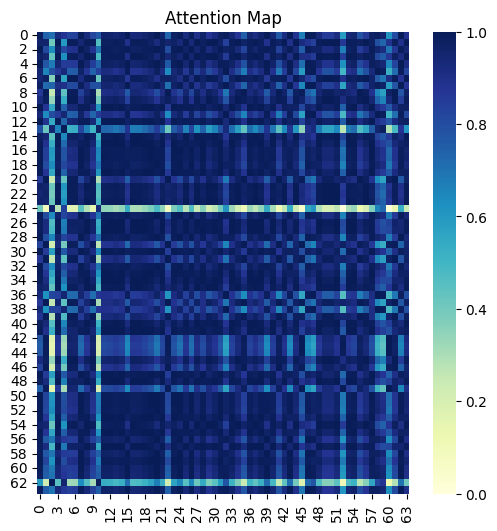

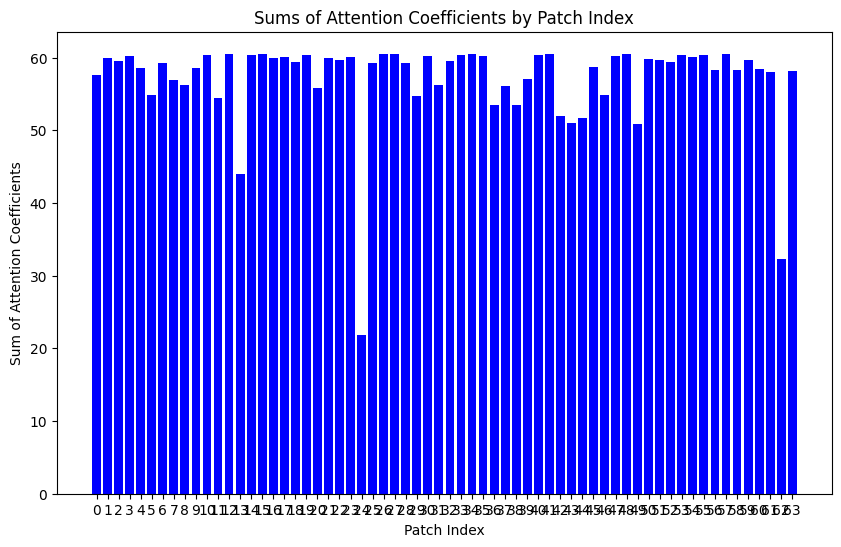

Predicted class for sample 1: 1.0
Row sums: [57.42398  58.871765 51.621906 58.536644 58.65618  30.140003 59.60694
 53.54882  59.507523 59.042057 52.925884 58.771572 59.226944 59.01786
 59.53851  57.93644  51.395767 59.687016 54.697533 59.681946 56.90316
 56.078793 58.631115 59.4104   51.600117 59.69763  53.0616   59.077408
 58.720955 52.645554 54.945534 59.24897  59.702805 58.411926 59.080605
 58.133373 38.120575 56.279015 41.584007 59.15922  58.81332  59.233368
 59.108444 59.39897  50.38515  58.971806 58.982727 59.22724  56.99227
 48.34861  53.016586 51.415108 57.100685 58.75403  59.410965 59.6582
 52.19001  51.085228 56.478092 57.291405 45.612534 56.32659  31.832165
 56.653534]


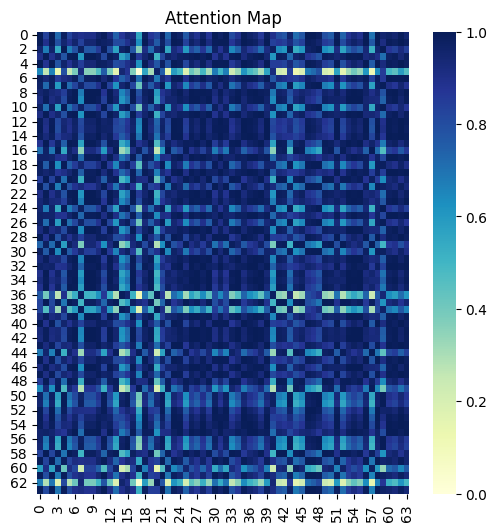

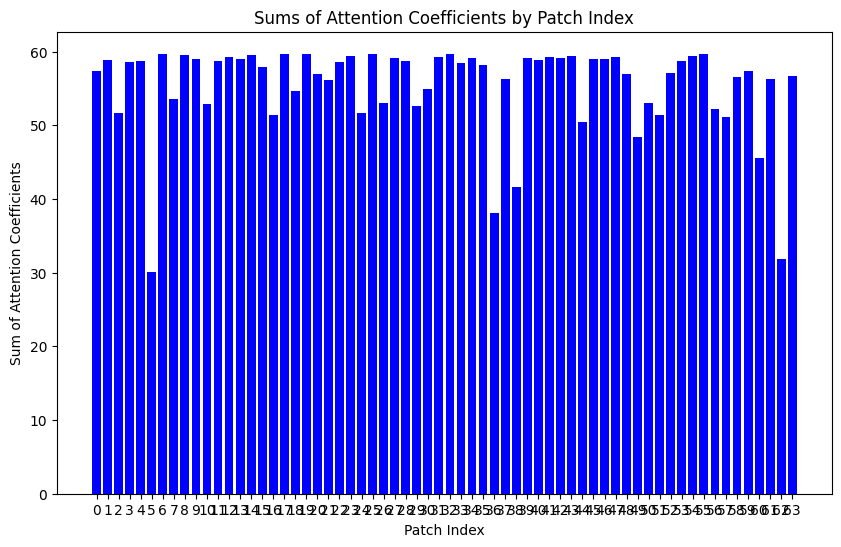

Predicted class for sample 2: 1.0
Row sums: [55.407436 59.47548  53.85733  60.12552  57.348465 52.801743 52.034218
 57.951878 55.2215   53.6901   59.576473 55.362823 59.82648  52.68264
 59.260933 60.1399   59.088997 54.107887 58.255108 60.144768 48.80348
 60.09318  59.982082 55.046066 24.847706 60.00949  55.610504 58.67453
 59.965626 42.951904 60.143806 58.286896 60.05175  55.598373 58.48547
 57.7014   56.320915 55.177387 45.266056 58.64969  60.142586 59.66514
 59.721916 60.08443  51.3282   58.528603 55.66865  60.11857  60.126713
 56.174774 59.55085  59.879776 59.951992 58.995197 60.145054 60.093227
 50.285103 60.12388  60.04859  59.81031  57.52056  55.555294 55.080402
 58.775482]


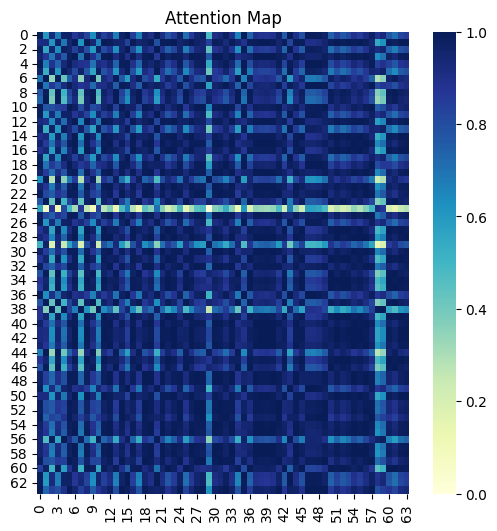

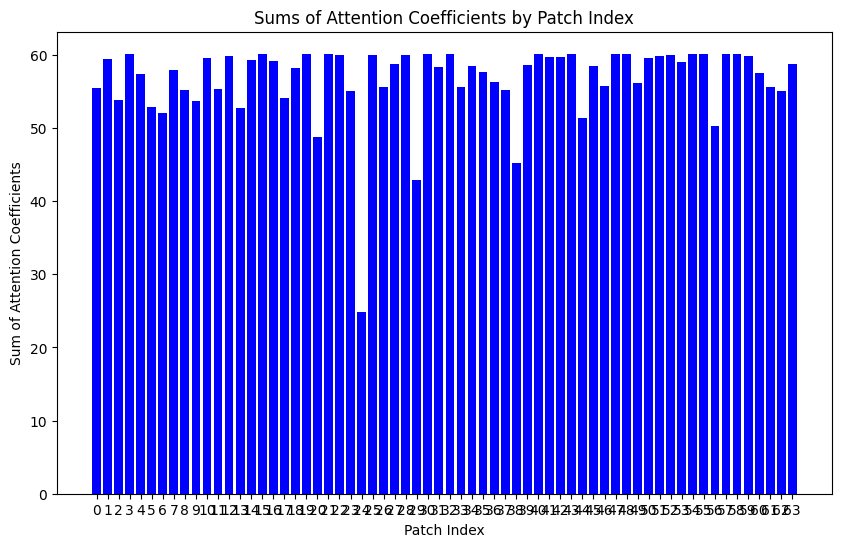

Predicted class for sample 3: 1.0
Row sums: [59.620705 59.01322  46.534317 59.482388 56.156296 50.35636  54.677692
 56.360992 58.36767  57.728146 58.683968 58.839184 59.367943 59.68769
 59.65171  59.419193 58.496323 58.704346 55.281372 59.726425 58.226585
 58.596153 59.701805 57.35697  41.43151  58.991062 57.84506  56.709515
 58.604115 58.810837 59.356934 57.4552   56.85883  55.929405 56.217766
 54.966286 58.70046  53.78401  39.45301  59.731537 59.61808  59.433327
 55.366417 57.23069  49.315582 59.293922 58.508263 59.515545 59.661583
 58.694885 58.927155 59.602207 59.68576  58.49635  59.737    59.723892
 54.08436  59.684864 58.25102  58.153683 57.103863 59.185905 27.852701
 57.57328 ]


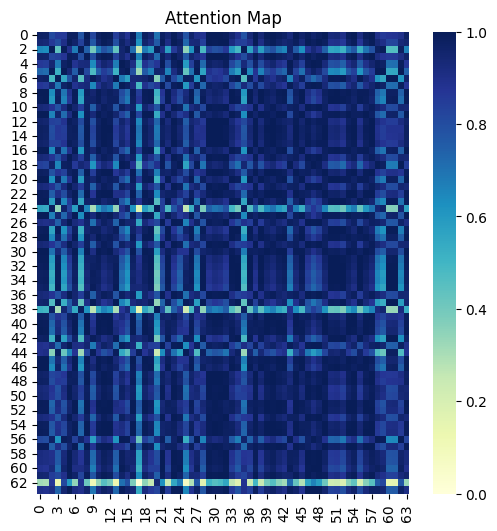

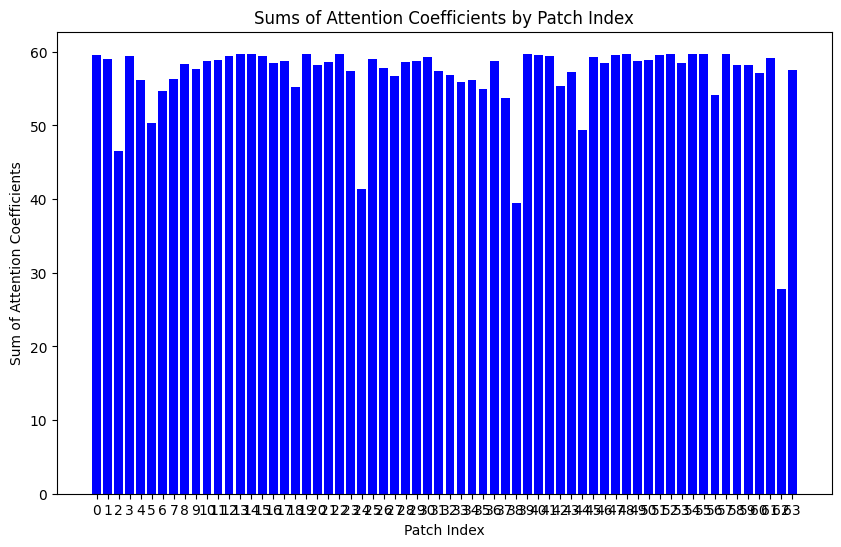

Predicted class for sample 4: 1.0
Row sums: [57.64348  59.212173 47.4908   59.35574  54.74213  42.196693 52.504097
 51.84989  59.21496  54.608147 57.619377 58.224976 59.304283 56.09469
 59.352036 59.22451  51.144913 53.02833  54.663677 56.219364 48.154526
 55.03117  59.356316 53.17597  57.582253 58.661118 58.507523 53.635628
 59.238567 38.13078  56.88085  57.7284   58.233955 56.56311  57.917114
 57.43625  45.089516 53.628834 40.560665 57.42969  59.286095 58.056007
 58.773056 59.100323 55.380672 51.105087 59.358543 59.33055  58.89612
 50.698402 56.15377  56.346054 58.43178  59.233265 58.18599  58.892567
 53.603996 56.132908 58.85746  47.85384  41.19606  51.159473 55.813572
 57.379814]


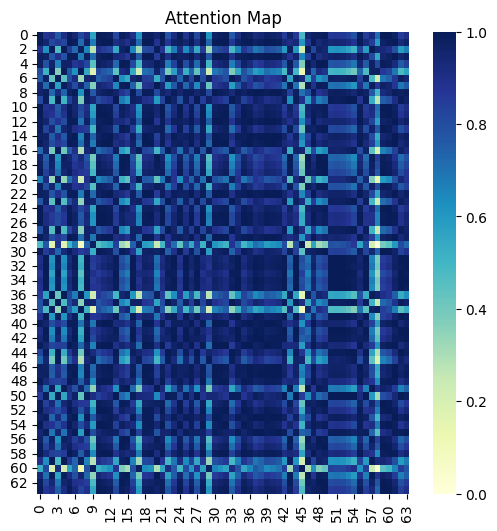

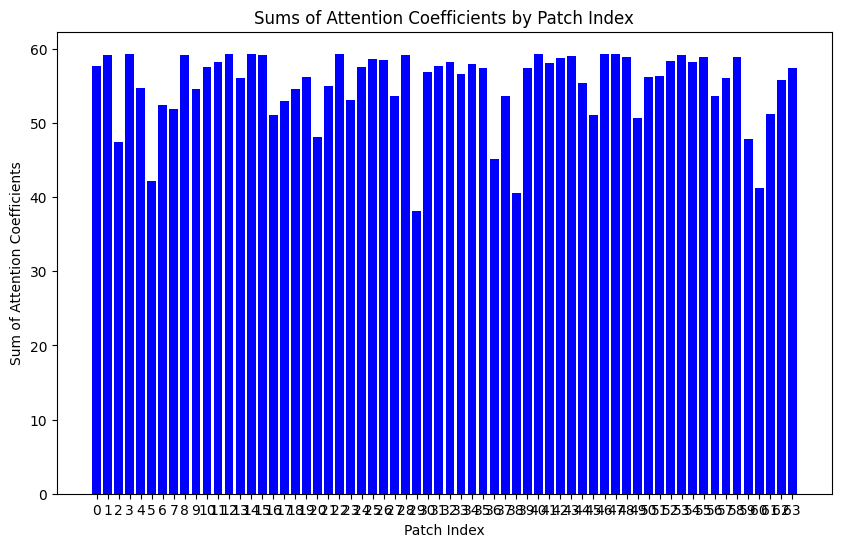

Predicted class for sample 5: 1.0
Row sums: [57.168663 58.817543 47.092472 58.81965  56.510315 54.96902  53.48687
 54.903    58.5803   50.155518 56.10992  50.362343 58.77965  56.85428
 58.790424 58.65243  48.41562  51.520935 55.204952 57.622726 58.830738
 54.81047  58.86596  51.807568 54.062737 58.64427  55.719074 55.59011
 58.00036  58.78507  58.824684 56.4278   58.49407  56.44324  55.78552
 56.863426 54.253952 52.581566 46.94091  58.37698  58.155685 58.79151
 49.608967 56.924995 49.105434 56.56256  58.19371  58.853966 57.720367
 56.720543 58.7273   57.38974  57.995644 58.830093 58.66355  58.307632
 44.41358  50.88127  55.14115  58.65224  42.624504 52.552265 40.755447
 57.28248 ]


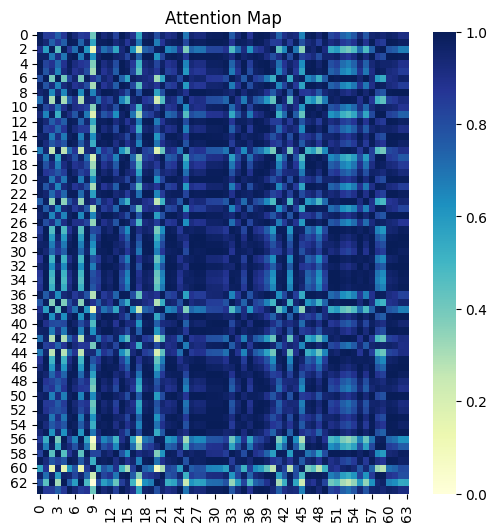

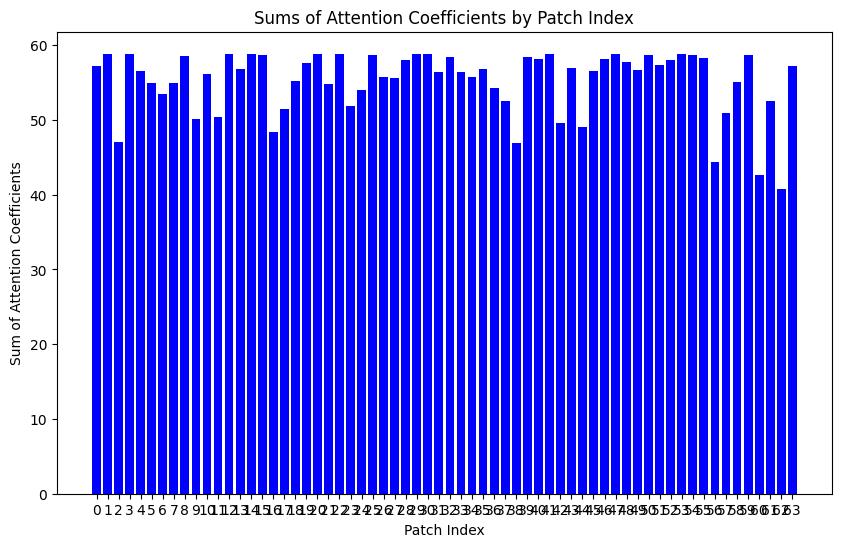

Predicted class for sample 6: 1.0
Row sums: [52.474648 59.723526 59.8909   60.61705  59.49926  55.87067  56.969383
 58.293953 56.51883  56.213383 59.90763  45.392807 60.409676 47.71456
 60.05736  60.670464 60.469925 58.59075  59.518337 59.955944 56.49534
 60.59544  60.666046 57.221035 22.56595  58.642513 59.819824 57.62926
 60.64389  37.878857 54.36136  57.469284 59.874893 60.468235 58.24858
 60.691624 54.7725   55.98166  55.9814   60.129032 60.17807  59.528275
 60.60005  60.023853 52.49167  59.589058 59.507355 60.56902  60.589935
 58.008972 60.26954  54.280556 60.451942 58.72207  60.43937  60.679432
 49.64878  54.983772 56.73913  59.80325  45.526306 54.088158 53.560364
 58.88739 ]


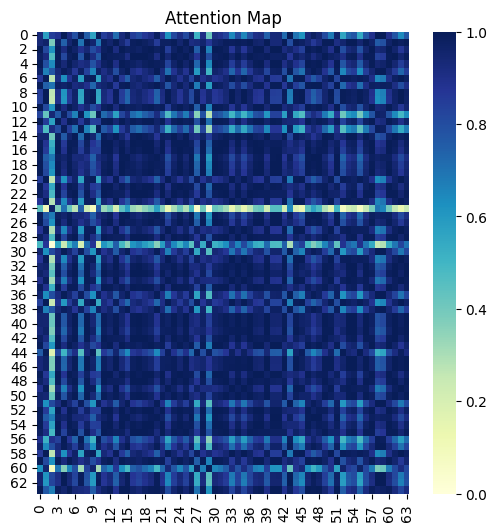

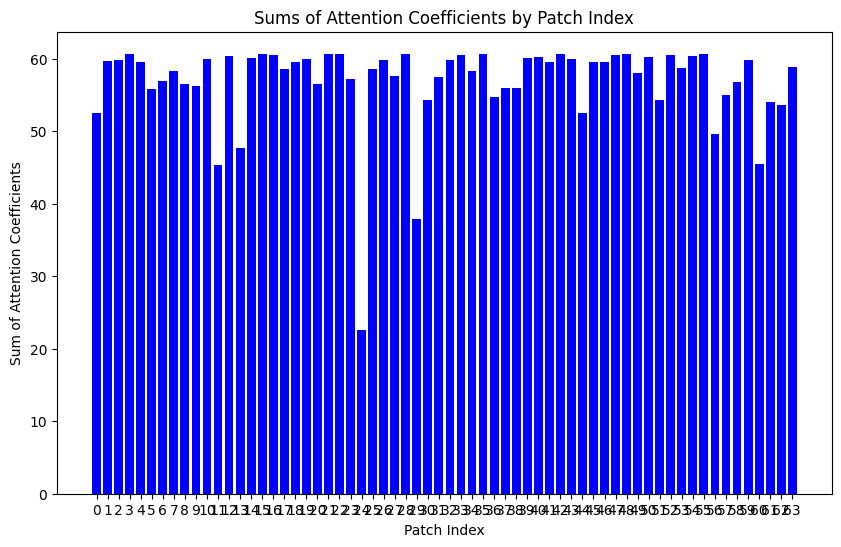

Predicted class for sample 7: 1.0
Row sums: [55.9741   59.978813 46.96032  58.127365 59.953854 37.971992 55.491108
 55.565254 59.903564 58.677616 55.65498  59.18421  59.983055 56.11343
 59.873108 59.93577  59.04361  55.68218  59.062363 55.071495 52.826523
 59.565018 59.253773 54.82357  57.138218 59.96499  57.61988  51.130596
 57.457695 59.053055 50.209885 56.835457 57.289066 57.057228 53.450375
 55.54982  53.614407 57.972214 38.311325 55.091095 59.986813 58.96209
 59.967224 55.36276  45.98087  56.907383 54.243797 60.000572 59.98513
 48.531998 51.675896 59.996864 59.78145  60.00093  59.92231  59.62034
 54.453922 59.72216  58.478146 59.211193 58.913364 58.915    23.203438
 58.300926]


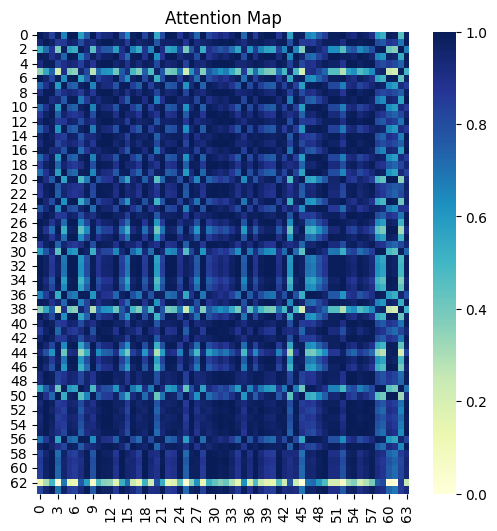

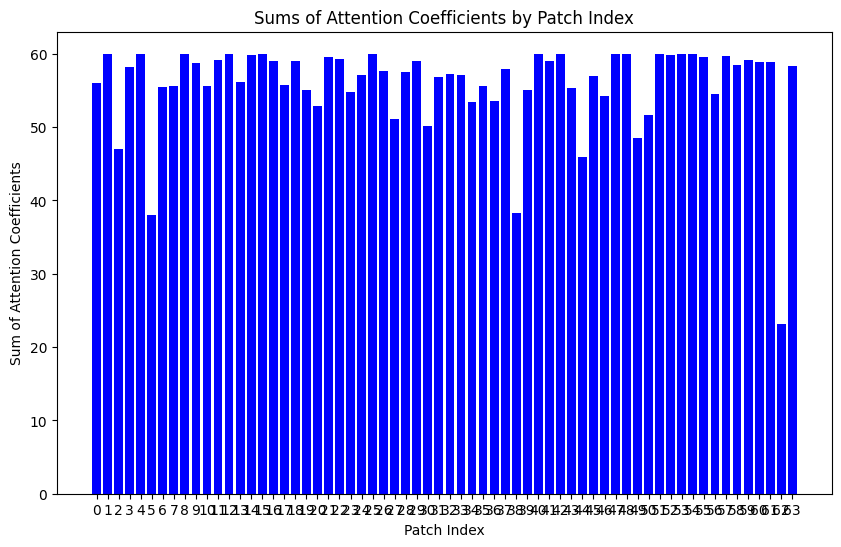

Predicted class for sample 8: 1.0
Row sums: [55.72959  57.87079  51.311584 57.21975  58.66004  36.534405 58.653263
 50.547962 58.54353  55.50936  54.27487  54.99956  58.457825 58.584145
 57.550507 47.58091  55.209976 58.46907  54.547096 58.16384  56.22017
 57.493073 56.49914  58.676773 58.111526 58.67836  56.827694 55.68673
 57.50669  55.594284 58.470287 58.195496 58.68224  56.43302  57.870014
 55.393543 57.975807 58.653446 53.994713 58.064735 58.562332 58.344078
 54.518604 56.09578  52.465378 58.299072 55.273834 56.416786 58.68145
 51.736984 56.84214  54.740997 58.338863 58.673058 58.661026 58.39999
 55.207123 58.63295  58.651535 58.02753  54.847736 57.288734 26.589207
 56.59439 ]


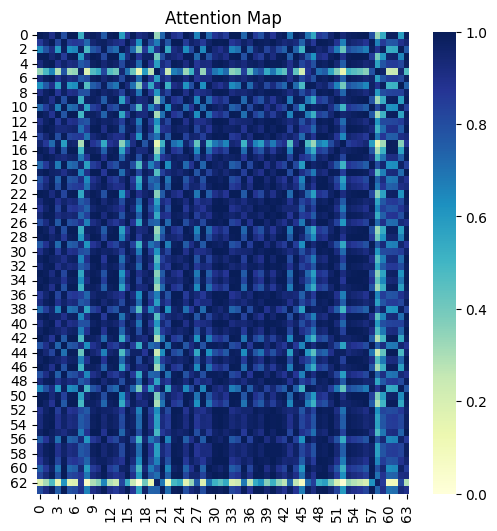

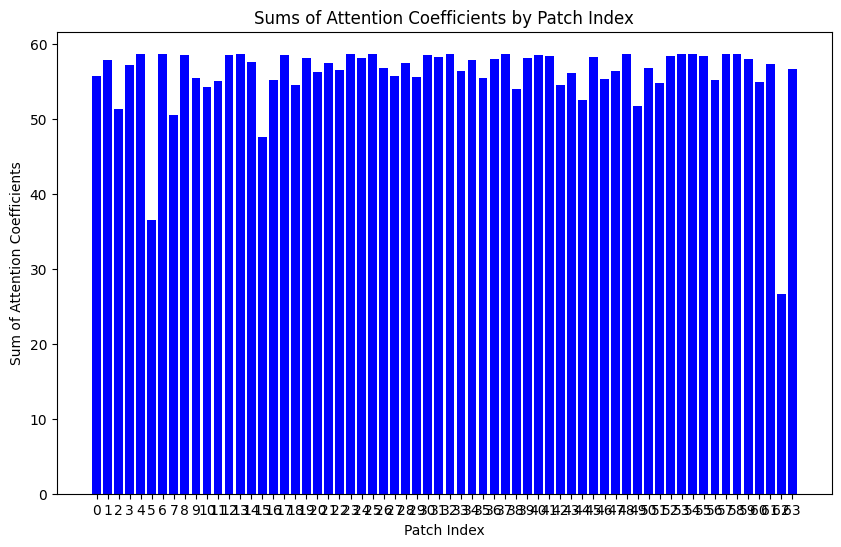

Predicted class for sample 9: 1.0
Row sums: [56.360535 56.968807 51.19692  56.920597 58.643707 33.51174  58.257328
 47.12571  58.52038  55.35202  50.660435 49.791958 58.45289  58.68968
 56.090427 55.423645 58.605392 57.714996 50.493202 58.10604  51.596565
 47.34348  57.302376 56.78842  57.679787 58.663914 52.529594 56.57115
 57.33107  46.223297 58.18991  56.241272 55.1027   55.598923 58.68089
 58.27775  45.31968  53.467365 47.69897  58.367348 58.57837  56.234398
 52.277523 52.72998  56.27112  53.620197 58.395363 54.706573 55.53016
 49.45224  52.441547 55.665504 57.765495 56.862007 57.426025 58.371105
 50.8763   49.640884 56.141624 56.136055 48.205616 47.564346 57.164238
 54.995193]


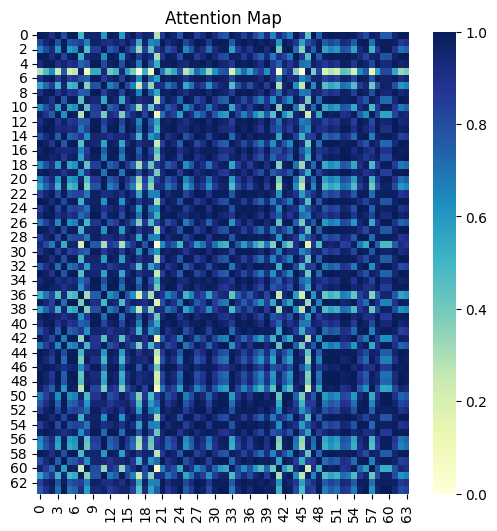

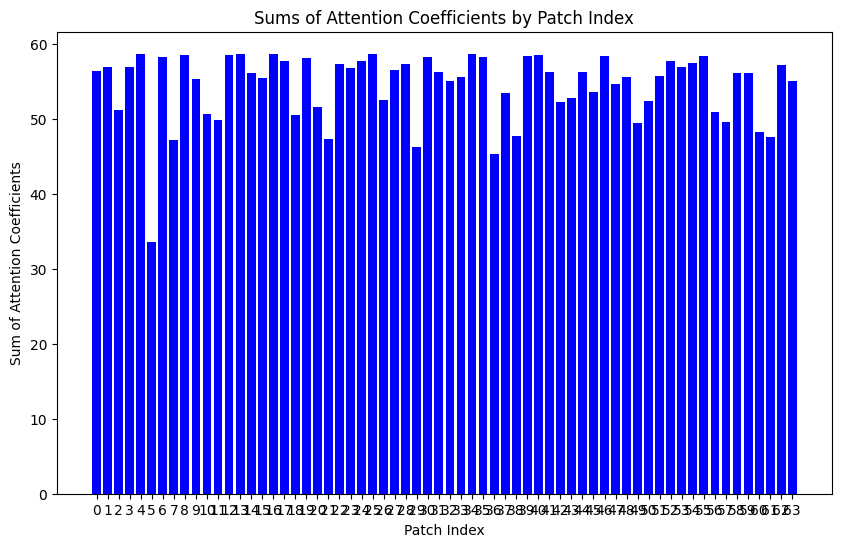

Predicted class for sample 10: 1.0
Row sums: [52.370266 58.75291  60.618927 60.604195 60.522293 58.24687  59.87497
 57.86651  56.402306 58.803505 60.2041   37.193592 60.438828 43.335327
 60.519142 60.67505  60.491028 59.81174  60.49462  46.859833 54.534527
 60.36383  59.43808  60.73448  32.173637 60.046474 60.29252  60.732544
 60.402653 48.924606 60.4408   50.0529   60.664368 59.66571  60.487755
 58.008194 55.214455 58.18105  58.488476 52.013546 60.571754 60.23166
 60.098534 60.52984  38.227776 58.18568  59.52987  60.60314  60.72576
 54.65519  53.465164 60.590145 60.379665 60.709614 60.56337  60.660988
 50.58049  60.68257  58.635593 59.41252  58.406036 60.42399  35.767715
 59.920258]


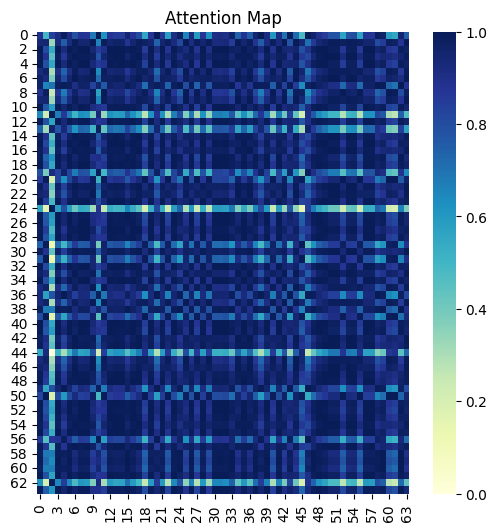

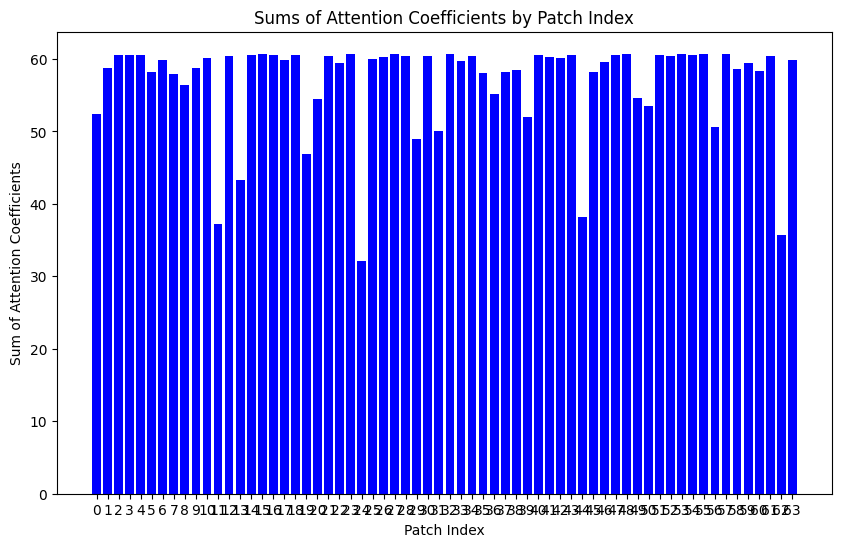

Predicted class for sample 11: 1.0
Row sums: [56.708847 58.10794  55.39936  55.520397 59.46554  37.723232 59.32183
 48.43383  59.605946 55.294464 55.240963 59.477432 58.13642  59.43777
 57.63204  39.69033  59.486286 45.7697   54.200638 59.00979  54.80061
 52.387318 58.59485  59.399315 58.143356 58.549957 58.511883 59.175213
 59.487213 34.708076 58.924923 54.146965 57.66668  58.18545  59.1839
 57.095142 52.350945 49.417847 55.251476 52.497242 48.3599   59.51122
 58.520035 57.734547 45.26873  56.91854  58.70555  58.03557  55.97802
 58.285496 59.24036  56.51728  58.94641  53.748833 56.82956  57.14674
 49.758507 54.67571  52.883133 46.110077 45.366905 48.33194  58.686764
 56.525024]


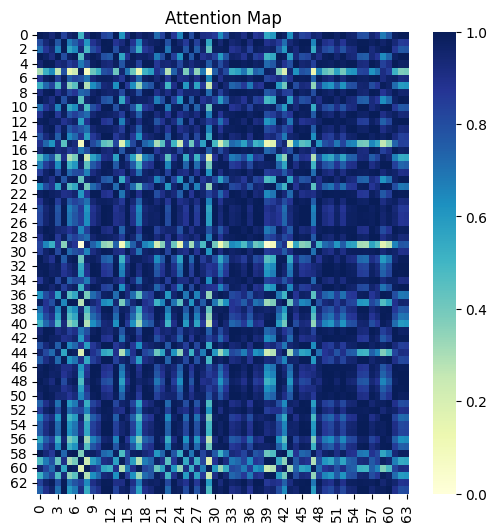

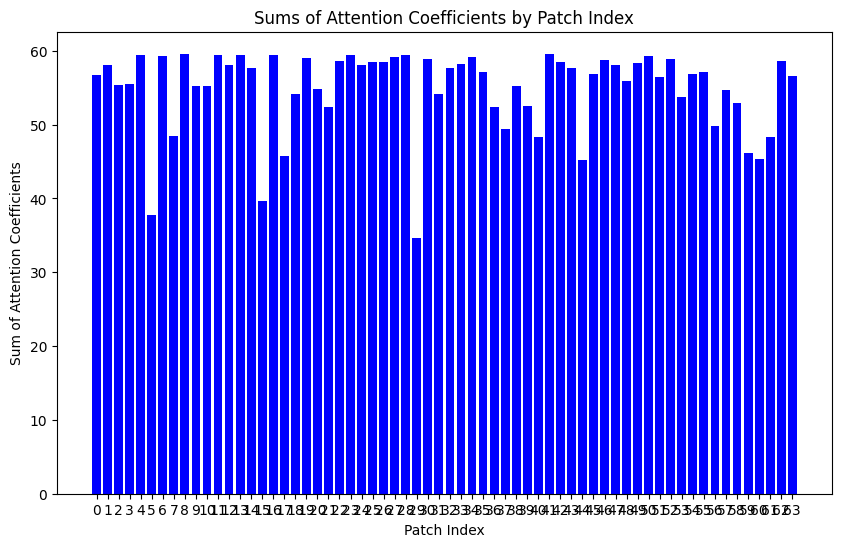

Predicted class for sample 12: 1.0
Row sums: [52.040848 58.128212 59.85398  59.744186 59.86778  58.791492 58.04006
 57.403168 55.430374 58.07831  59.89597  51.468864 59.994267 45.45797
 59.84491  60.037384 59.862785 55.433743 58.351902 59.945026 40.58882
 60.03002  59.73428  59.49349  41.829624 59.98848  59.132233 59.472404
 60.01848  35.575386 55.43197  50.500317 57.51921  56.62013  60.047916
 58.31966  48.90536  54.705723 41.987816 60.026955 59.79599  60.030262
 57.978714 59.27098  48.929543 58.354687 58.707687 59.67704  60.04985
 55.88713  54.00643  59.315155 59.824898 59.83966  59.879406 58.488903
 55.157658 59.955147 60.049965 59.81625  59.94916  57.732193 27.24654
 59.850803]


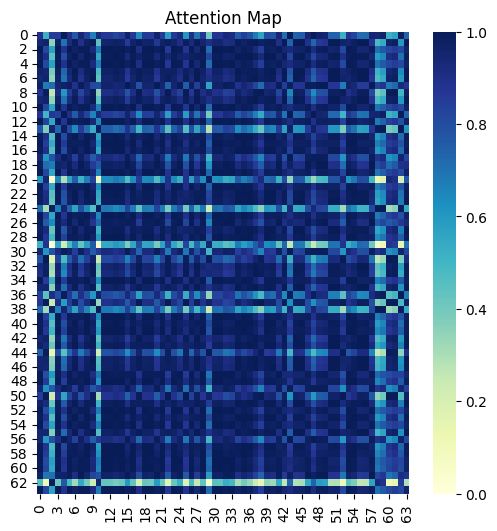

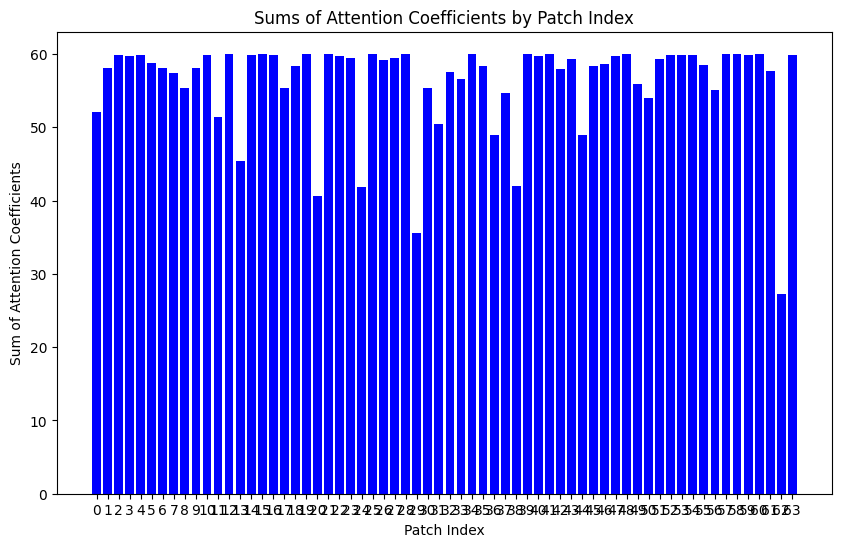

Predicted class for sample 13: 1.0
Row sums: [55.024734 58.68589  59.683857 59.548275 59.97504  57.15054  58.953663
 59.9974   55.268913 59.285736 60.00943  51.613617 59.92677  59.965645
 59.426636 59.746147 57.5002   58.373844 59.280518 59.766453 54.830753
 57.183926 60.02034  58.77098  26.641983 59.501892 59.48104  51.921654
 59.969524 39.125294 54.70544  50.178246 58.263474 56.23439  56.45288
 50.56593  59.710785 52.513504 44.274464 59.871742 58.092667 59.9174
 59.893906 60.008278 45.41314  58.08026  55.769936 60.036797 59.93746
 54.784798 52.859444 57.782776 58.993294 59.91424  60.028324 59.958748
 51.617626 59.843567 58.687027 59.315483 58.26976  59.25351  32.559464
 59.78276 ]


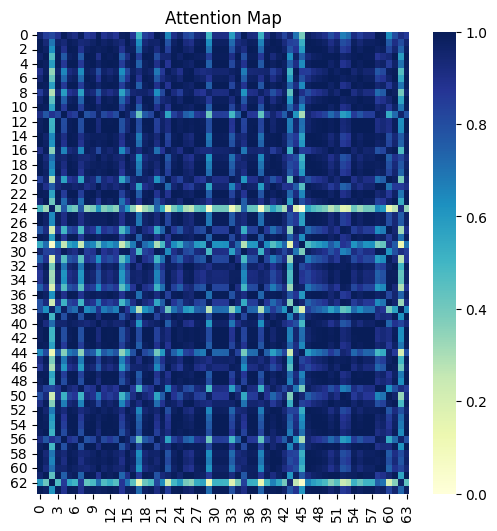

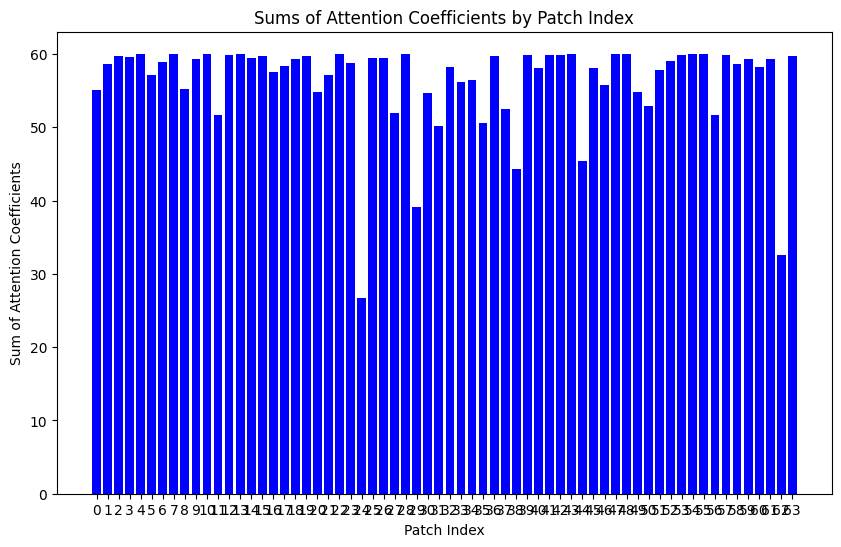

Predicted class for sample 14: 1.0
Row sums: [49.900166 58.832253 54.06781  58.976833 58.88952  27.931173 56.259117
 57.104347 54.854195 55.719696 57.99066  38.621925 59.352642 43.589172
 59.33509  58.726852 55.737576 50.579693 55.846157 59.28644  50.040173
 58.84035  58.541756 58.08503  42.14776  58.70749  57.668556 58.34292
 59.212593 54.23311  58.396896 55.56079  54.65901  56.496956 59.216476
 57.61995  42.824947 58.129776 44.94108  57.151848 59.34496  58.736767
 58.771652 59.182907 40.719147 56.386086 59.18166  59.250015 58.281143
 48.35556  59.349155 59.355804 59.37428  59.12532  59.280296 59.276077
 51.420982 58.95375  59.113136 58.392776 55.89611  59.106255 25.494526
 55.597946]


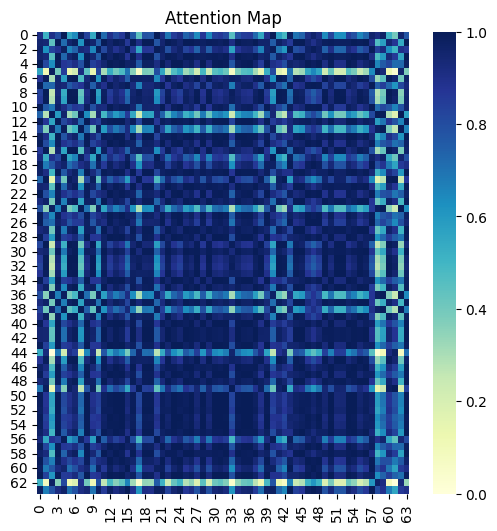

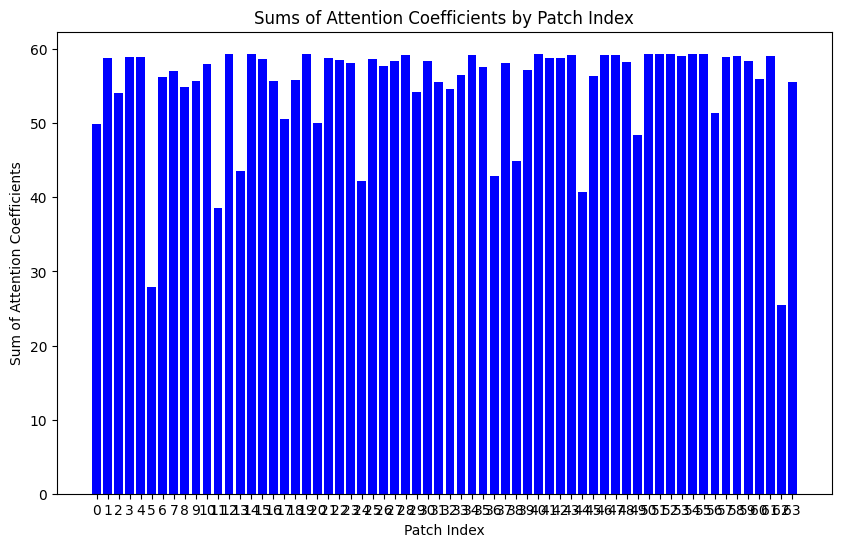

Predicted class for sample 15: 1.0
Row sums: [56.7022   59.609844 51.120197 59.499325 58.01335  56.351604 55.174934
 55.93325  58.47512  52.424606 58.097504 50.43869  59.61378  52.97712
 59.408234 59.443413 55.699173 51.669292 57.05512  57.010834 49.944157
 58.90542  59.583687 54.765034 36.859188 59.060055 58.072323 59.457184
 59.490433 46.62348  59.612183 57.60137  57.82892  58.766644 59.41497
 59.59578  56.887268 58.467148 57.56346  58.953163 59.611908 59.61433
 49.669563 59.489235 47.27677  57.95941  56.57789  59.431965 59.428303
 53.227028 57.98019  59.604267 59.033966 58.88909  59.613235 59.614555
 53.805424 59.61109  59.592148 59.541515 59.061234 57.394135 27.295326
 57.23433 ]


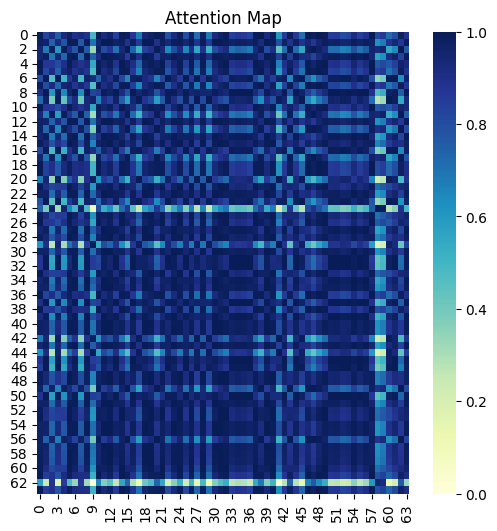

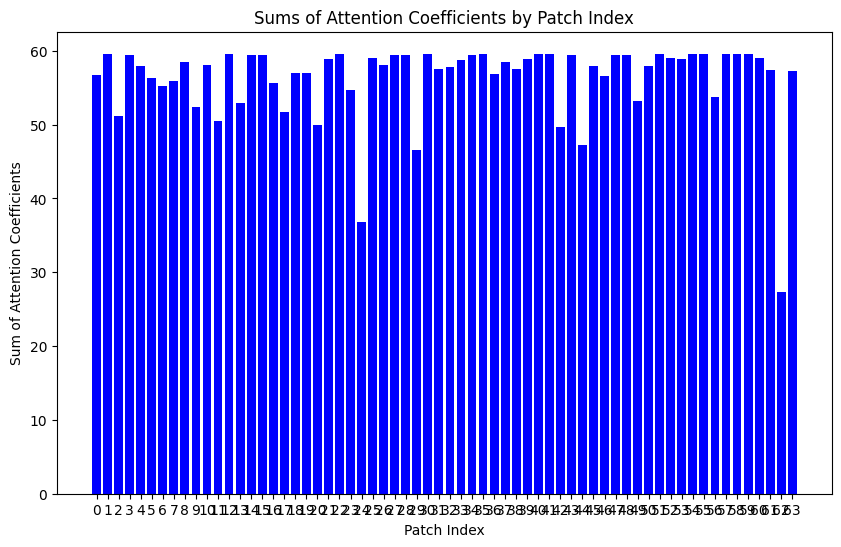

Predicted class for sample 16: 1.0
Row sums: [56.585373 59.397655 59.068367 58.07518  59.270966 33.754757 54.081676
 53.61432  58.024666 53.89693  58.50009  45.628426 59.343422 58.095074
 59.397133 59.407776 57.39968  50.966457 56.78003  58.673256 56.45284
 54.795185 59.33159  54.268867 53.117752 57.02437  58.33834  57.851402
 58.589287 51.1431   59.35571  56.42107  57.907295 57.278164 59.37922
 56.941216 41.80774  55.224594 41.36444  59.383476 59.24196  59.2826
 59.419388 59.14216  43.74723  56.71779  59.370445 58.620518 58.645706
 49.57586  52.403496 59.150303 59.226746 51.38608  57.96994  59.41364
 59.388264 57.412735 59.40299  59.11206  50.888985 53.832306 43.304455
 57.306046]


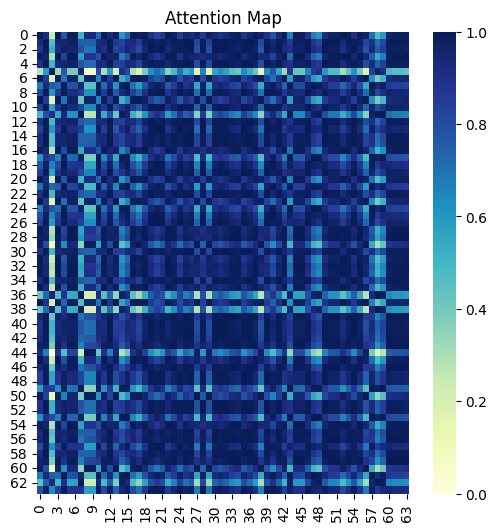

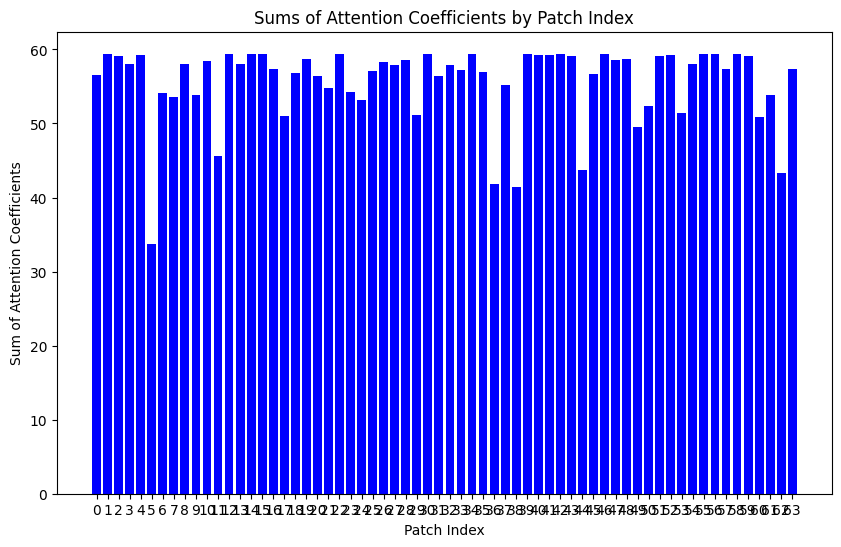

Predicted class for sample 17: 1.0
Row sums: [56.824604 59.119473 45.366184 59.266197 56.15773  51.390076 54.06958
 53.960278 58.961517 51.233246 55.957817 49.805473 59.179466 53.760635
 59.247185 59.025658 51.1556   49.19564  54.956688 56.525753 47.959366
 56.807137 58.86669  53.255318 45.670727 59.2703   56.39071  56.05539
 59.268448 54.399094 59.131897 55.618332 57.099762 56.27459  57.579994
 55.870758 39.767982 59.16654  42.159492 59.14425  59.097404 58.77707
 53.0763   57.81682  57.07316  55.956367 59.09217  59.276047 59.275993
 58.39451  58.11503  56.974773 57.673782 59.192192 58.457653 58.885635
 48.11676  52.29168  56.18609  56.81249  43.396774 49.486404 48.670208
 56.21865 ]


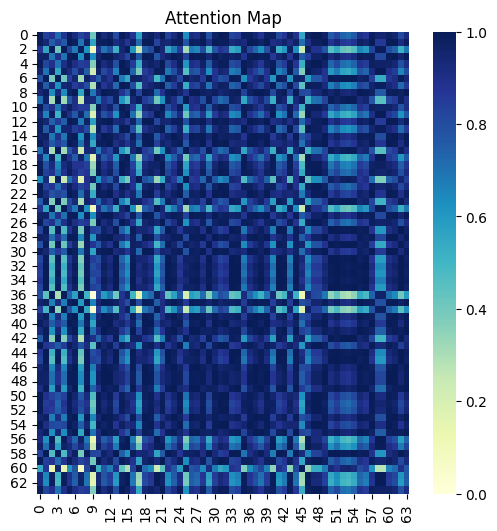

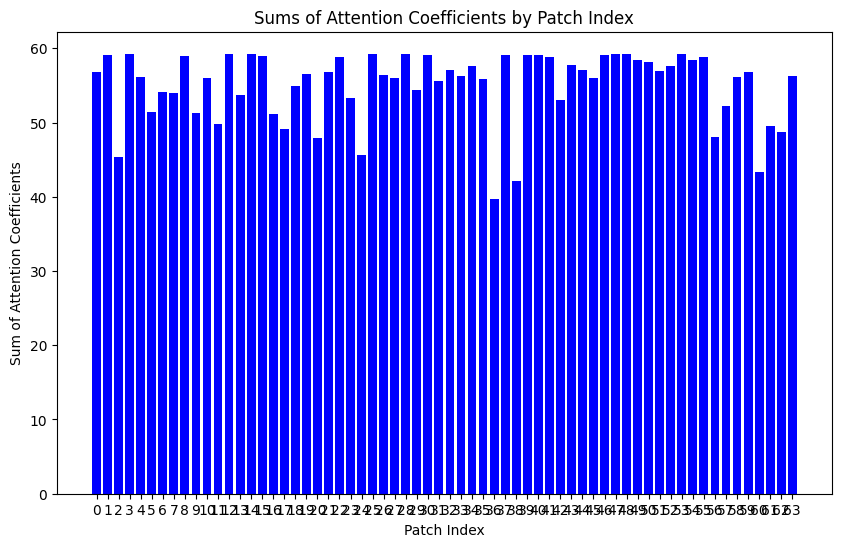

Predicted class for sample 18: 1.0
Row sums: [60.126514 59.946415 53.18346  59.953857 58.465836 53.254143 59.5399
 55.183647 60.04454  56.185432 58.637173 58.162308 60.1114   53.37322
 59.411057 59.97517  54.90586  52.310707 58.086166 58.633324 59.503677
 57.572678 56.295303 54.74612  31.04117  58.88166  56.992874 59.791
 60.121822 54.385475 59.9815   58.551605 56.77612  52.37967  59.988007
 57.575203 45.29246  55.31853  40.063942 60.031776 58.54174  60.000305
 59.580914 58.01203  58.43567  56.59594  59.887806 60.077656 60.102013
 49.897266 48.944817 60.113724 59.780952 52.39357  59.927853 59.997818
 50.690094 52.648743 56.01164  58.134926 43.007927 51.713226 57.208176
 58.043736]


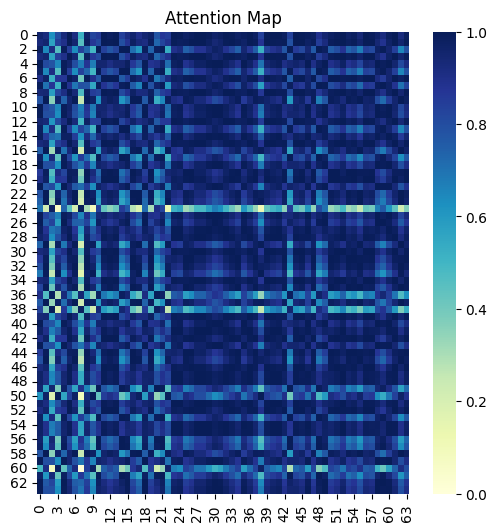

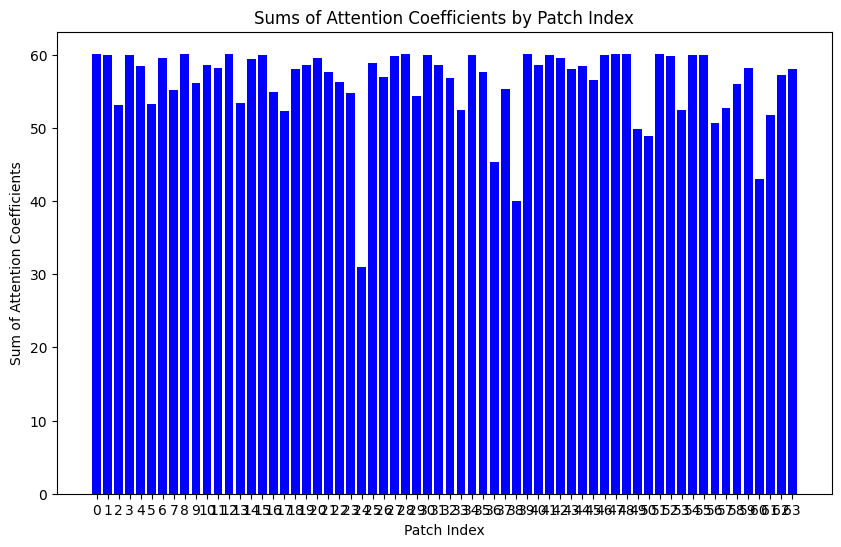

Predicted class for sample 19: 1.0
Row sums: [59.767227 59.96987  53.526157 57.856735 60.011486 34.609272 58.9878
 45.97252  57.821106 59.16763  53.718246 60.018944 59.947006 44.967075
 58.897377 57.69984  55.427406 47.68804  55.03708  57.64566  53.017452
 56.407127 60.010353 54.24688  42.099224 58.85278  59.304897 53.304123
 59.987885 40.308903 59.614723 59.205704 60.02186  57.168022 57.97357
 57.589123 45.54214  55.71186  31.773418 59.270935 59.009148 59.939705
 59.268284 59.26262  49.529125 59.331337 59.24448  58.93898  57.990303
 49.65799  52.073593 59.75949  59.98757  46.749058 59.432766 57.510044
 49.09179  40.25715  57.65662  58.788574 51.843895 46.99768  56.94293
 54.891865]


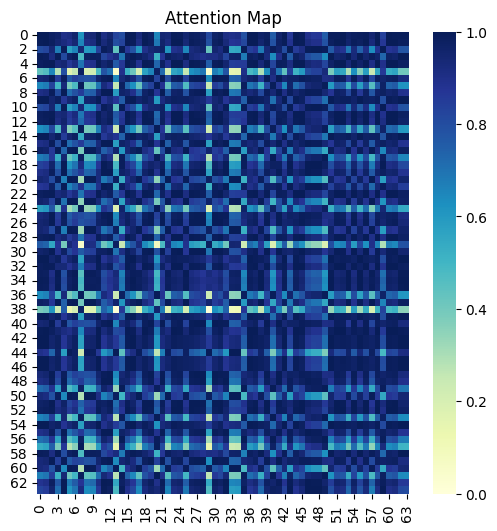

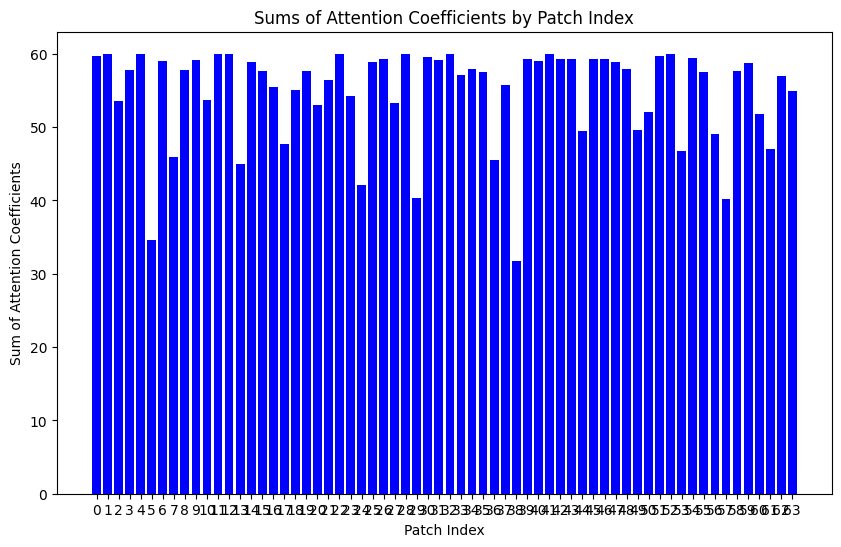

Predicted class for sample 20: 1.0
Row sums: [58.042725 59.19684  45.74645  59.302612 56.618347 48.3685   54.390564
 54.138824 59.151276 51.992355 56.54917  52.40507  59.296703 53.771236
 57.520527 59.165077 52.436092 50.555286 55.956635 56.376785 49.179924
 59.15246  59.171524 53.627678 42.10122  59.32829  57.665604 58.451645
 58.417015 46.61799  57.444077 58.057705 56.988453 58.891426 59.250206
 58.350914 39.74633  56.4111   45.109703 58.9793   59.31462  58.977287
 56.66858  59.19837  50.17683  57.615982 57.270603 59.304405 59.157997
 56.88439  59.192703 59.029865 59.021637 57.48954  59.10238  59.113914
 53.54528  58.75437  59.048073 58.580303 57.626305 54.785557 35.340958
 56.47293 ]


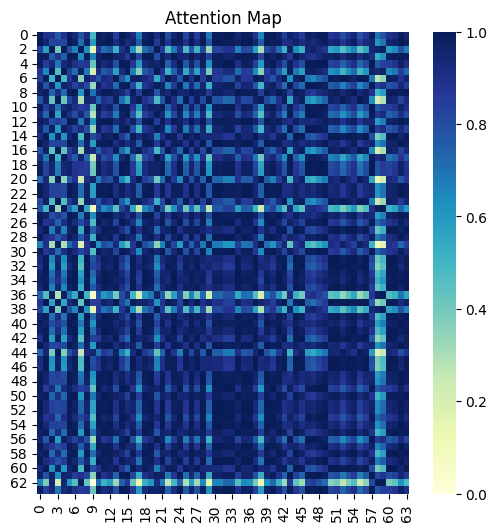

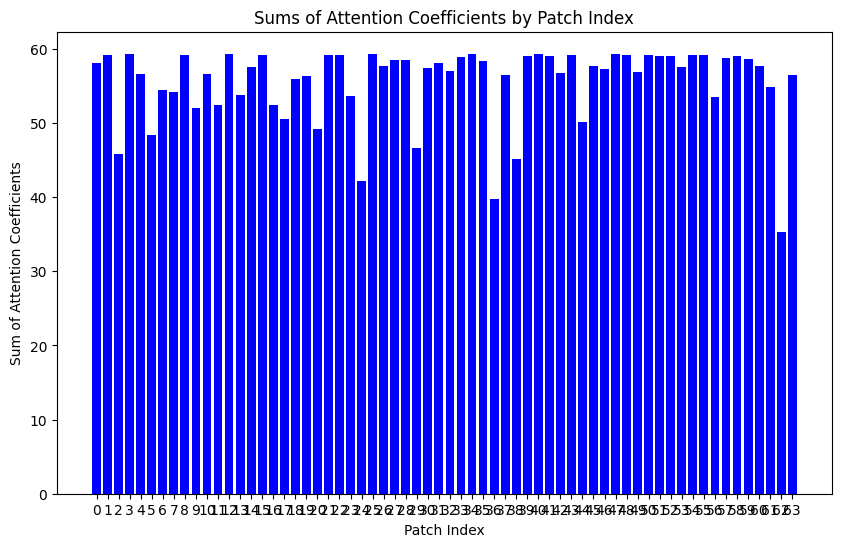

Predicted class for sample 21: 1.0
Row sums: [57.306305 58.725414 54.9895   57.50815  59.78943  40.842846 59.655777
 50.606766 58.498764 56.816803 57.51662  59.080925 59.746468 59.794502
 59.805367 50.552902 55.44284  59.415176 58.077244 56.348457 59.456104
 56.17126  57.709946 59.80385  52.473896 58.70331  58.731873 59.797688
 58.86843  58.904877 58.53647  56.89898  58.639065 56.94097  59.694557
 57.872646 41.798794 57.230865 38.847343 59.752464 59.79371  59.737827
 59.75659  59.776047 51.641666 58.469967 58.75786  59.5923   59.532516
 48.908928 52.258877 59.791405 59.6827   59.467514 59.74253  59.668713
 55.177498 59.777985 59.716972 59.223347 59.548973 57.231045 28.13673
 57.28302 ]


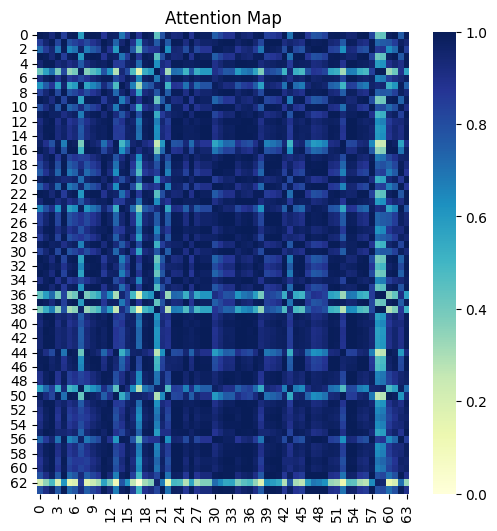

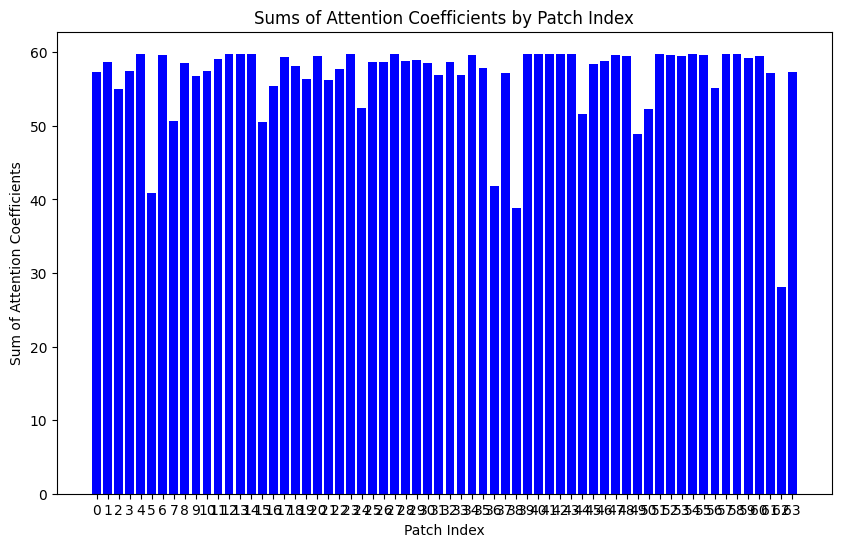

Predicted class for sample 22: 1.0
Row sums: [57.008766 57.958992 52.987183 58.63009  60.19428  37.37215  59.455925
 45.166443 60.222244 56.051945 58.741837 60.206085 59.89593  54.775352
 59.724625 59.19297  56.30838  58.861706 53.324898 60.00762  58.50078
 55.73918  59.813465 55.38653  29.568466 58.444073 57.956894 60.056286
 59.510166 59.776596 59.772232 58.893806 58.833668 59.859474 59.99033
 59.878716 40.033348 54.959686 35.729538 57.479225 60.010307 60.209595
 60.23606  59.915134 51.879456 59.10576  60.03788  60.19964  59.570507
 57.65454  60.23159  59.099915 59.688194 58.918663 59.88095  60.072838
 54.78476  57.96846  58.981724 59.04538  56.61161  53.920715 36.032974
 56.61032 ]


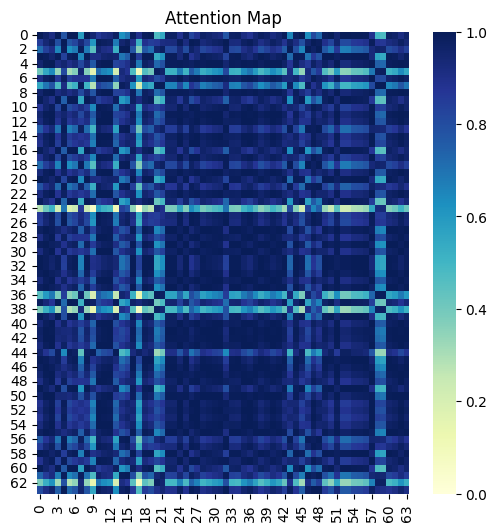

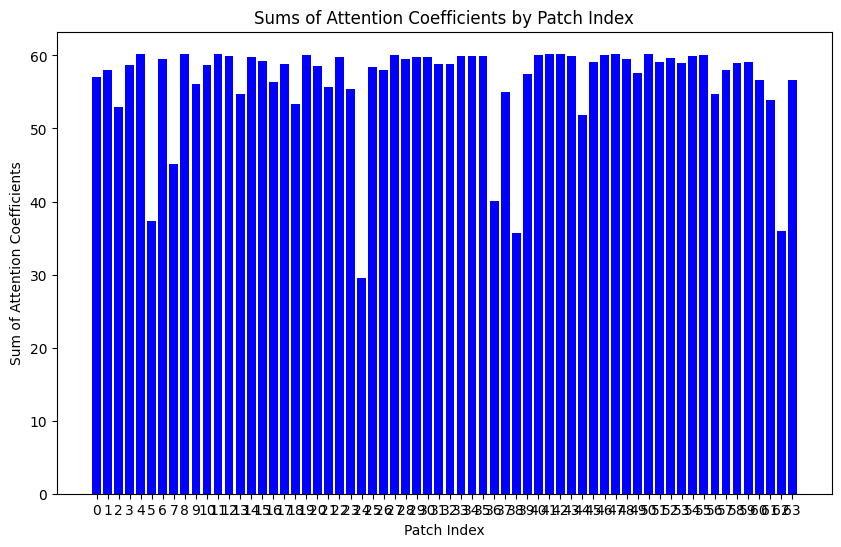

Predicted class for sample 23: 1.0
Row sums: [55.606117 58.415802 50.619473 57.745216 58.17225  53.153996 57.57274
 56.76931  58.417023 51.129772 55.85114  57.93074  58.372765 52.28128
 58.168507 57.687977 51.265385 48.050064 55.10772  53.342422 39.870964
 58.417442 58.417423 49.256725 53.51554  57.96792  58.05937  56.409233
 56.40418  54.94952  50.39006  41.438034 56.74372  55.0783   58.390892
 54.036774 53.720215 57.945137 58.282654 57.06926  55.725716 58.33186
 49.006237 57.69158  44.079525 58.366486 56.8397   58.274986 58.40603
 49.411118 52.728043 58.4103   58.411095 58.30912  58.061974 57.290367
 55.2386   50.10676  53.991264 56.597607 39.16365  49.344147 53.10704
 56.1632  ]


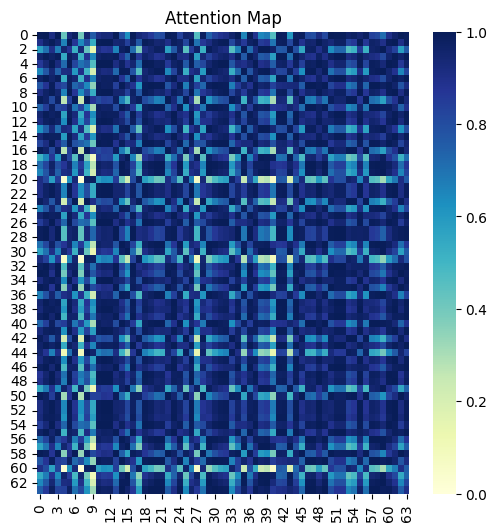

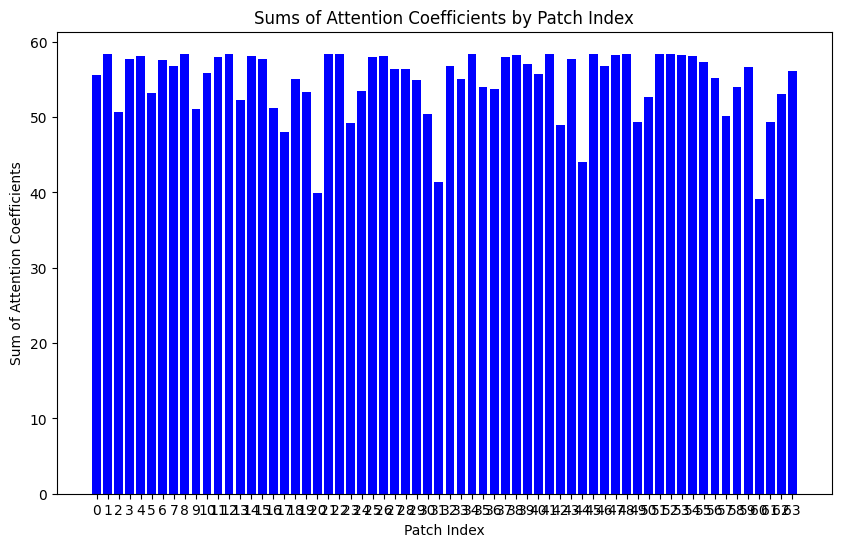

Predicted class for sample 24: 1.0
Row sums: [58.314236 55.236237 54.434074 55.233208 58.277157 37.954655 58.062614
 48.59496  55.416756 58.264313 50.450714 46.226463 58.30403  58.170803
 56.5403   46.26528  52.49745  57.564964 49.264366 57.3896   51.425797
 55.31069  54.080067 58.111534 57.489746 58.071373 58.284683 58.297394
 57.675705 58.30275  54.695805 53.049294 56.035816 54.275272 54.97547
 57.81794  45.431076 52.745365 46.81651  56.33574  58.221764 58.08731
 57.941895 58.229374 50.729416 54.5718   57.54797  57.006706 58.30205
 51.06139  57.86384  58.085934 57.89353  56.208622 58.275795 57.392822
 43.48239  50.077393 55.60443  47.98353  45.252357 58.25253  58.298084
 54.39041 ]


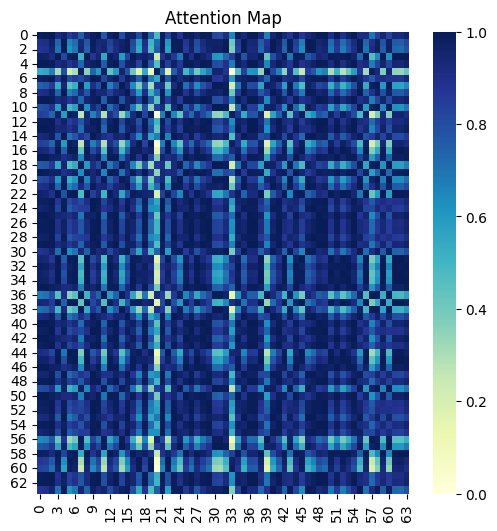

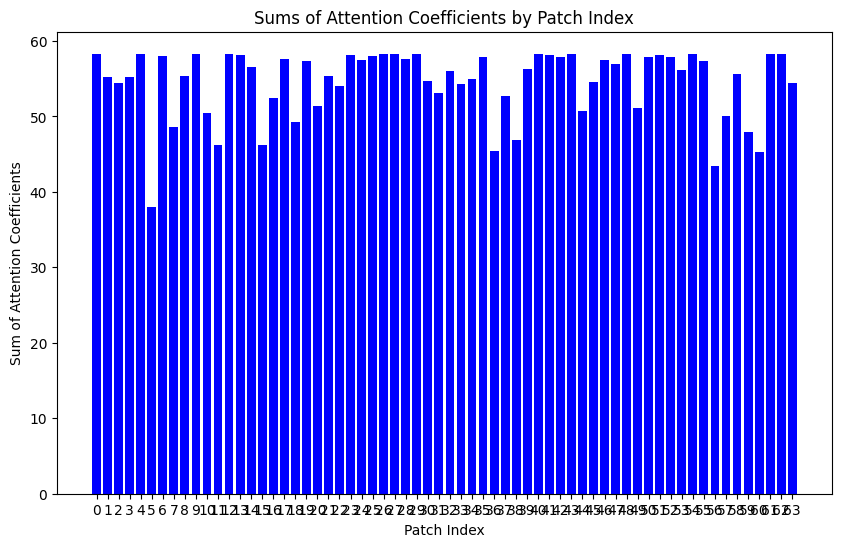

Predicted class for sample 25: 1.0
Row sums: [57.715736 59.298927 45.57749  58.072075 59.02076  44.526367 57.594902
 56.934975 57.388725 53.80788  57.043846 50.074276 59.29982  54.814404
 59.362892 59.277176 51.24514  54.64229  54.791115 59.202312 53.23014
 49.470146 59.25184  53.512024 51.734543 58.80817  59.36433  54.36924
 57.733322 57.245876 52.974834 58.256752 59.27137  56.608498 59.202335
 55.457455 54.52325  53.459732 55.005375 56.15482  49.98526  58.983337
 56.659992 56.011185 52.344063 59.051025 58.074738 57.27266  56.059193
 59.16139  56.749992 57.580513 58.419193 59.370846 58.380093 53.096756
 53.337246 52.287056 56.78508  59.194504 55.019444 57.88687  25.646374
 58.72254 ]


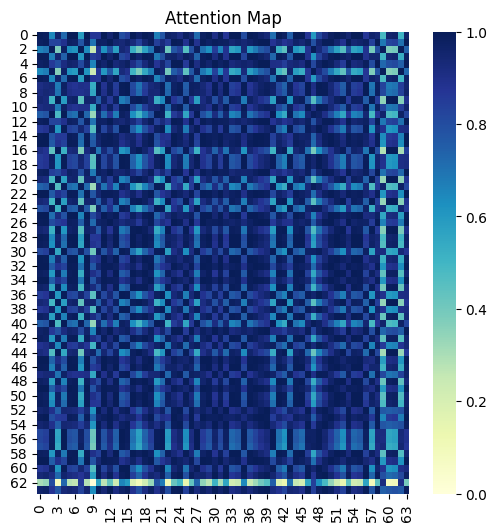

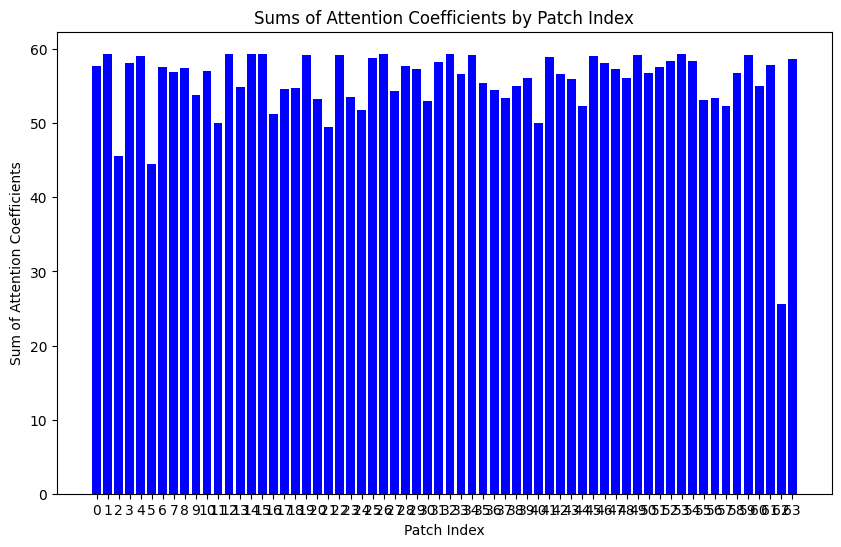

Predicted class for sample 26: 1.0
Row sums: [55.055187 59.315895 49.993687 58.82225  57.37596  58.915855 54.485947
 54.636314 57.310043 53.291515 58.144436 44.333237 59.461357 43.61333
 59.149826 59.117188 59.43933  53.285038 56.831306 55.824768 51.205036
 53.895744 56.91767  51.747253 34.454304 58.845703 58.30227  57.268265
 59.427868 56.927895 59.415764 57.58426  52.803123 55.42765  59.406708
 57.857788 37.03206  56.018578 36.975662 55.719616 58.23971  59.46086
 58.2214   58.17432  49.23723  54.714924 58.992832 59.349052 59.14597
 50.434586 55.149216 59.461517 59.265617 56.009575 59.062965 58.887108
 45.273216 59.43312  57.242847 58.413887 57.283783 53.03492  57.416668
 56.101227]


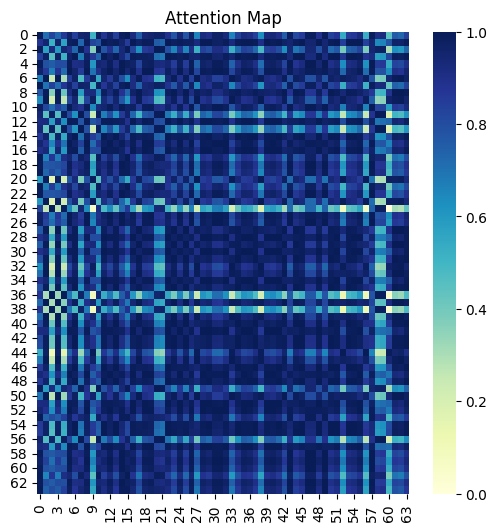

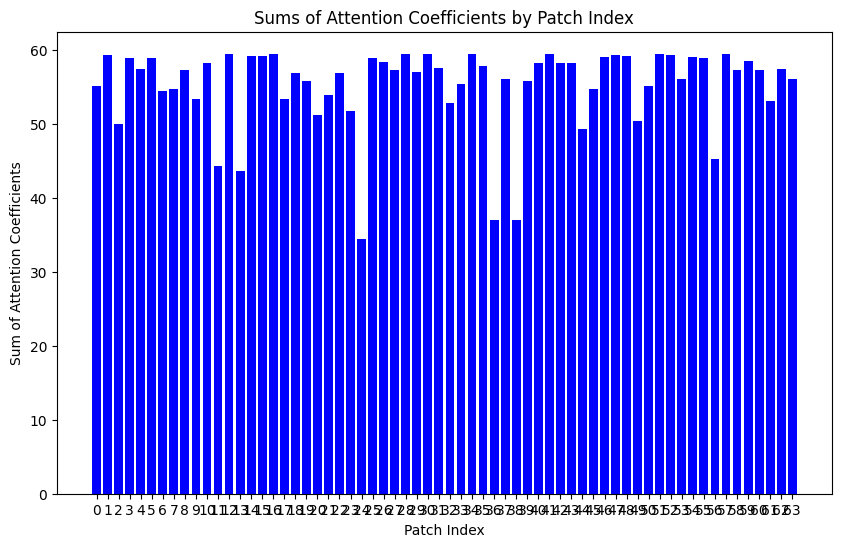

Predicted class for sample 27: 1.0
Row sums: [51.95114  59.751846 49.06938  58.898735 59.04316  55.051193 56.939514
 56.04547  56.056835 53.367065 59.25054  45.531914 59.940765 56.21498
 59.93239  59.813774 51.308144 46.53757  58.15631  58.621178 53.010963
 57.93364  59.412643 52.951675 56.329453 59.338036 59.934017 54.707584
 59.292046 51.279823 59.668182 58.489254 58.897396 56.333946 59.940678
 58.135464 28.874413 58.31807  33.777603 59.625385 59.923428 59.550156
 59.916958 59.04143  46.281616 58.264385 59.398697 58.005833 58.692074
 47.301876 51.47644  59.915543 59.68518  58.18477  59.329422 58.96871
 47.437515 50.468864 56.459892 57.35103  40.685265 49.433685 54.42022
 57.09771 ]


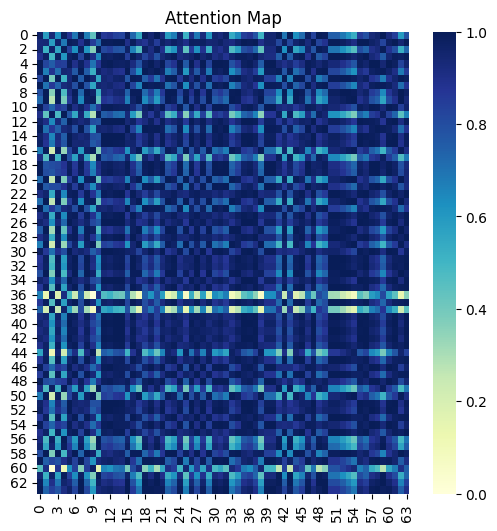

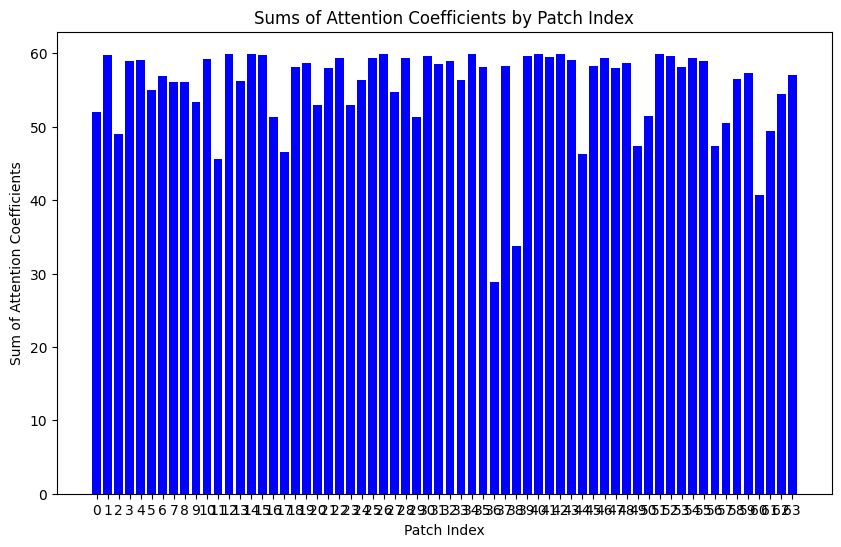

Predicted class for sample 28: 1.0
Row sums: [58.364872 59.728218 47.97386  59.958855 57.55484  36.509266 59.882324
 48.166412 59.95175  58.32029  52.080387 56.45056  59.9118   59.661648
 59.94771  43.82576  50.82083  53.64005  56.475857 57.114243 49.519867
 51.739174 58.909424 59.738796 53.183113 59.875328 56.098    59.171337
 59.96028  59.429996 59.92983  58.34998  59.737366 58.371555 59.49977
 57.42409  40.023327 53.406475 38.530037 58.88011  57.737976 57.988934
 55.68884  55.69087  40.7437   58.719032 59.865158 59.115616 58.975536
 58.90475  59.493507 53.007217 59.209812 30.767206 59.84505  58.468605
 50.21145  56.16701  57.30096  55.976105 44.892323 47.89988  54.172173
 56.48999 ]


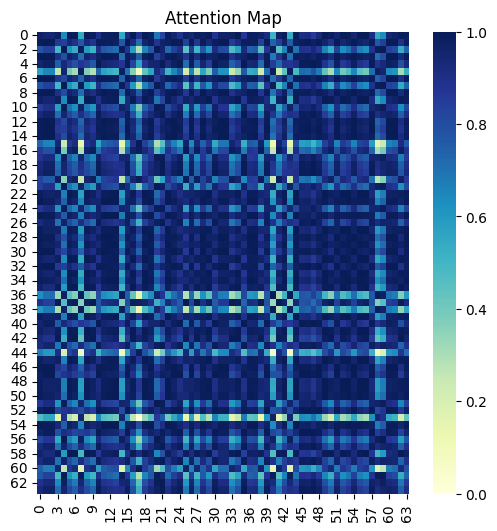

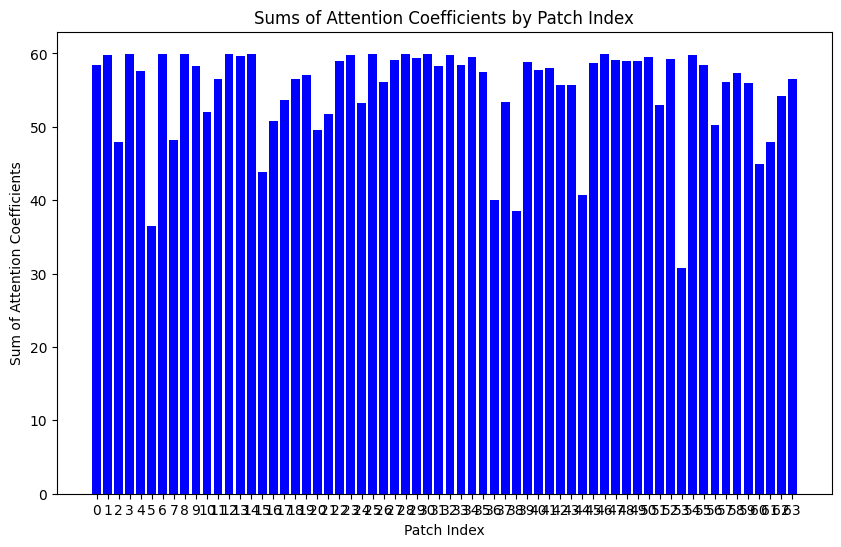

Predicted class for sample 29: 1.0
Row sums: [57.608738 58.284805 47.114765 58.351288 55.588314 58.054077 52.447205
 55.71976  57.44274  54.10862  53.638664 56.43766  58.346893 54.956993
 58.23915  57.728573 47.698658 49.245583 55.637127 50.4658   49.982517
 58.149303 58.15406  51.392258 58.40877  57.769844 56.12095  58.2167
 58.380142 38.976006 57.065983 40.37338  56.39365  52.15456  51.339397
 57.679718 38.108772 53.361908 32.243782 57.03016  58.42443  54.74058
 57.13864  58.004364 47.473392 57.24569  58.208344 58.2106   54.137665
 56.87598  55.816406 58.396896 58.365883 57.470814 58.225372 57.91085
 52.383423 58.046326 56.032234 58.42345  58.42334  53.027687 48.940002
 53.271255]


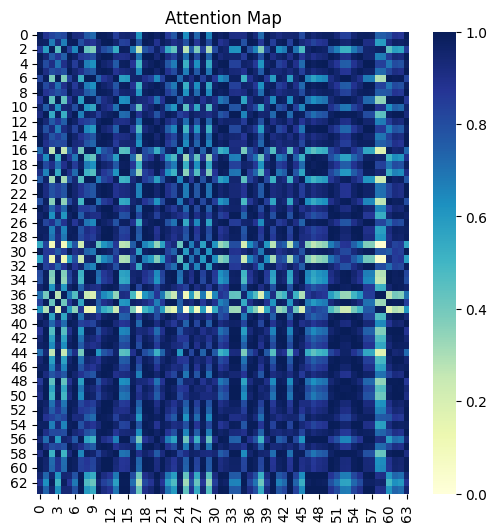

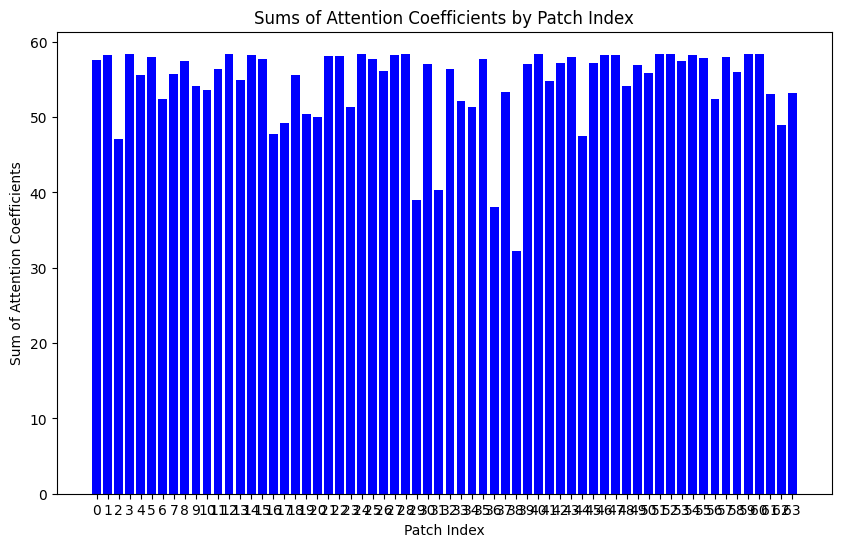

Predicted class for sample 30: 1.0
Row sums: [58.25158  58.026955 40.21186  58.588203 55.728203 39.822586 54.0808
 51.30932  58.568306 52.919403 55.079994 56.334877 58.57452  55.02027
 58.583775 58.336327 49.21792  51.812496 55.318058 56.780003 51.432373
 54.490543 58.586483 53.49555  52.804382 58.51485  54.231968 57.576324
 58.508736 51.77939  58.55095  57.381073 51.70587  52.63467  57.712936
 57.66149  57.20961  56.56616  46.776886 56.305035 58.30065  58.30273
 54.874878 54.65815  54.66039  55.517372 57.819244 58.08528  58.583694
 57.966484 58.530922 57.756405 57.628883 58.587135 58.466995 58.416855
 49.201168 57.036102 57.29505  57.274967 54.17242  52.848587 36.845604
 55.396587]


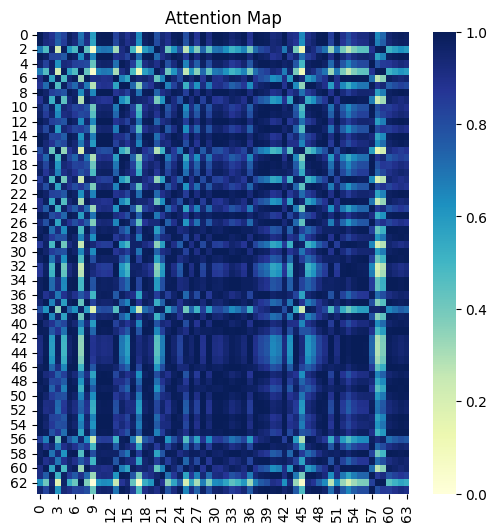

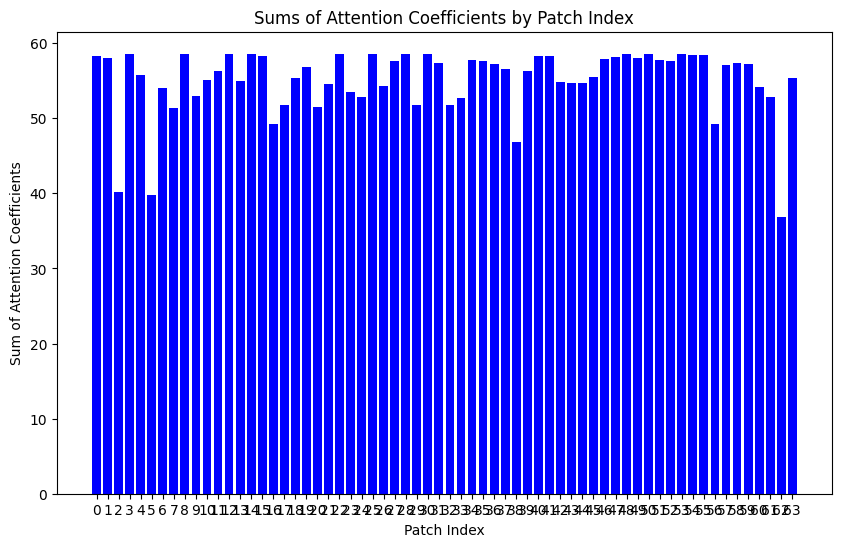

Predicted class for sample 31: 1.0
Row sums: [57.462036 58.93554  38.13699  58.988087 55.932083 35.04383  59.028645
 45.239174 58.553734 55.00467  52.94596  57.794014 58.82113  58.570114
 59.04445  58.240685 50.44025  57.073845 55.058605 58.000774 53.76947
 54.053413 58.91919  56.5553   55.076607 58.888123 56.638725 55.214836
 58.919582 51.67873  59.035988 56.48918  55.80601  56.149845 56.524532
 57.345924 47.69329  54.89971  46.654545 55.96326  58.432053 58.85475
 48.023617 57.22574  44.07595  58.877945 56.761787 58.407654 58.65561
 48.981163 53.429947 59.085773 58.716927 51.824738 59.036736 59.085358
 49.927517 56.26381  57.9317   58.131157 54.931343 51.905846 39.417416
 56.85599 ]


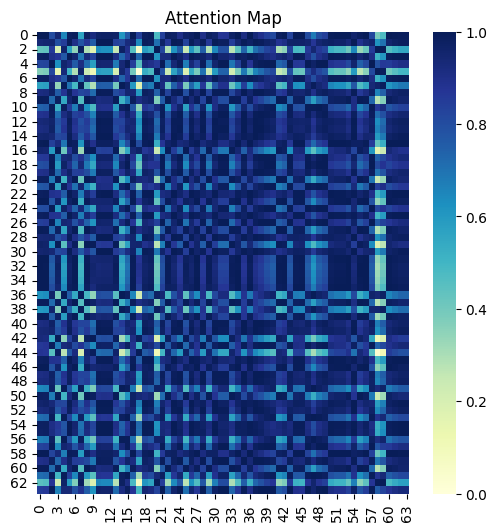

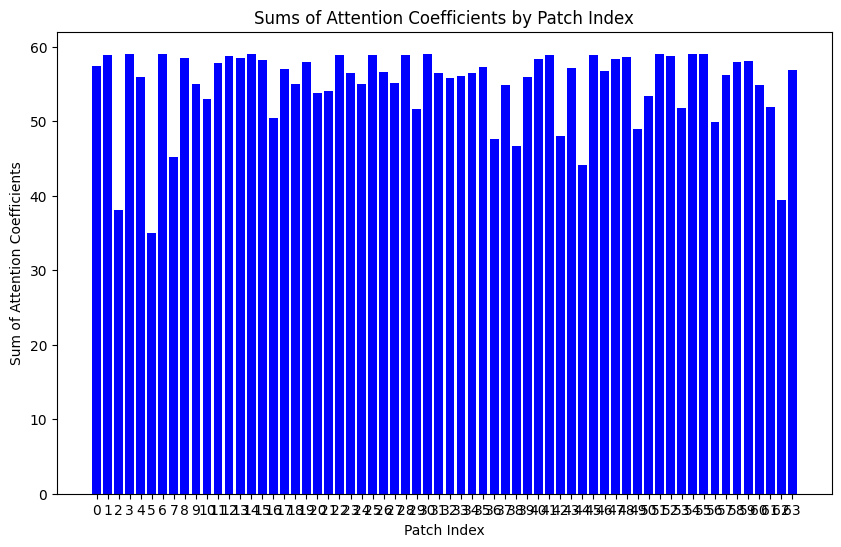

Predicted class for sample 32: 1.0
Row sums: [57.186707 59.187096 47.26181  58.552837 59.406548 32.125114 59.55011
 50.85961  59.286293 56.049805 54.584293 57.3047   59.037823 59.534584
 58.617783 49.687534 52.55101  56.70302  55.563828 59.386715 59.371902
 55.31594  57.71025  59.548546 59.36806  59.299843 59.05786  59.51335
 59.54791  56.50202  57.43098  55.172318 59.49135  57.254646 54.88572
 56.214592 57.07511  58.514656 58.526398 58.85027  59.34349  59.174156
 55.202217 58.37414  47.03858  55.176445 57.279545 58.82357  59.244194
 50.79698  58.757927 51.79691  59.4086   58.62468  59.38253  58.883724
 36.012566 50.347504 55.019745 59.550026 41.553215 56.711155 57.78646
 57.99297 ]


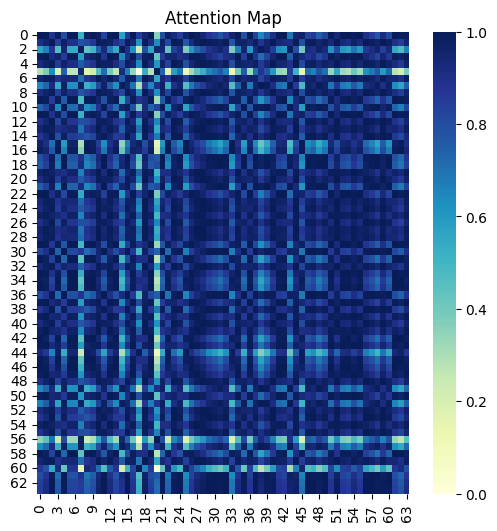

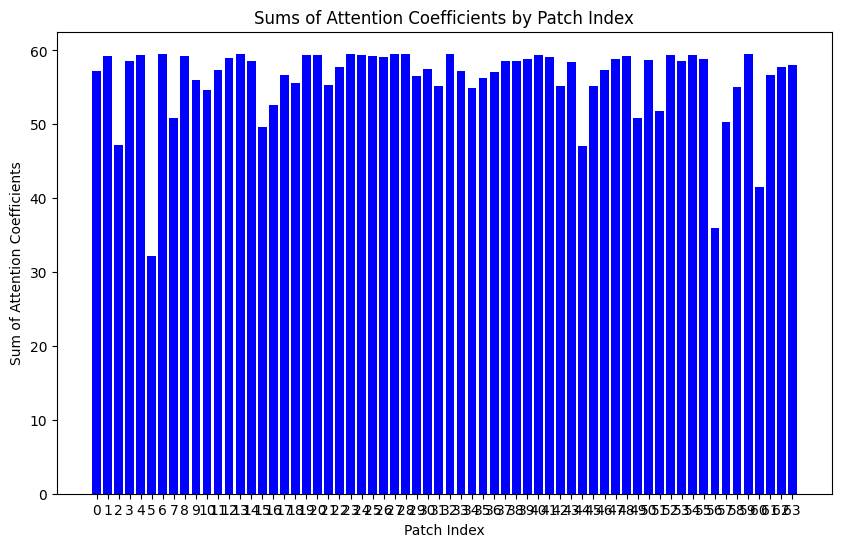

Predicted class for sample 33: 1.0
Row sums: [55.884537 59.854942 54.20793  59.66645  58.739944 55.876328 56.082863
 55.296608 59.645725 49.983643 57.49946  48.148518 59.043182 54.67154
 59.156593 59.70352  59.886837 55.30179  56.270523 59.370087 46.95364
 58.717583 59.837883 59.658905 33.907562 59.56655  57.31766  59.810665
 59.72965  49.000057 59.842773 59.540276 56.000237 58.01115  59.445198
 58.5856   45.066605 58.778355 58.42793  56.787895 59.88612  59.131855
 59.51811  56.169136 54.963287 58.93837  59.736393 59.781742 59.820877
 59.801666 59.65464  59.254036 58.76413  59.77172  59.71278  59.454674
 52.786552 57.94899  58.739388 58.606297 53.752464 54.087814 41.22439
 57.42666 ]


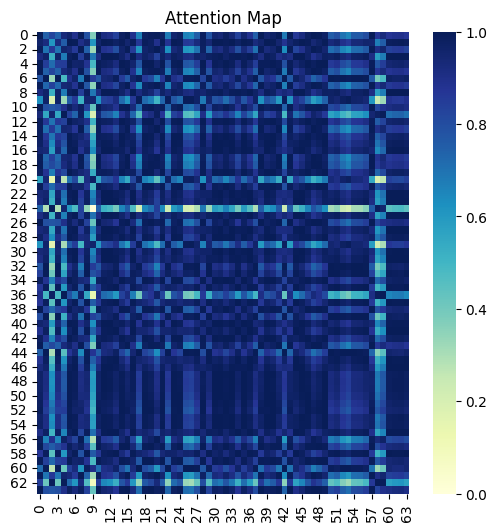

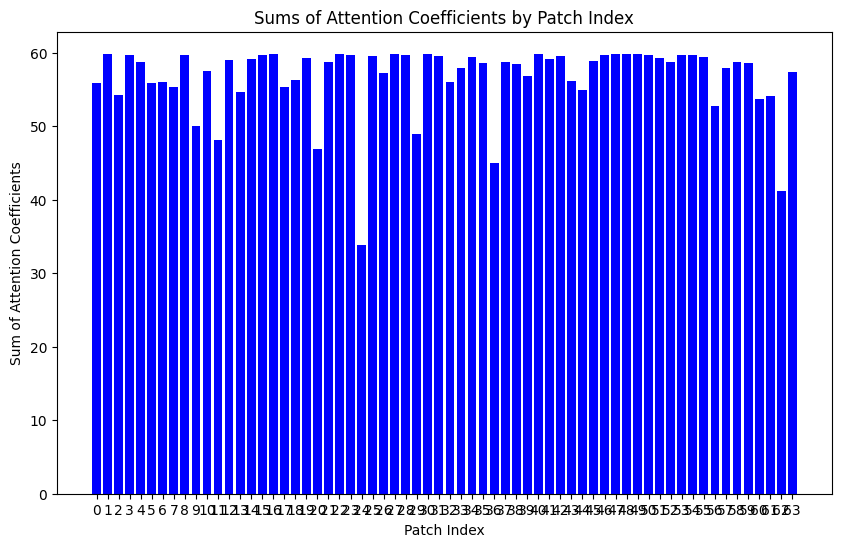

Predicted class for sample 34: 1.0
Row sums: [56.106552 57.75193  50.59417  57.404945 58.968407 34.408913 58.89054
 49.131203 58.849354 55.53355  52.931168 53.210068 58.61856  58.98452
 58.987675 56.631264 58.27041  58.04324  53.725918 58.72512  58.27478
 54.062416 58.41239  55.852875 58.84465  58.81208  58.99674  51.426384
 56.573284 58.75974  58.45186  57.874672 58.754074 51.852142 55.99102
 54.38723  51.739136 55.396202 40.93206  56.937904 58.962296 58.518536
 52.542152 58.62111  45.176643 58.1634   58.801514 57.501083 58.266613
 48.73791  50.705242 58.96453  58.61641  58.598804 56.57369  58.9883
 57.86757  57.53277  58.97594  57.36611  57.414185 58.102997 26.592422
 48.49225 ]


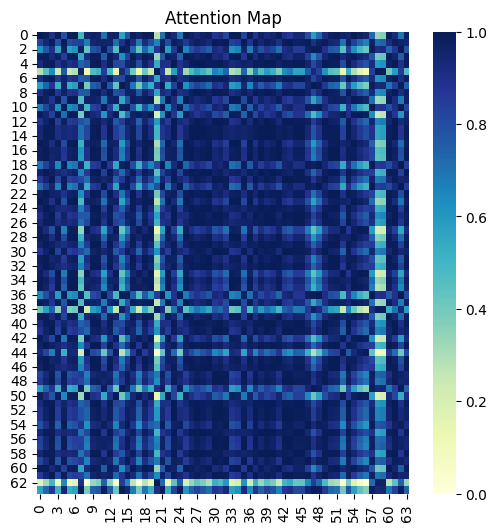

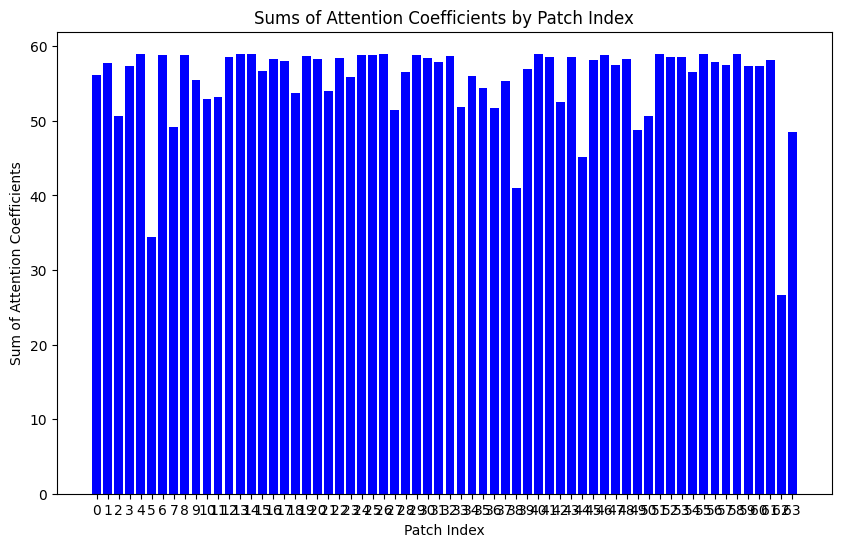

Predicted class for sample 35: 1.0
Row sums: [57.850166 58.59237  41.916737 58.97655  56.004658 30.77212  58.02227
 50.434002 58.783897 56.400658 52.77803  58.005604 58.126213 59.055374
 58.2472   54.50143  52.933823 58.53308  55.862625 58.36155  58.689392
 54.076813 58.511467 58.904198 57.46453  58.97005  54.439545 57.94104
 59.102207 55.164764 58.865124 56.752037 58.9389   57.047943 57.745224
 57.982162 45.28017  51.760956 43.23813  57.220062 58.76304  58.882267
 53.027832 57.829166 50.454685 58.026215 58.624012 59.03299  58.961136
 59.101265 58.13188  57.910496 57.828957 58.93857  58.723198 58.922554
 49.81122  56.894985 58.042534 57.50556  53.972733 52.54489  38.689873
 55.84719 ]


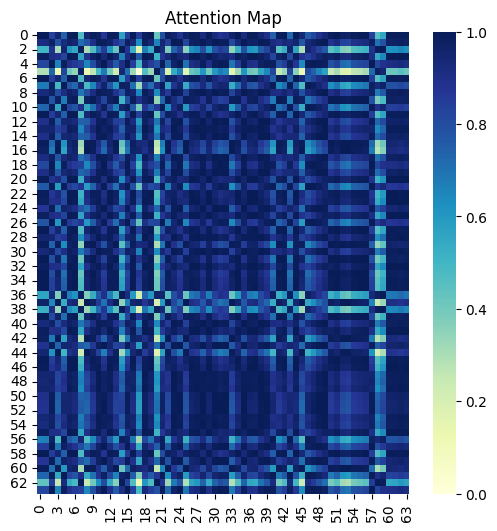

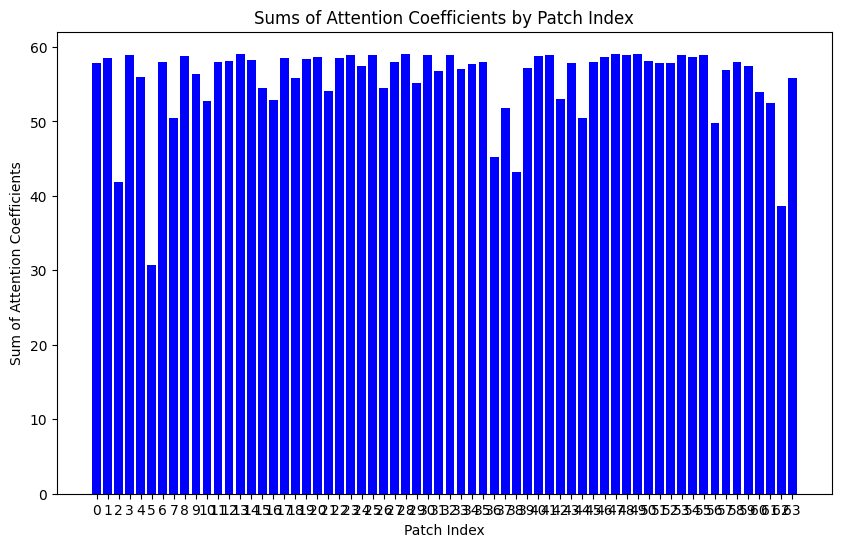

Predicted class for sample 36: 1.0
Row sums: [59.312164 59.0571   39.76866  59.25624  56.160103 33.68849  56.40355
 51.53318  59.09758  54.145054 54.268913 57.41456  58.904083 57.66935
 59.330498 59.251694 50.461433 54.024357 55.108997 57.548523 53.434513
 55.16826  59.329197 56.59467  51.08954  59.265533 51.992867 57.469246
 58.510483 47.72056  59.191383 57.197395 56.171753 56.977943 58.912918
 56.94125  48.052155 56.820934 33.143814 57.062874 59.288437 58.24662
 58.36272  59.3318   51.210197 56.10501  58.831963 59.217026 59.277664
 58.37728  59.33186  57.990166 58.07345  59.155273 58.910122 59.16275
 49.395226 56.14412  57.86863  57.80439  51.984245 51.861626 41.521645
 56.140163]


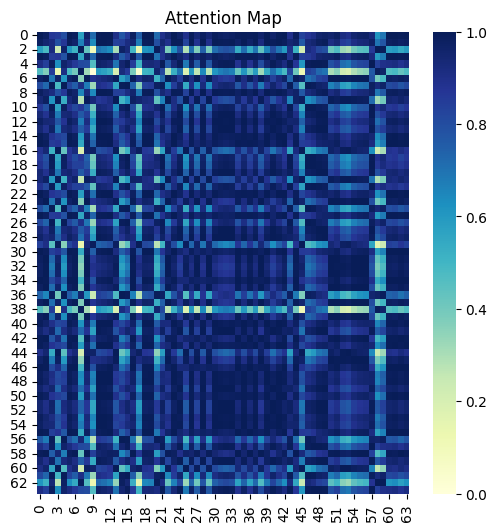

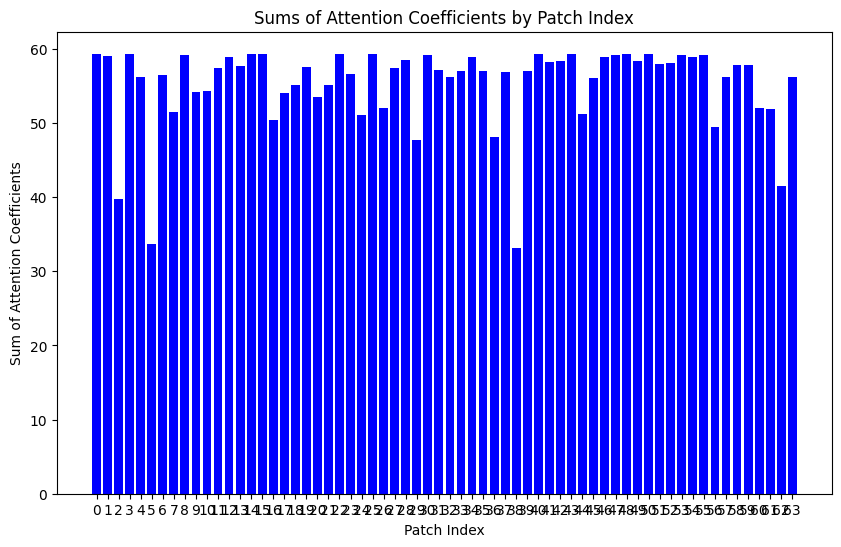

Predicted class for sample 37: 1.0
Row sums: [59.251465 58.707497 42.820335 59.04226  57.29879  28.966345 59.09699
 49.451317 59.110847 57.148045 52.262184 59.040436 59.18072  54.129364
 58.37456  53.297153 55.1868   59.209553 58.7273   54.980957 58.685738
 58.855316 59.08976  59.249546 59.217785 59.25434  59.083515 52.739273
 59.007294 57.796265 59.25406  57.475456 56.133434 55.131443 58.471985
 57.78757  39.875046 56.474365 32.945923 59.248123 57.884224 59.235504
 55.293915 55.43954  51.34091  56.061638 57.71543  59.170937 59.10029
 58.5213   57.57305  57.77958  55.606228 48.10036  58.812355 57.723743
 41.33738  49.733864 59.15679  59.188606 51.56049  48.161045 57.277542
 55.32384 ]


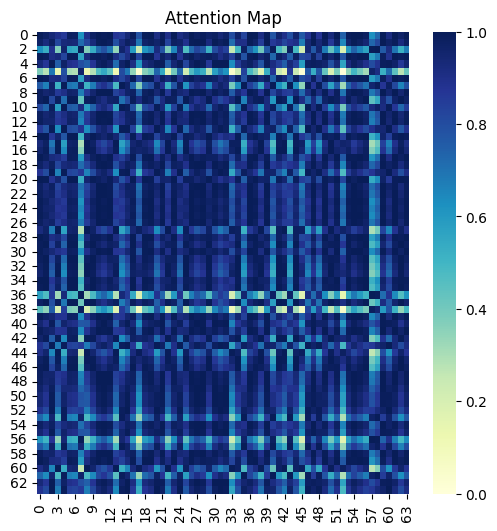

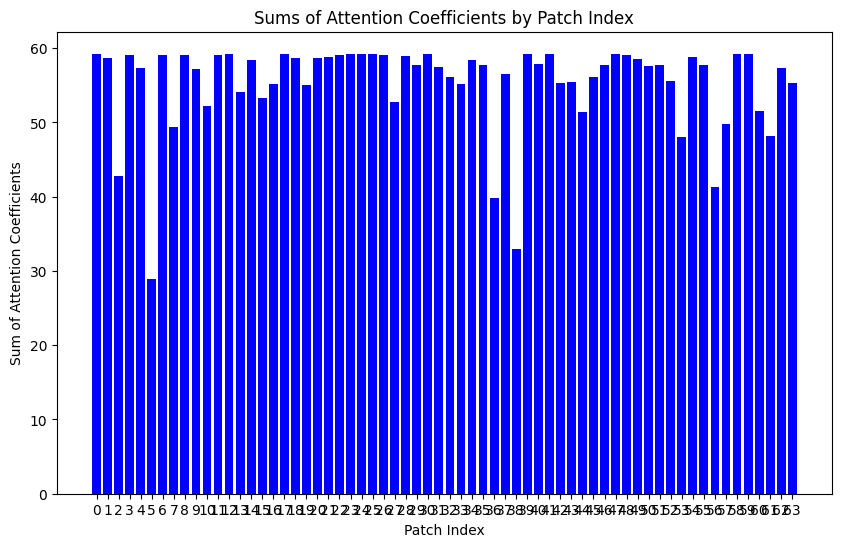

Predicted class for sample 38: 1.0
Row sums: [58.919296 59.596138 42.921444 59.263634 57.986416 32.91253  57.289825
 52.69598  59.538216 54.311348 55.46633  59.605293 59.22207  59.546974
 59.6227   57.279198 50.355484 58.44979  56.201973 59.591896 57.378803
 55.809483 58.781982 58.50101  51.14124  59.0159   53.082245 59.480965
 59.31227  50.547237 58.32836  58.09646  57.035194 57.800503 59.30062
 58.125168 43.406433 59.65275  44.378777 59.656826 59.661064 56.21331
 59.521027 59.655132 41.97304  56.25245  59.51906  59.429024 59.659
 58.049786 59.611927 59.561962 59.62349  59.56327  59.257896 59.3636
 50.759144 58.967453 58.659607 59.629967 57.160576 55.978386 51.139137
 57.18643 ]


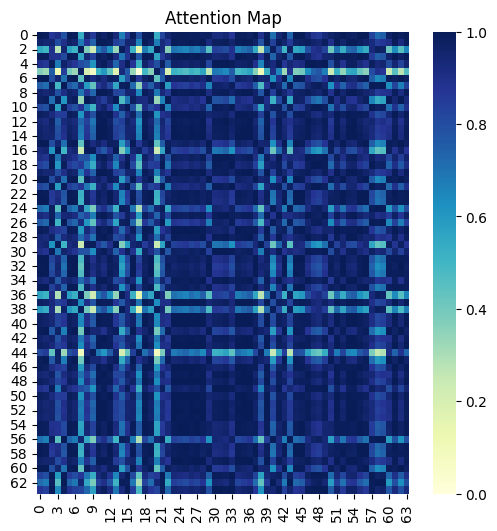

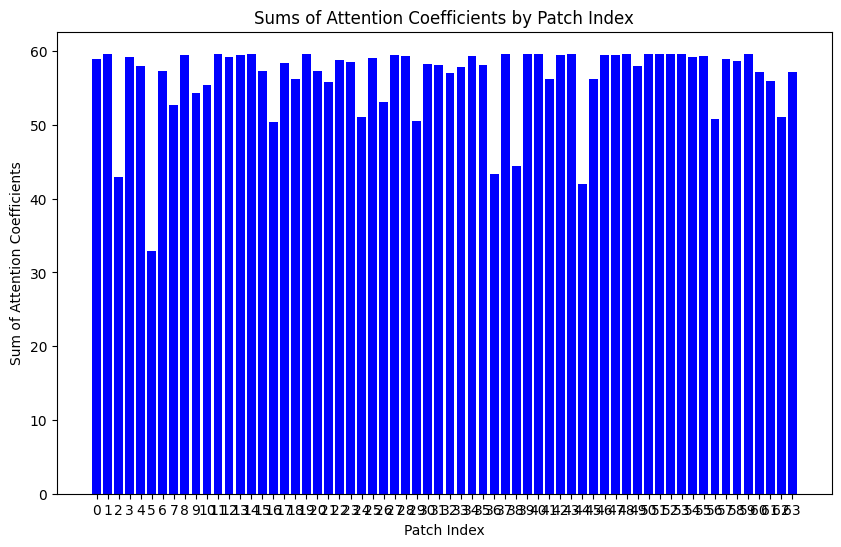

Predicted class for sample 39: 1.0


In [33]:
for i in range(len(X_test)):
    single_sample = torch.tensor(X_test[i:i+1].astype(np.float32))
    with torch.no_grad():
        prediction = attention_model(single_sample).squeeze()
        predicted_class = (torch.round(torch.sigmoid(prediction))).item()
        print(f"Predicted class for sample {i}: {predicted_class}")

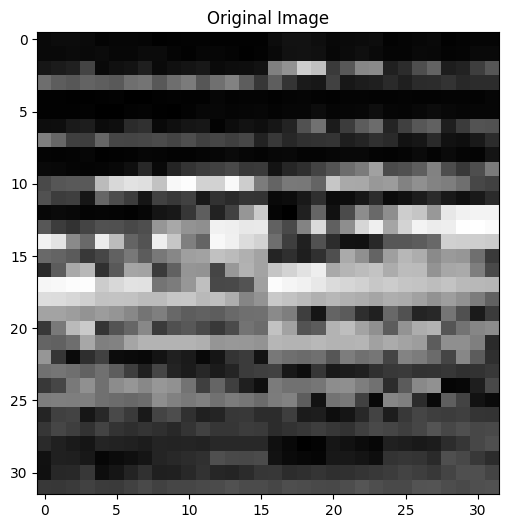

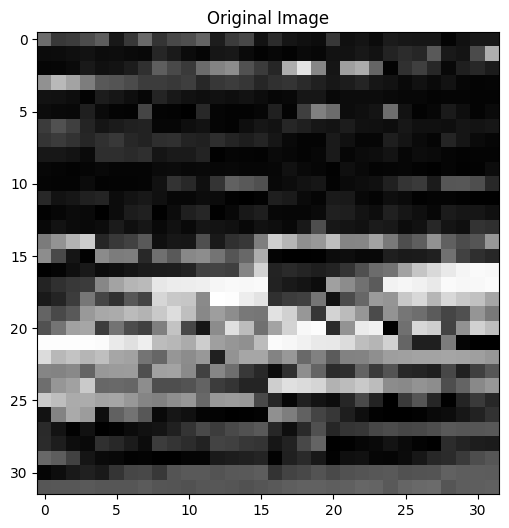

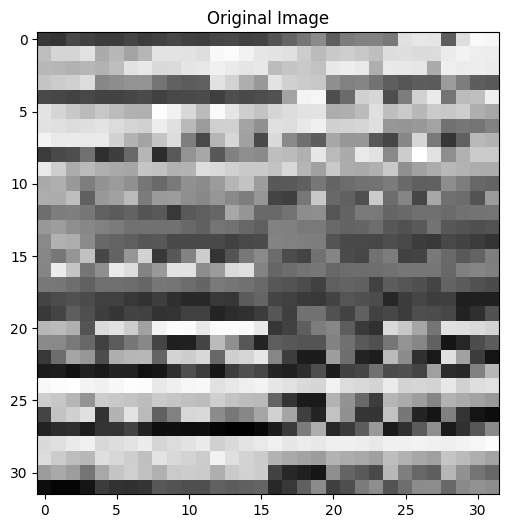

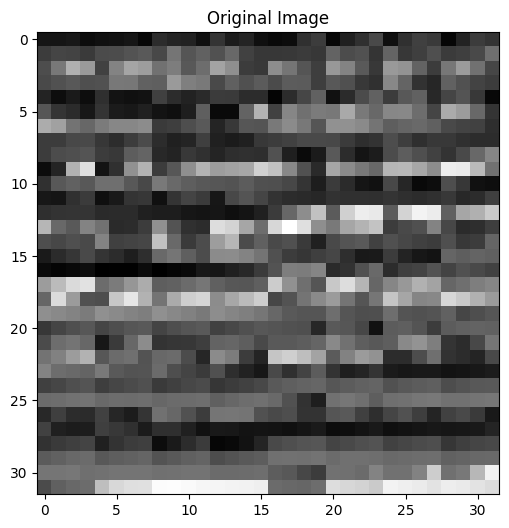

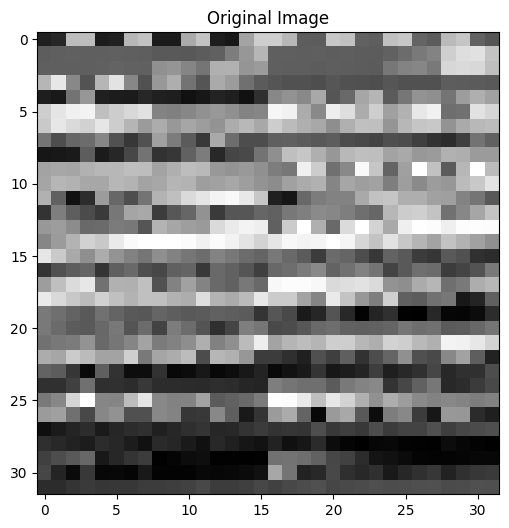

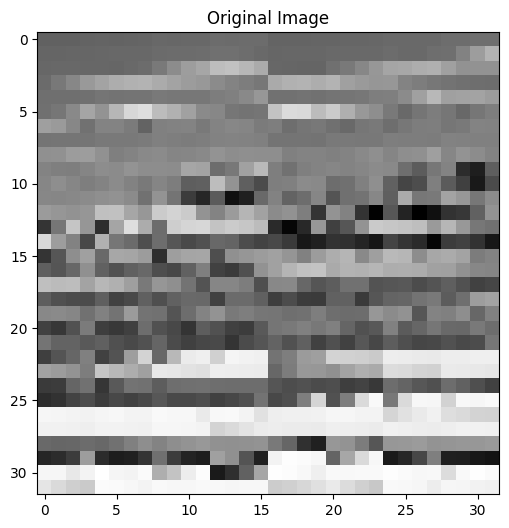

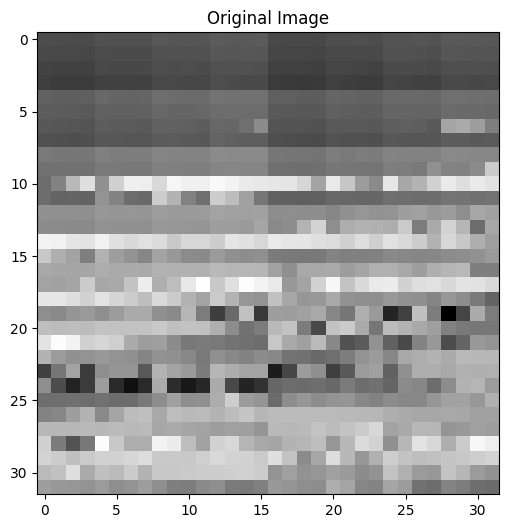

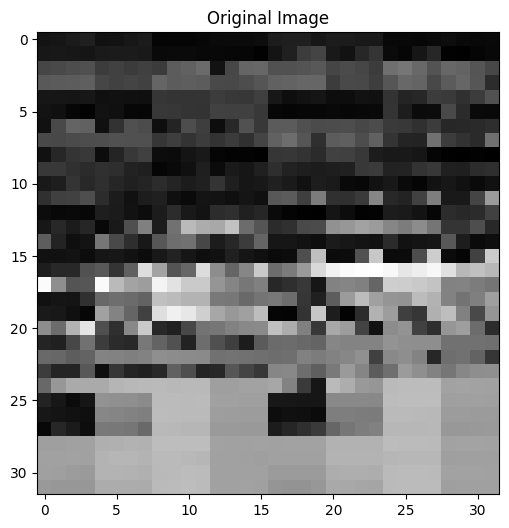

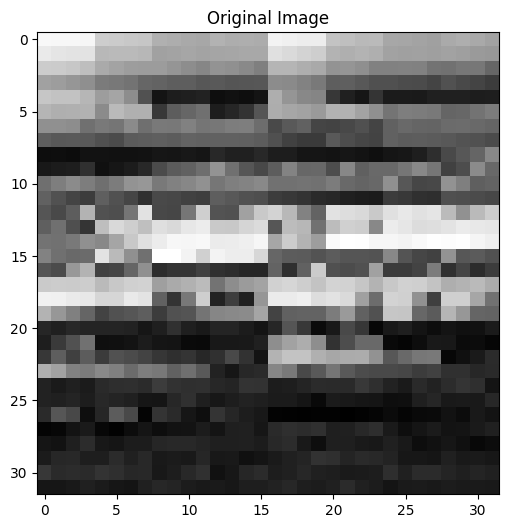

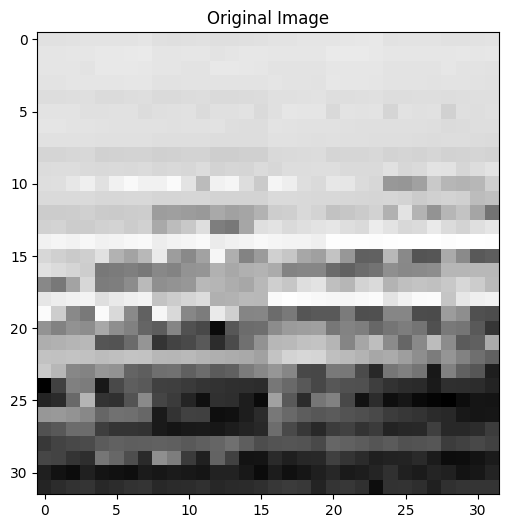

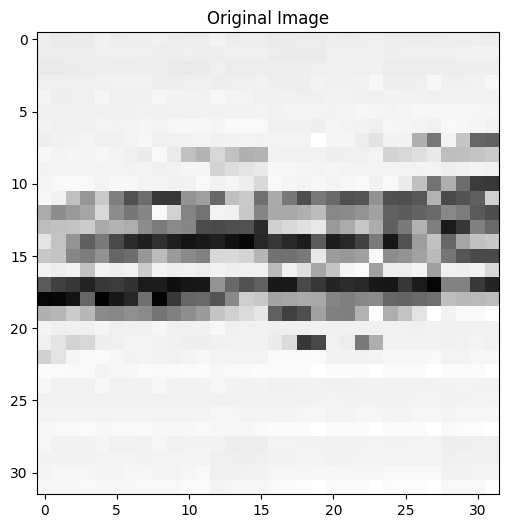

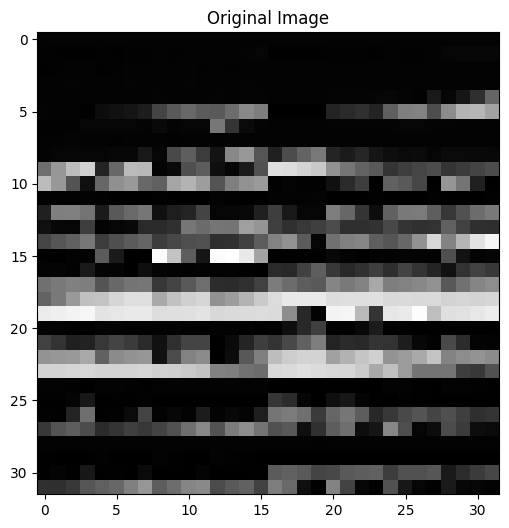

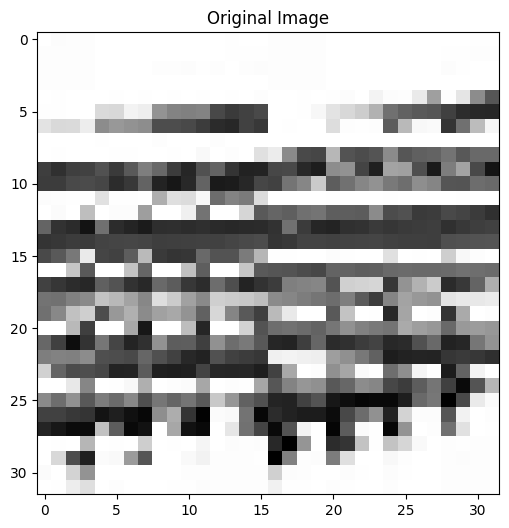

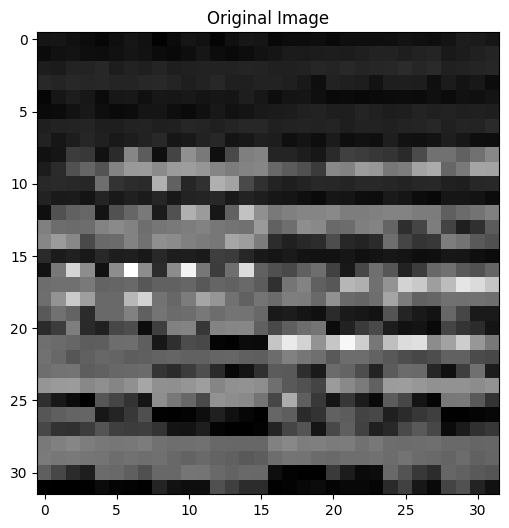

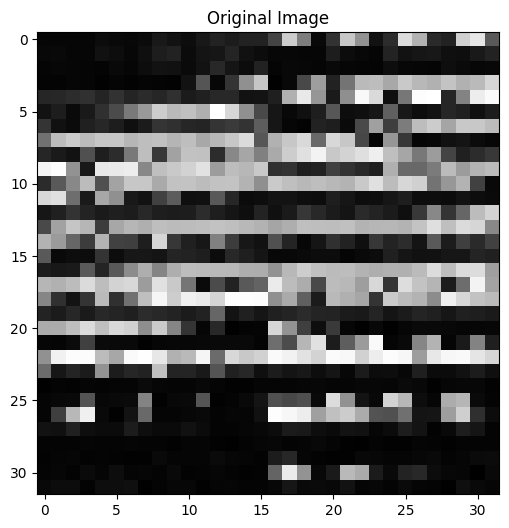

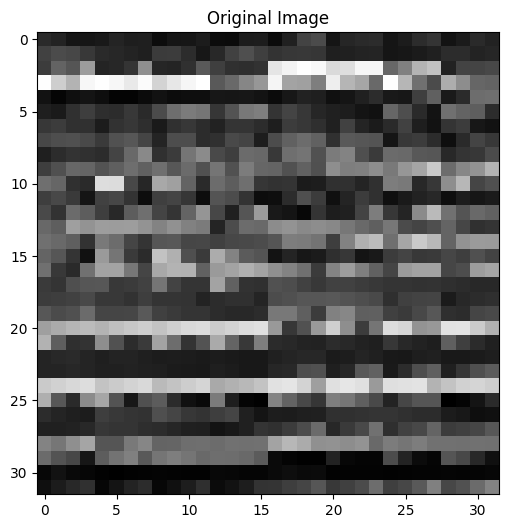

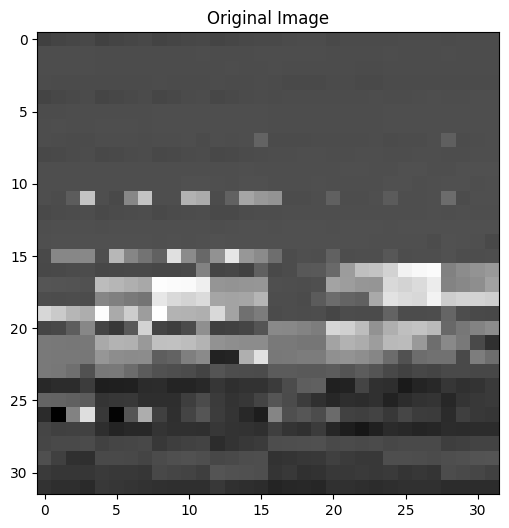

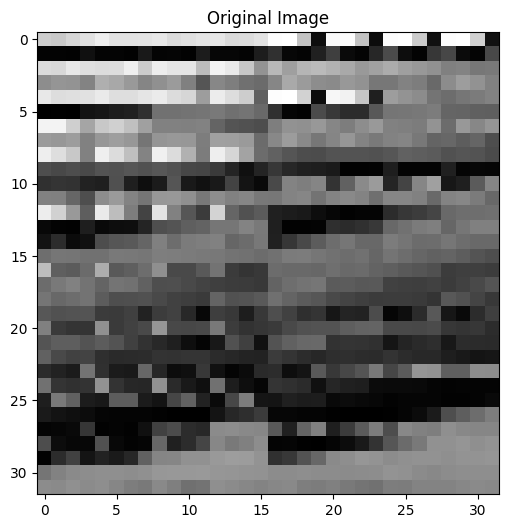

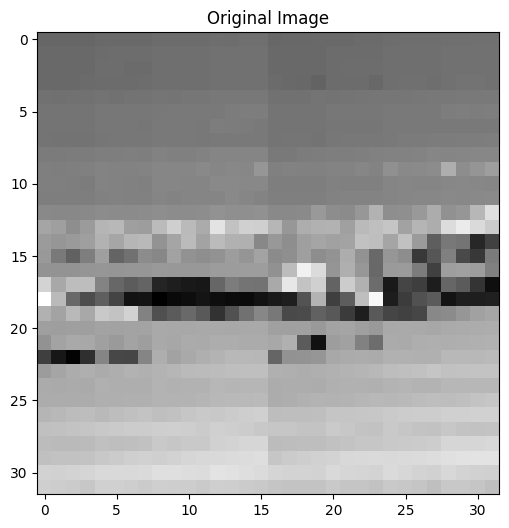

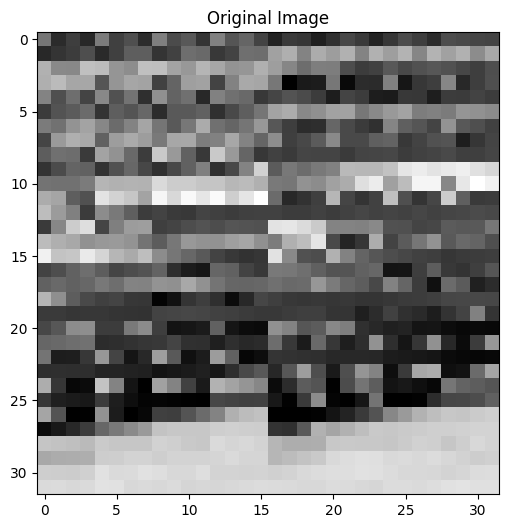

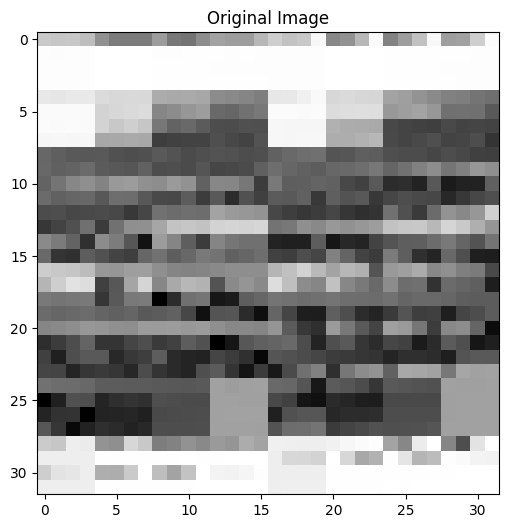

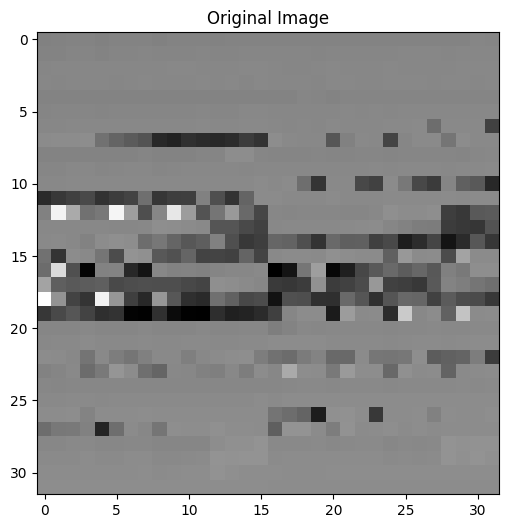

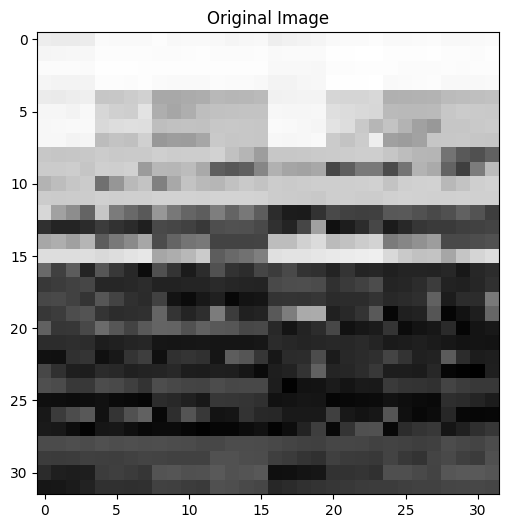

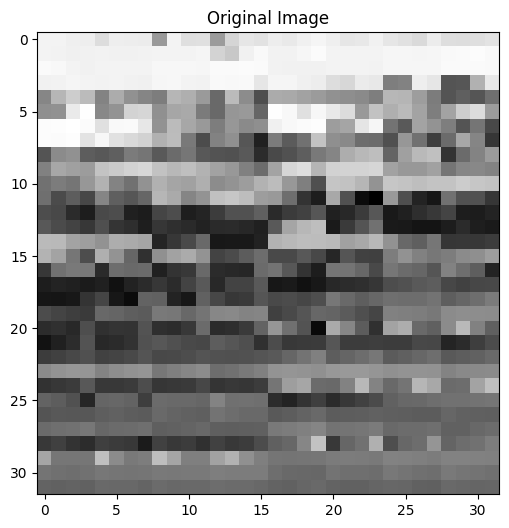

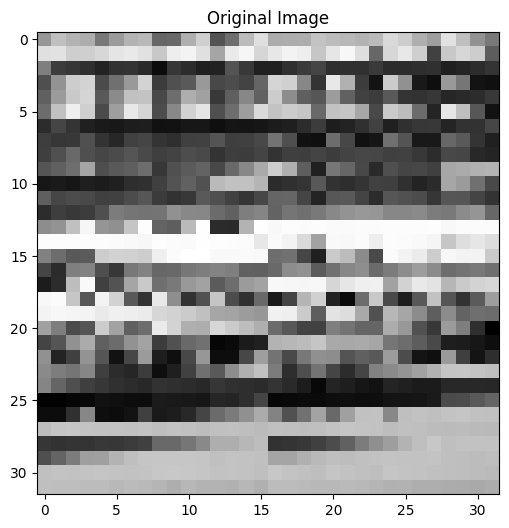

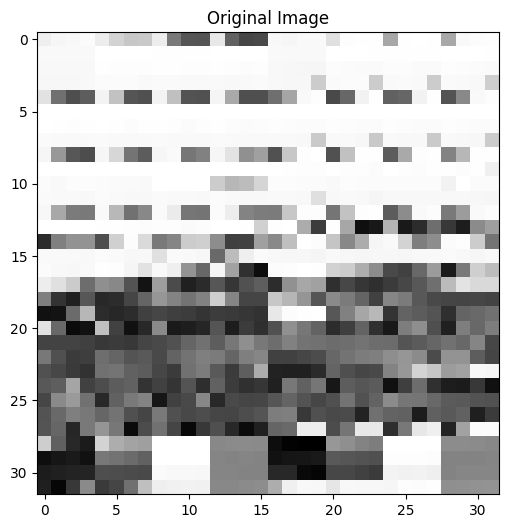

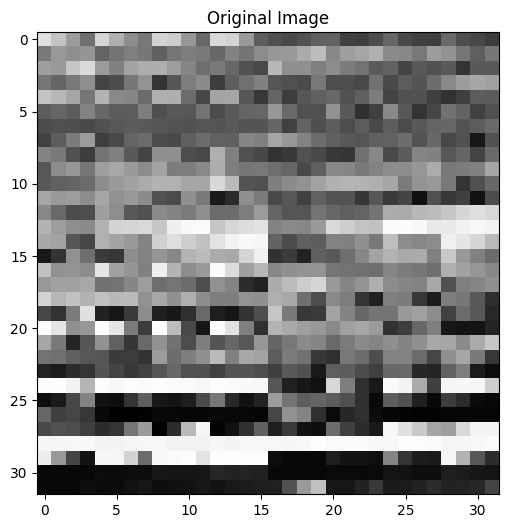

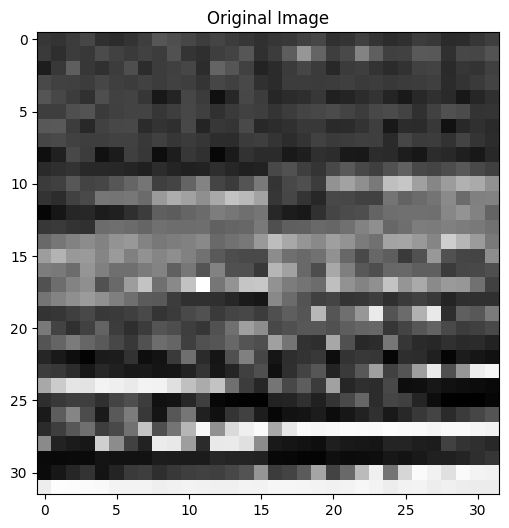

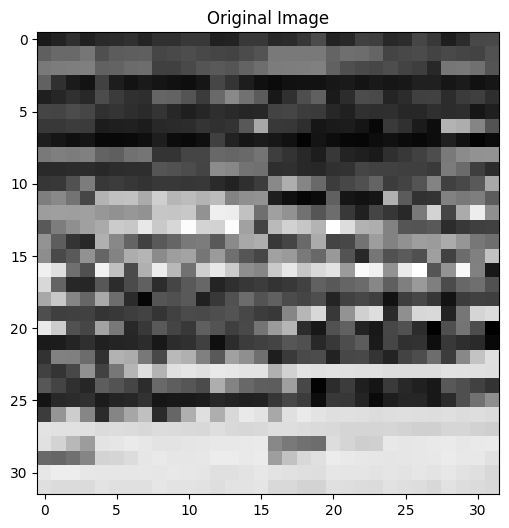

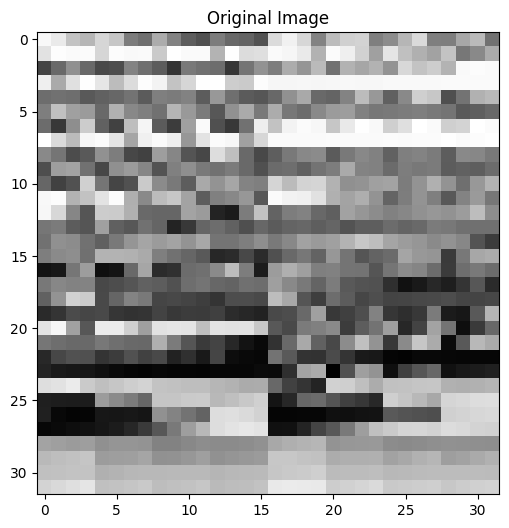

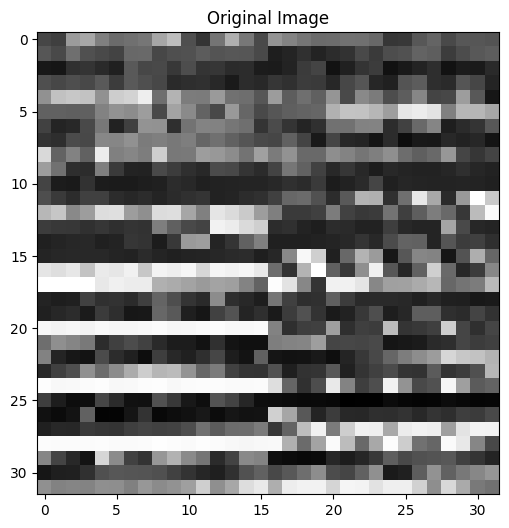

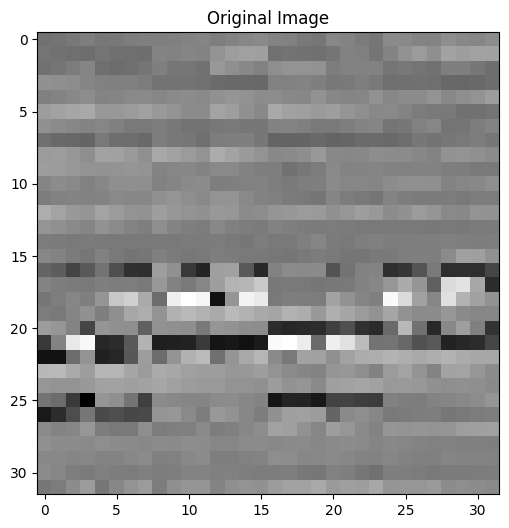

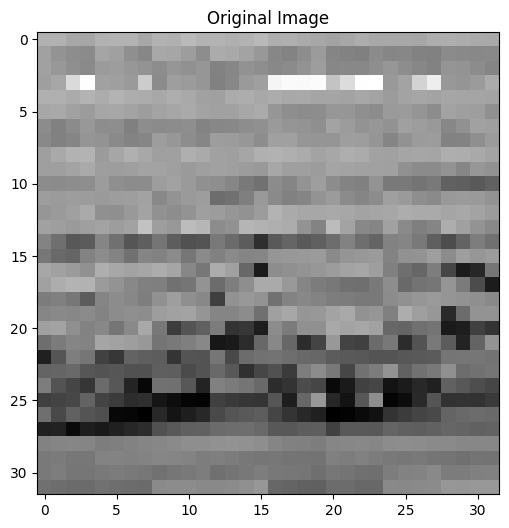

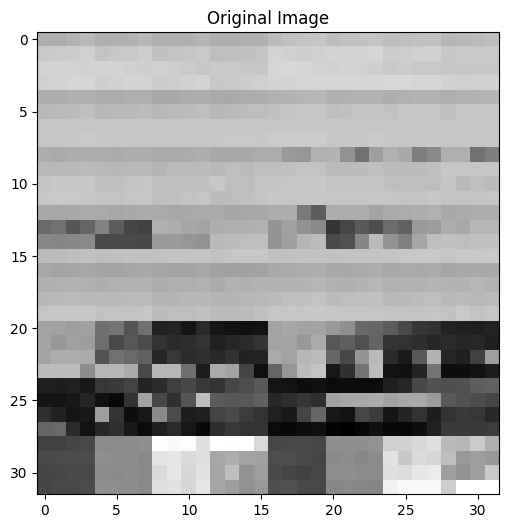

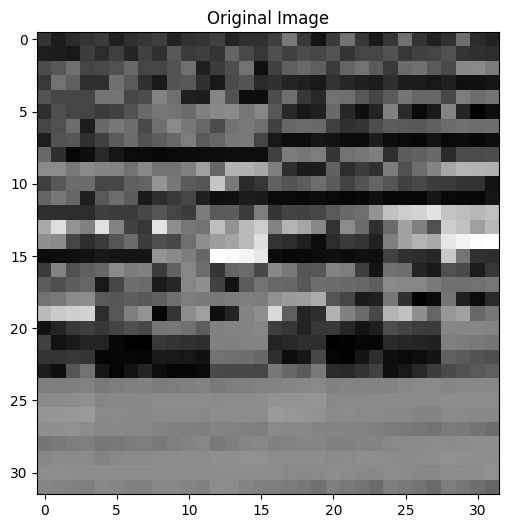

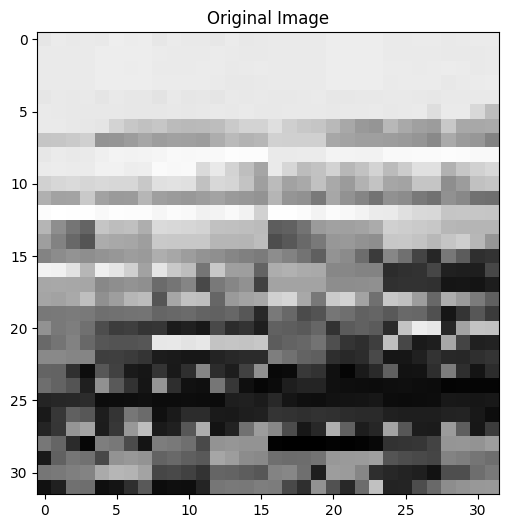

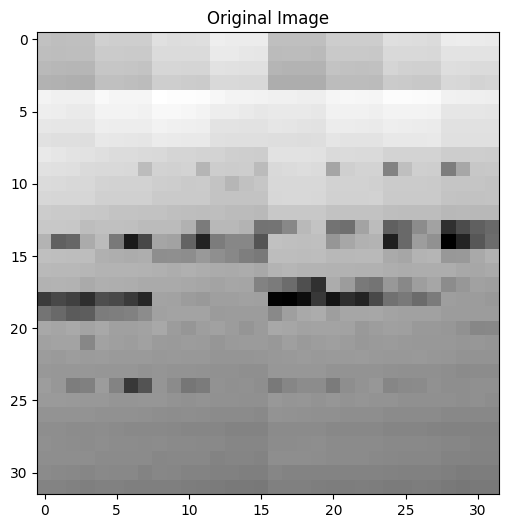

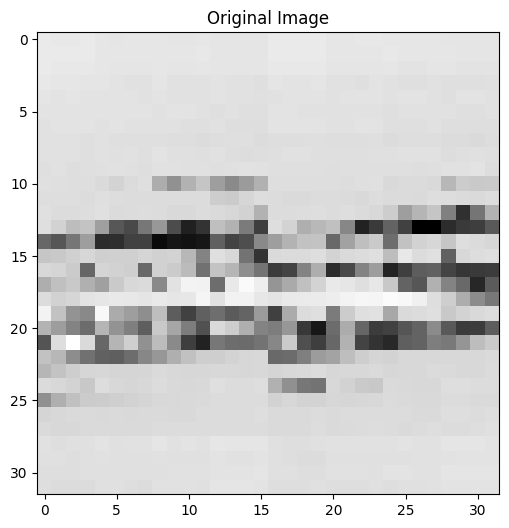

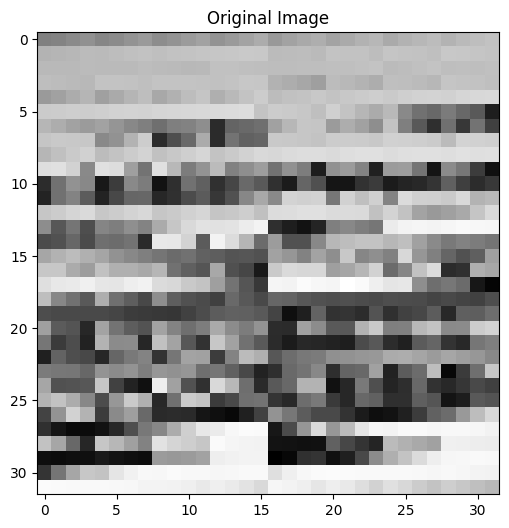

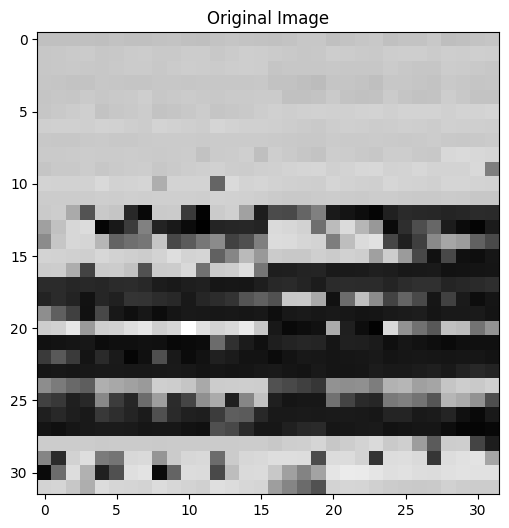

In [34]:
for i in range(len(X_test)):
    single_sample = torch.tensor(X_test[i:i+1].astype(np.float32))
    original_image = single_sample.squeeze().reshape(32, 32).numpy()  # Reshape to 2D
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

-----------------------------------------

In [ ]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# CIFAR-10 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

# RGB -> Grayscale 변환
# 공식: 0.299*R + 0.587*G + 0.114*B
X_train_gray = np.dot(X_train_full[...,:3], [0.299, 0.587, 0.114])
X_test_gray = np.dot(X_test_full[...,:3], [0.299, 0.587, 0.114])

# 원하는 두 개의 클래스만 선택 (예: 클래스 0과 1)
selected_classes = [0, 1]

# 클래스 0과 1에 해당하는 데이터만 선택 (train set)
train_mask = np.isin(y_train_full, selected_classes)
X_train_filtered = X_train_gray[train_mask.squeeze()]
y_train_filtered = y_train_full[train_mask.squeeze()]

# 클래스 0과 1에 해당하는 데이터만 선택 (test set)
test_mask = np.isin(y_test_full, selected_classes)
X_test_filtered = X_test_gray[test_mask.squeeze()]
y_test_filtered = y_test_full[test_mask.squeeze()]

# 클래스 라벨을 이진 라벨로 변환 (0 또는 1로)
y_train_filtered = (y_train_filtered == selected_classes[1]).astype(int)
y_test_filtered = (y_test_filtered == selected_classes[1]).astype(int)

# 시드 고정
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 200
indices = np.random.choice(len(X_train_filtered), num_samples, replace=False)
X_sampled, y_sampled = X_train_filtered[indices], y_train_filtered[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42
)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)

# 결과 출력
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Sampled train labels: {np.unique(y_train)}")
print(f"Sampled test labels: {np.unique(y_test)}")
